# Environment Setup

## Package Installation

In [93]:
# %pip install pandas matplotlib numpy seaborn scikit-learn xgboost patsy statsmodels
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install seaborn
# %pip install pmdarima
# %pip install tqdm
%pip install lightgbm


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 25.2 MB/s eta 0:00:00


## Imports and GPU Configuration

In [2]:
# Cell 1 - Environment Setup and Imports
import warnings
import os
warnings.filterwarnings('ignore')

# Essential libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import platform
from scipy import stats

# Time series specific
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.structural import UnobservedComponents
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

# ML/DL libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting settings - using a more reliable approach
plt.style.use('default')  # Reset to default style
sns.set_style("whitegrid")  # Apply seaborn styling
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

def print_gpu_info():
    """
    Print detailed information about GPU configuration
    """
    print("System Information:")
    print(f"Python version: {sys.version}")
    print(f"Platform: {platform.platform()}")
    print(f"PyTorch version: {torch.__version__}")
    
    print("\nGPU Information:")
    if torch.cuda.is_available():
        print(f"GPU Available: Yes")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        print(f"Current GPU: {torch.cuda.current_device()}")
        print(f"GPU Name: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
        print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
        
        # Test GPU with a simple operation
        print("\nTesting GPU...")
        x = torch.randn(1000, 1000).cuda()
        y = torch.matmul(x, x.t())
        print("GPU test successful!")
    else:
        print("No GPU available. Using CPU.")

print_gpu_info()

Using device: cuda
System Information:
Python version: 3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]
Platform: Windows-11-10.0.26100-SP0
PyTorch version: 2.5.1+cu121

GPU Information:
GPU Available: Yes
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce RTX 4070 Ti
GPU Memory Allocated: 0.00 MB
GPU Memory Reserved: 0.00 MB

Testing GPU...
GPU test successful!


# Data Loading and Preprocessing

- Data Import
- Initial Data Quality Checks
- Missing Values Analysis
- DateTime Index Setup

In [3]:
# Cell 2 - Data Loading and Basic Checks
def load_data(filepath):
    """
    Load and preprocess the time series data
    Parameters:
    filepath (str): Path to the CSV file
    Returns:
    pd.DataFrame: Preprocessed DataFrame with DateTime index
    """
    # Read the CSV file
    df = pd.read_csv(filepath)

    # Try to detect the datetime format automatically
    try:
        df['DateTime'] = pd.to_datetime(df['DateTime'], format='mixed')
    except ValueError as e:
        print(f"Warning: {e}")
        print("Attempting alternative datetime parsing...")
        try:
            df['DateTime'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')
        except Exception as e:
            print(f"Error in datetime parsing: {e}")
            raise

    # Set DateTime as index
    df.set_index('DateTime', inplace=True)

    # Sort index to ensure chronological order
    df.sort_index(inplace=True)

    # Display basic information
    print("\nDataset Info:")
    print(df.info())
    print("\nFirst few rows:")
    print(df.head())
    print("\nLast few rows:")
    print(df.tail())
    print("\nBasic statistics:")
    print(df.describe())

    return df

# Load the data
try:
    df = load_data('ts2024.csv')
except Exception as e:
    print(f"Error loading data: {e}")
    raise


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2015-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    17544 non-null  object 
 1   Hour    17544 non-null  int64  
 2   X       16800 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 548.2+ KB
None

First few rows:
                           Date  Hour       X
DateTime                                     
2015-01-01 00:00:00  2015-01-01     0  0.0146
2015-01-01 01:00:00  2015-01-01     1  0.0148
2015-01-01 02:00:00  2015-01-01     2  0.0101
2015-01-01 03:00:00  2015-01-01     3  0.0060
2015-01-01 04:00:00  2015-01-01     4  0.0055

Last few rows:
                           Date  Hour   X
DateTime                                 
2016-12-31 19:00:00  2016-12-31    19 NaN
2016-12-31 20:00:00  2016-12-31    20 NaN
2016-12-31 21:00:00  2016-12-31    21 NaN
2016-12-31 22:00:00  20

In [4]:
# Cell 3 - Data Quality Analysis and Cleaning
def analyze_data_quality(df):
    """
    Perform comprehensive data quality analysis
    """
    print("=== Data Quality Analysis ===")

    # Basic dataset properties
    print("\n1. Dataset Properties:")
    print(f"Time range: {df.index.min()} to {df.index.max()}")
    print(f"Total number of records: {len(df)}")
    print(f"Sampling frequency: {df.index.freq if df.index.freq else 'Inferred hourly'}")

    # Check for duplicates
    duplicates = df.index.duplicated(keep=False)
    if duplicates.any():
        n_duplicates = duplicates.sum()
        print(f"\nWarning: Found {n_duplicates} duplicate timestamps!")
        print("\nExample of duplicates:")
        print(df[duplicates].sort_index().head())

    # Check for time series continuity
    expected_periods = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    missing_periods = set(expected_periods) - set(df.index)

    print("\n2. Time Series Continuity:")
    print(f"Number of missing timestamps: {len(missing_periods)}")
    if missing_periods:
        print("Sample of missing timestamps:")
        print(sorted(list(missing_periods))[:5])

    # Value distribution analysis
    print("\n3. Value Distribution (X):")
    print(df['X'].describe())

    # Outlier detection
    Q1 = df['X'].quantile(0.25)
    Q3 = df['X'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['X'] < (Q1 - 1.5 * IQR)) | (df['X'] > (Q3 + 1.5 * IQR))]

    print("\n4. Outlier Analysis:")
    print(f"Number of potential outliers: {len(outliers)}")
    if len(outliers) > 0:
        print("Sample of outliers:")
        print(outliers.head())

    # Missing data patterns
    print("\n5. Missing Data Patterns:")
    missing_by_month = df['X'].isna().groupby(df.index.month).sum()
    print("Missing values by month:")
    print(missing_by_month)

    return missing_periods, outliers, duplicates

def clean_data(df, duplicates):
    """
    Clean the data by:
    1. Handling duplicates by taking their mean
    2. Filling ONLY the two specific missing timestamps in historical data
    3. Keeping the last 744 values as missing for forecasting
    """
    print("=== Data Cleaning ===")
    
    df_cleaned = df.copy()
    
    # Step 1: Handle duplicates by taking the mean of X values for same timestamps
    if duplicates.any():
        print("\nHandling duplicates by taking the mean value for each timestamp...")
        df_cleaned = df_cleaned.groupby(level=0).agg({
            'Date': 'first',  # Keep first date string
            'Hour': 'first',  # Keep first hour
            'X': 'mean'      # Take mean of X values
        })
        print(f"After handling duplicates: {len(df_cleaned)} rows")
    
    # Step 2: Handle ONLY the two specific missing timestamps
    specific_missing = pd.to_datetime(['2015-03-29 02:00:00', '2016-03-27 02:00:00'])
    
    for timestamp in specific_missing:
        if timestamp in df_cleaned.index:
            continue
            
        # Get the same hour from the day before and after
        prev_day = df_cleaned.loc[timestamp - pd.Timedelta(days=1):timestamp - pd.Timedelta(days=1), 'X'].iloc[0]
        next_day = df_cleaned.loc[timestamp + pd.Timedelta(days=1):timestamp + pd.Timedelta(days=1), 'X'].iloc[0]
        
        # Create new row with interpolated value
        df_cleaned.loc[timestamp] = {
            'Date': timestamp.date(),
            'Hour': timestamp.hour,
            'X': (prev_day + next_day) / 2
        }
    
    # Sort index to ensure chronological order
    df_cleaned.sort_index(inplace=True)
    
    # Verify the cleaning worked correctly
    print("\nVerification after cleaning:")
    n_missing = df_cleaned['X'].isna().sum()
    print(f"Total missing values (should be 744): {n_missing}")
    
    if n_missing != 744:
        raise ValueError(f"ERROR: Expected 744 missing values, but found {n_missing}")
        
    return df_cleaned

# Analyze and clean data
missing_periods, outliers, duplicates = analyze_data_quality(df)

=== Data Quality Analysis ===

1. Dataset Properties:
Time range: 2015-01-01 00:00:00 to 2016-12-31 23:00:00
Total number of records: 17544
Sampling frequency: Inferred hourly


Example of duplicates:
                           Date  Hour       X
DateTime                                     
2015-10-25 02:00:00  2015-10-25     2  0.0060
2015-10-25 02:00:00  2015-10-25     2  0.0053
2016-10-30 02:00:00  2016-10-30     2  0.0072
2016-10-30 02:00:00  2016-10-30     2  0.0062

2. Time Series Continuity:
Number of missing timestamps: 2
Sample of missing timestamps:
[Timestamp('2015-03-29 02:00:00'), Timestamp('2016-03-27 02:00:00')]

3. Value Distribution (X):
count    16800.000000
mean         0.046320
std          0.048945
min          0.000000
25%          0.018200
50%          0.036800
75%          0.053800
max          0.450000
Name: X, dtype: float64

4. Outlier Analysis:
Number of potential outliers: 1010
Sample of outliers:
                           Date  Hour       X
DateTime     

In [5]:
df = clean_data(df, duplicates)

=== Data Cleaning ===

Handling duplicates by taking the mean value for each timestamp...
After handling duplicates: 17542 rows

Verification after cleaning:
Total missing values (should be 744): 744


In [6]:
# Cell 4 - Data Preprocessing and Feature Engineering
def preprocess_data(df):
    """
    Preprocess the time series data and engineer features
    """
    print("=== Data Preprocessing and Feature Engineering ===")

    # Create a copy to avoid modifying original data
    df_processed = df.copy()

    # Add time-based features
    df_processed['hour'] = df_processed.index.hour
    df_processed['day_of_week'] = df_processed.index.dayofweek
    df_processed['month'] = df_processed.index.month
    df_processed['is_weekend'] = df_processed.index.dayofweek.isin([5, 6]).astype(int)

    # Calculate rolling statistics (excluding the missing period)
    non_missing = df_processed[df_processed['X'].notna()]
    df_processed['rolling_mean_24h'] = non_missing['X'].rolling(window=24, min_periods=1).mean()
    df_processed['rolling_std_24h'] = non_missing['X'].rolling(window=24, min_periods=1).std()

    # Print summary of changes
    print("\nAdded features:")
    for col in df_processed.columns:
        print(f"- {col}")

    print("\nProcessing Summary:")
    print(f"Original shape: {df.shape}")
    print(f"Processed shape: {df_processed.shape}")

    return df_processed

# Preprocess the data
df_processed = preprocess_data(df)

=== Data Preprocessing and Feature Engineering ===

Added features:
- Date
- Hour
- X
- hour
- day_of_week
- month
- is_weekend
- rolling_mean_24h
- rolling_std_24h

Processing Summary:
Original shape: (17544, 3)
Processed shape: (17544, 9)


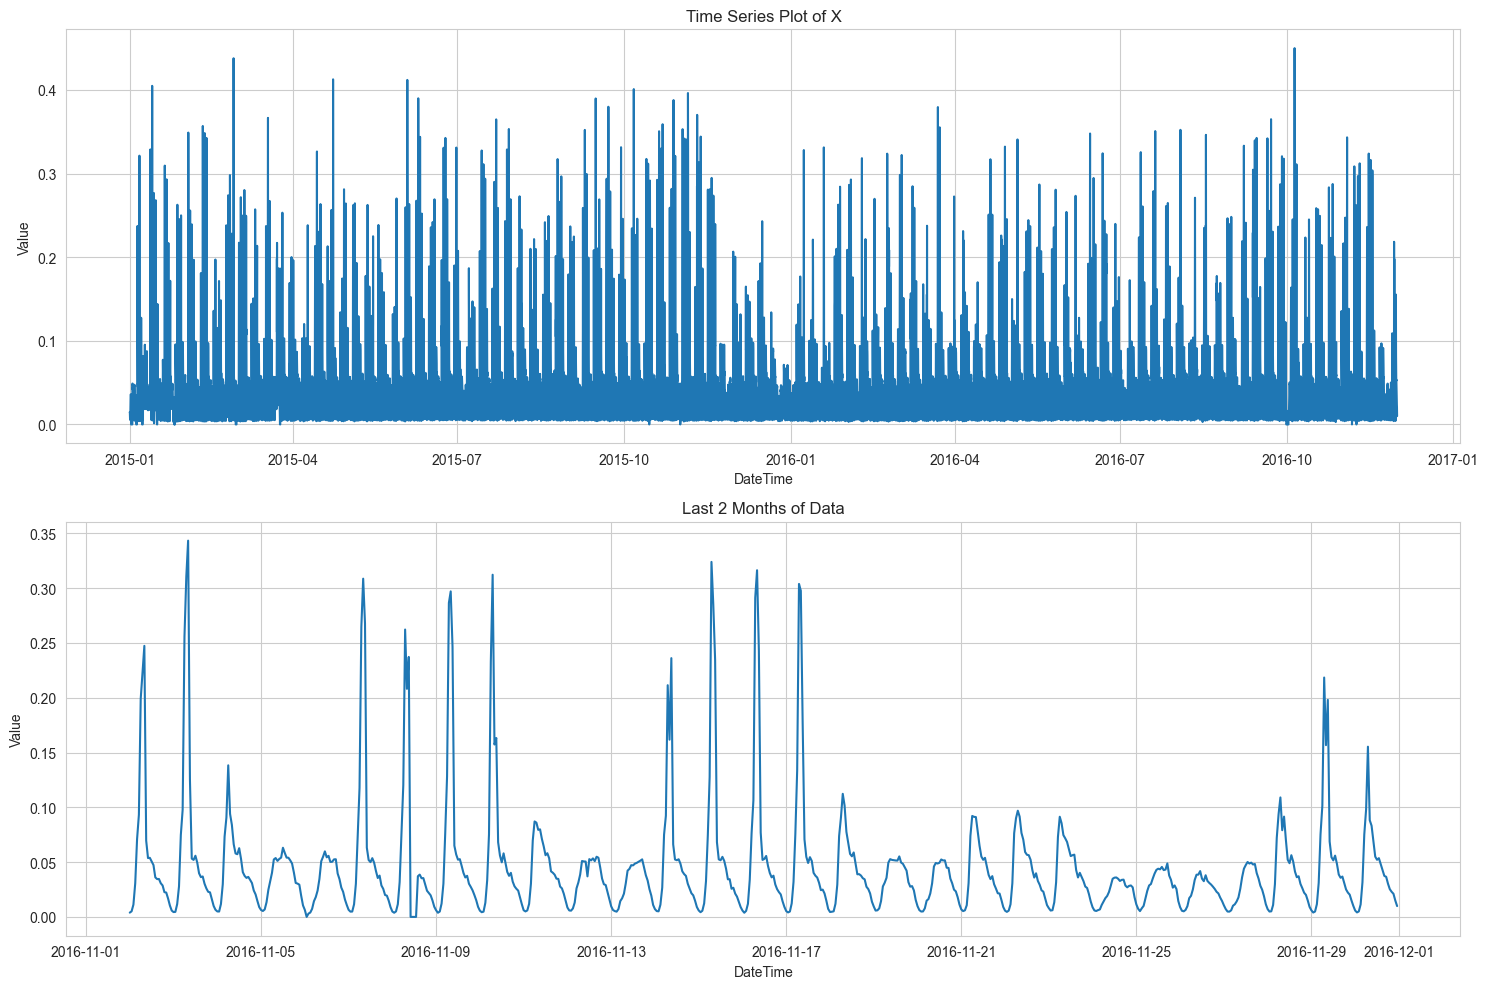

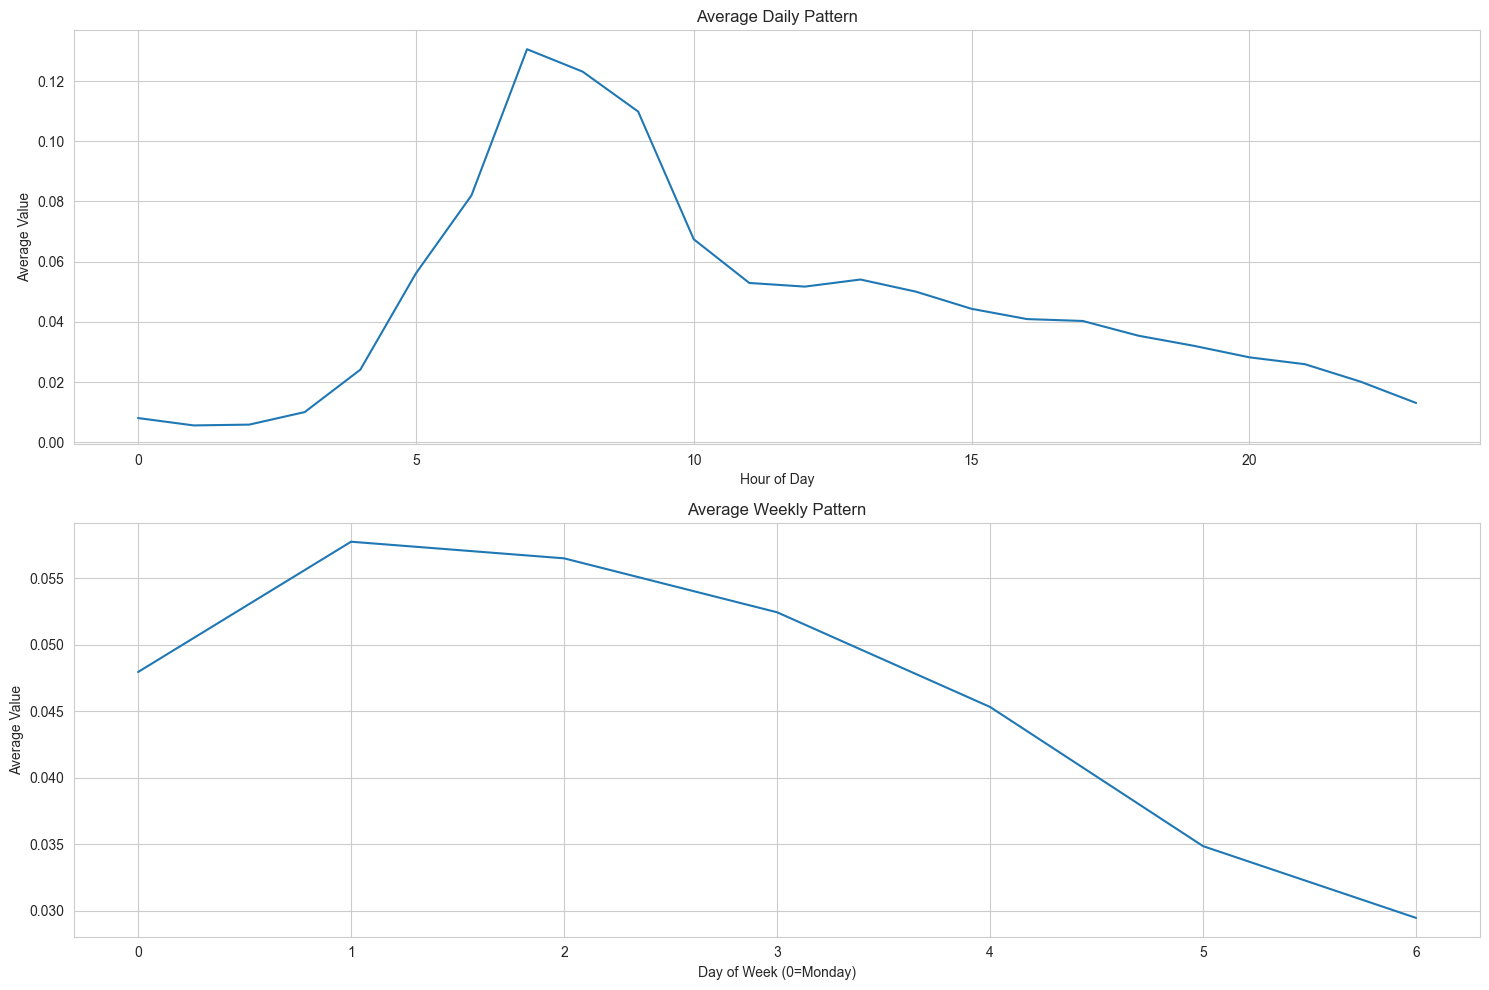

In [7]:
# Cell 5 - Initial Visualizations
def plot_time_series(df):
    """
    Create initial visualizations of the time series data
    """
    # Plot the entire time series
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(df.index, df['X'])
    plt.title('Time Series Plot of X')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.grid(True)

    # Plot the last 2 months of data
    last_2_months = df.last('60D')
    plt.subplot(2, 1, 2)
    plt.plot(last_2_months.index, last_2_months['X'])
    plt.title('Last 2 Months of Data')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_patterns(df):
    """
    Plot daily and weekly patterns
    """
    plt.figure(figsize=(15, 10))

    # Daily pattern
    plt.subplot(2, 1, 1)
    daily_pattern = df.groupby(df.index.hour)['X'].mean()
    plt.plot(daily_pattern.index, daily_pattern.values)
    plt.title('Average Daily Pattern')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Value')
    plt.grid(True)

    # Weekly pattern
    plt.subplot(2, 1, 2)
    weekly_pattern = df.groupby(df.index.dayofweek)['X'].mean()
    plt.plot(weekly_pattern.index, weekly_pattern.values)
    plt.title('Average Weekly Pattern')
    plt.xlabel('Day of Week (0=Monday)')
    plt.ylabel('Average Value')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Create visualizations
plot_time_series(df)
plot_patterns(df)

=== Stationarity Analysis ===
ADF Statistic: -15.709489956924452
p-value: 1.3650064331681149e-28
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


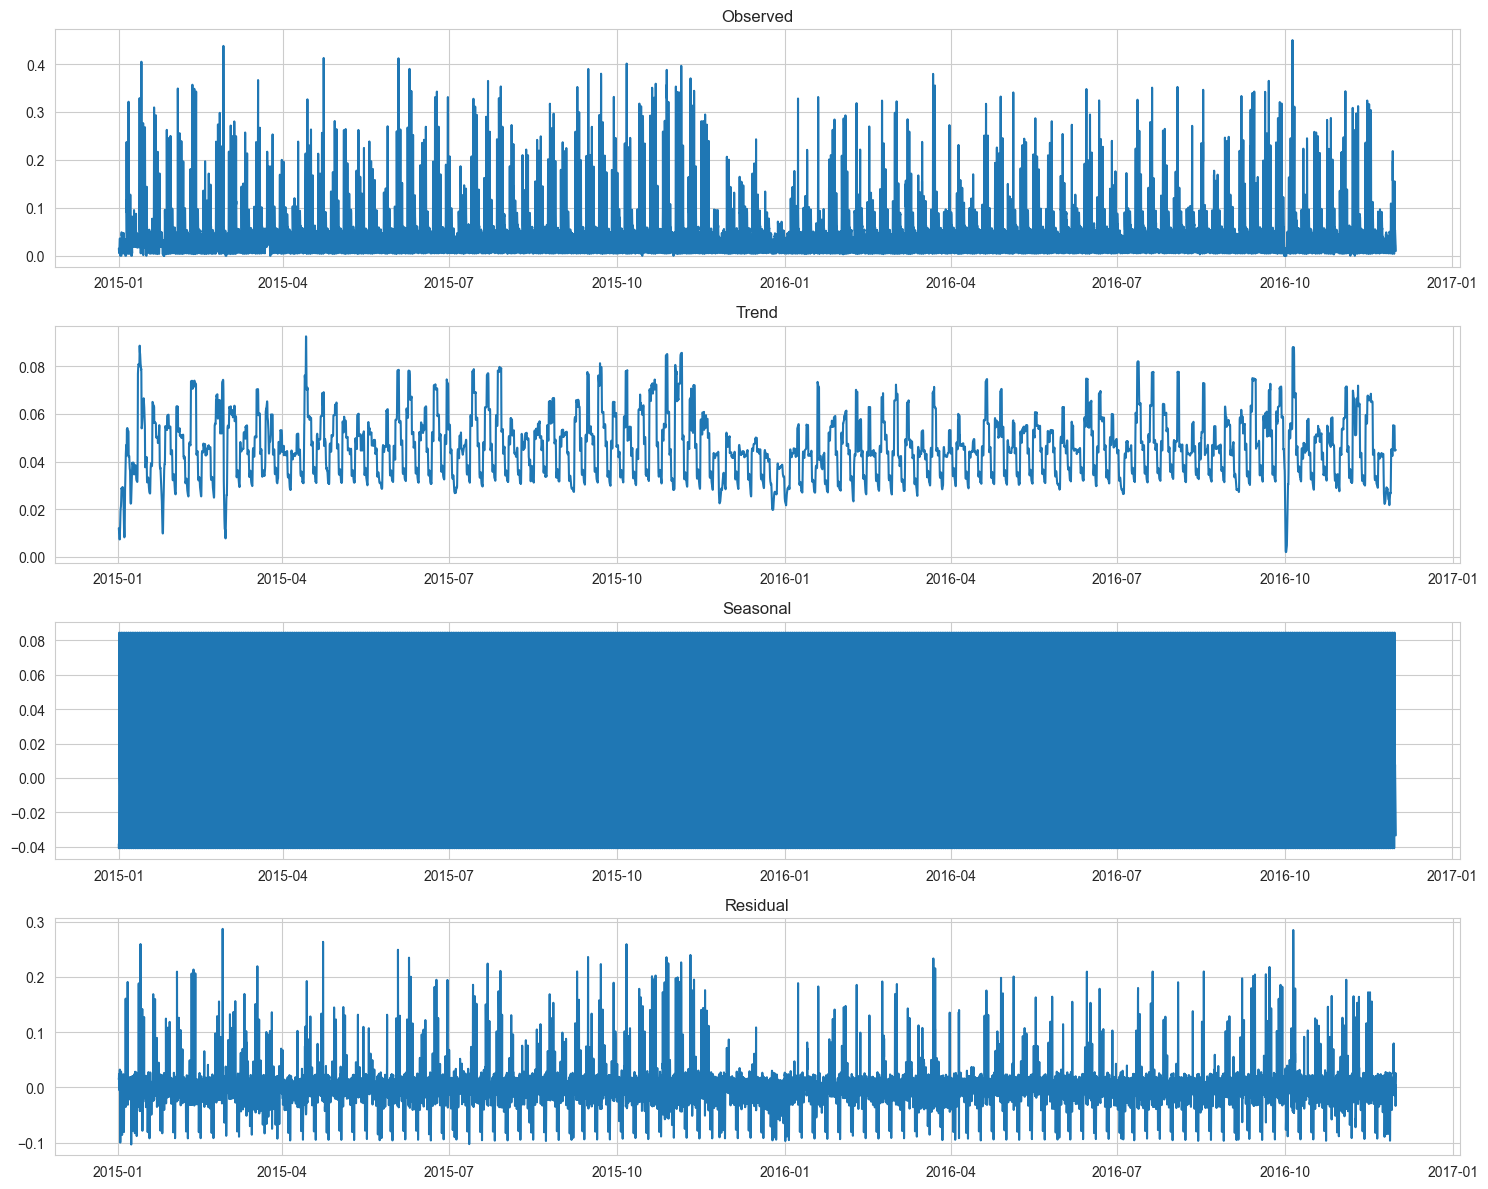

In [8]:
# Cell 6 - Statistical Analysis
def analyze_stationarity(series):
    """
    Perform stationarity analysis and seasonal decomposition
    """
    # Stationarity test
    print("=== Stationarity Analysis ===")
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    # Seasonal decomposition
    decomposition = seasonal_decompose(series.dropna(), period=24)  # 24 hours for daily seasonality

    # Plot decomposition
    plt.figure(figsize=(15, 12))
    plt.subplot(411)
    plt.plot(decomposition.observed)
    plt.title('Observed')
    plt.subplot(412)
    plt.plot(decomposition.trend)
    plt.title('Trend')
    plt.subplot(413)
    plt.plot(decomposition.seasonal)
    plt.title('Seasonal')
    plt.subplot(414)
    plt.plot(decomposition.resid)
    plt.title('Residual')
    plt.tight_layout()
    plt.show()

    return decomposition

# Perform statistical analysis
decomposition = analyze_stationarity(df['X'])

=== Advanced Time Series Analysis ===

Analyzing multiple seasonality patterns...


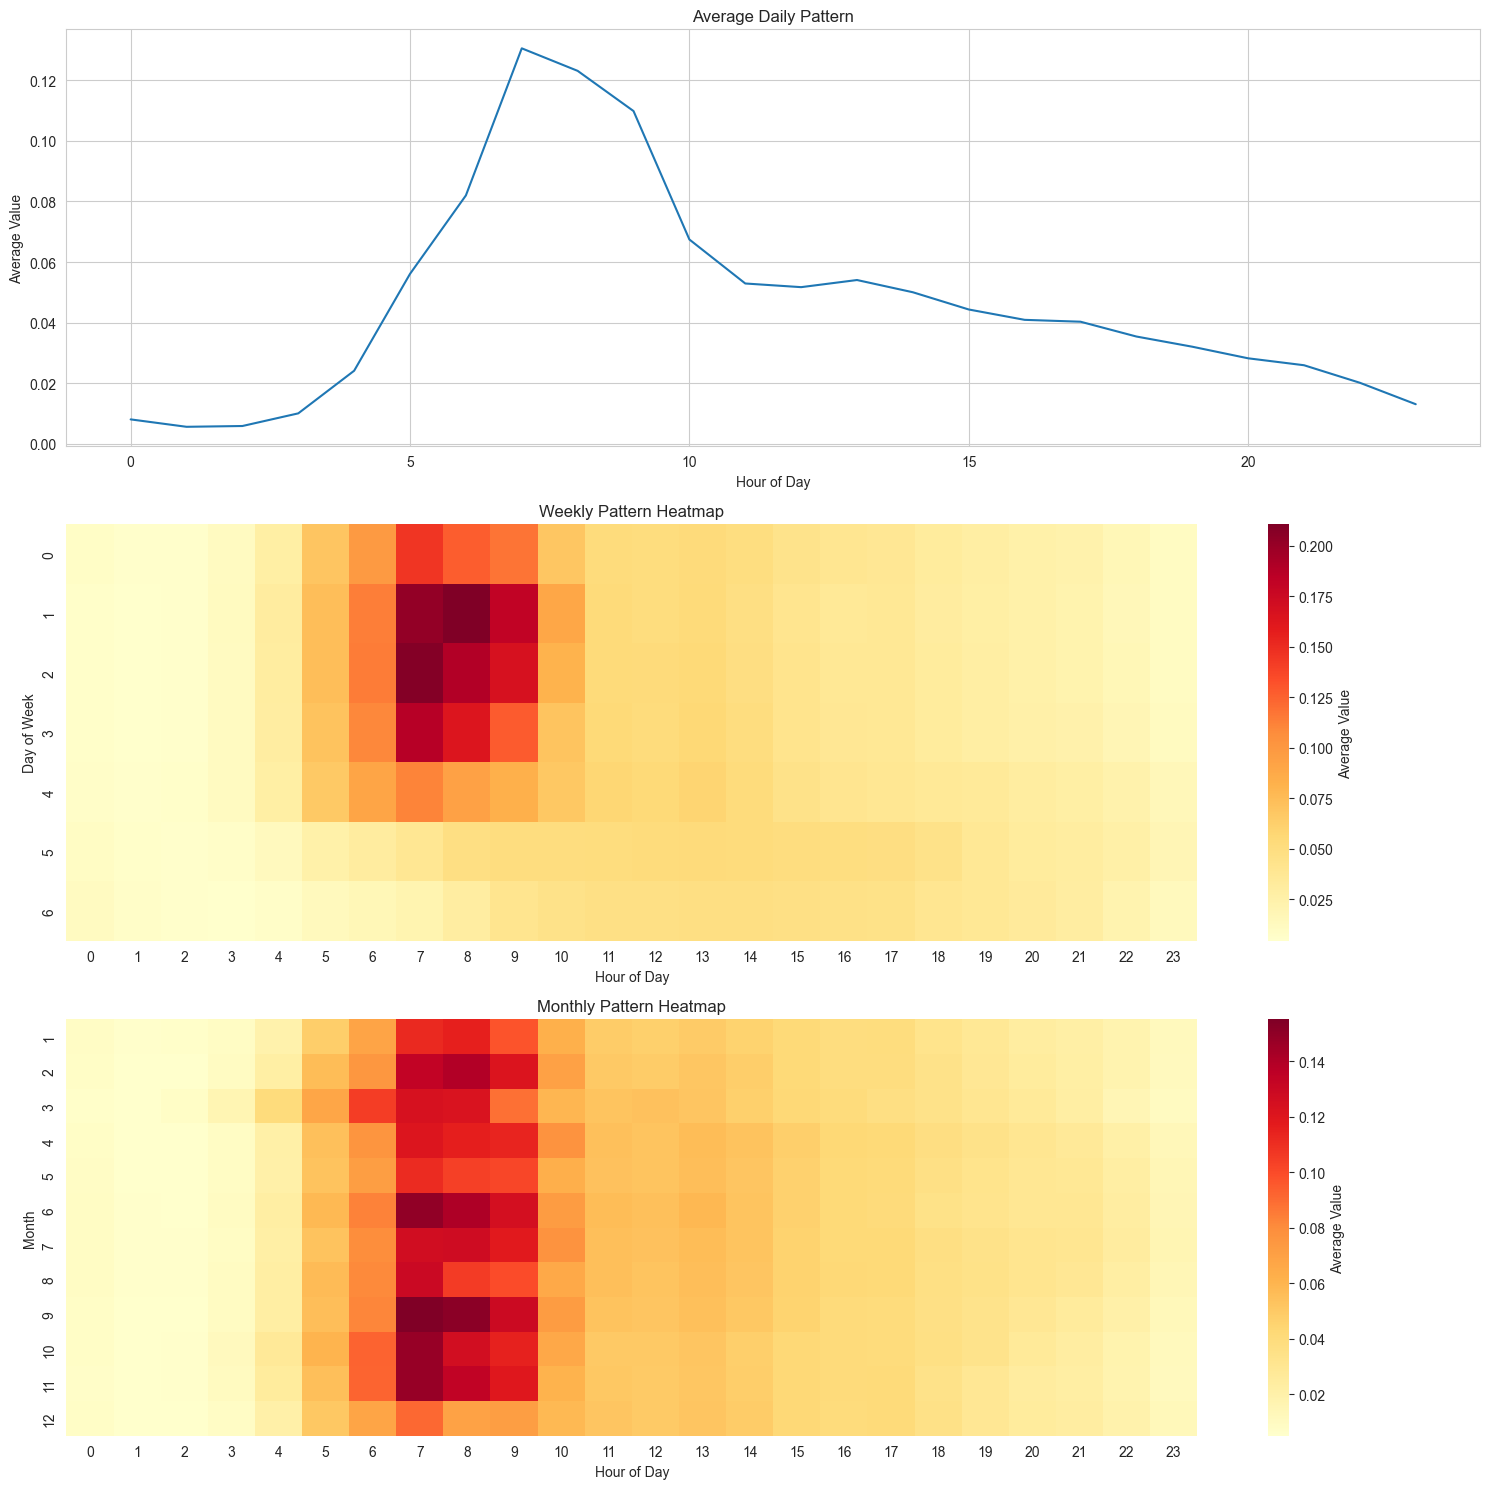

In [9]:
# Cell 7 - Advanced Time Series Analysis
print("=== Advanced Time Series Analysis ===")

def plot_acf_pacf(series, lags=40):
    """
    Plot ACF and PACF for the time series
    """
    plt.figure(figsize=(15, 10))
    
    # Plot ACF
    plt.subplot(211)
    plot_acf(series.dropna(), lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function')
    
    # Plot PACF
    plt.subplot(212)
    plot_pacf(series.dropna(), lags=lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function')
    
    plt.tight_layout()
    plt.show()

def analyze_multiple_seasonality(df):
    """
    Analyze multiple seasonal patterns in the data
    """
    # Daily seasonality
    daily_pattern = df.groupby(df.index.hour)['X'].mean()
    
    # Weekly seasonality
    weekly_pattern = df.groupby([df.index.dayofweek, df.index.hour])['X'].mean()
    weekly_pattern = weekly_pattern.unstack()
    
    # Monthly seasonality
    monthly_pattern = df.groupby([df.index.month, df.index.hour])['X'].mean()
    monthly_pattern = monthly_pattern.unstack()
    
    # Plotting
    fig = plt.figure(figsize=(15, 15))
    
    # Daily pattern
    plt.subplot(311)
    daily_pattern.plot()
    plt.title('Average Daily Pattern')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Value')
    
    # Weekly pattern
    plt.subplot(312)
    sns.heatmap(weekly_pattern, cmap='YlOrRd', cbar_kws={'label': 'Average Value'})
    plt.title('Weekly Pattern Heatmap')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    
    # Monthly pattern
    plt.subplot(313)
    sns.heatmap(monthly_pattern, cmap='YlOrRd', cbar_kws={'label': 'Average Value'})
    plt.title('Monthly Pattern Heatmap')
    plt.xlabel('Hour of Day')
    plt.ylabel('Month')
    
    plt.tight_layout()
    plt.show()
    
    return daily_pattern, weekly_pattern, monthly_pattern

# Execute the functions
print("\nAnalyzing multiple seasonality patterns...")
daily_pattern, weekly_pattern, monthly_pattern = analyze_multiple_seasonality(df)



=== ACF and PACF Analysis of Original Series ===


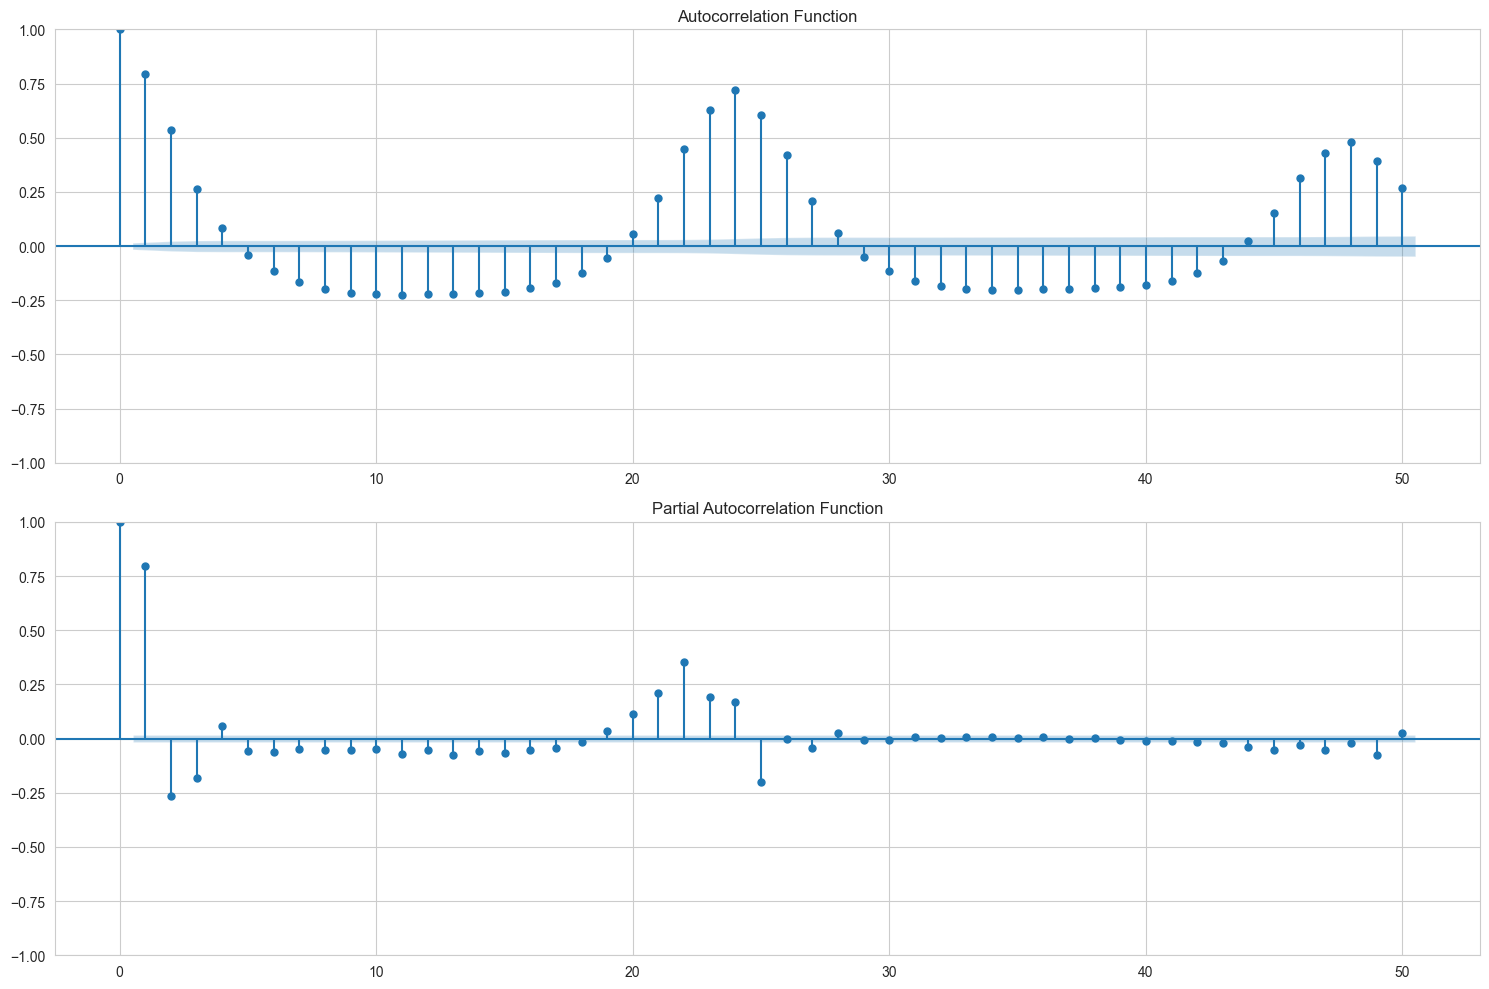


=== ACF and PACF Analysis of First Difference ===


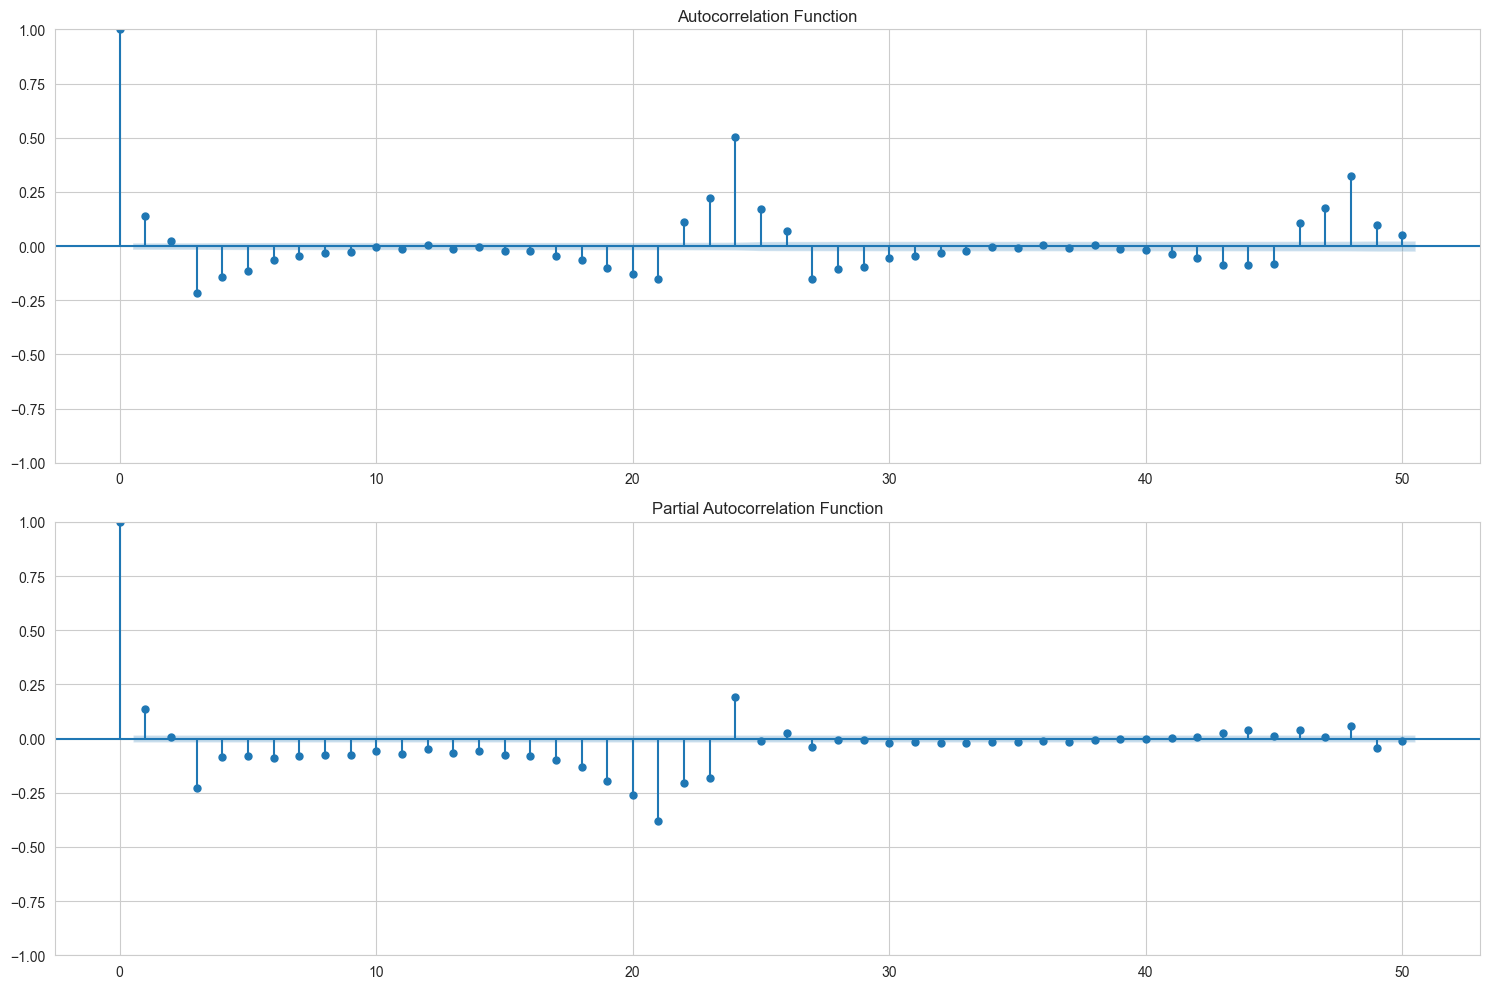


=== ACF and PACF Analysis of Seasonal Difference (24 hours) ===


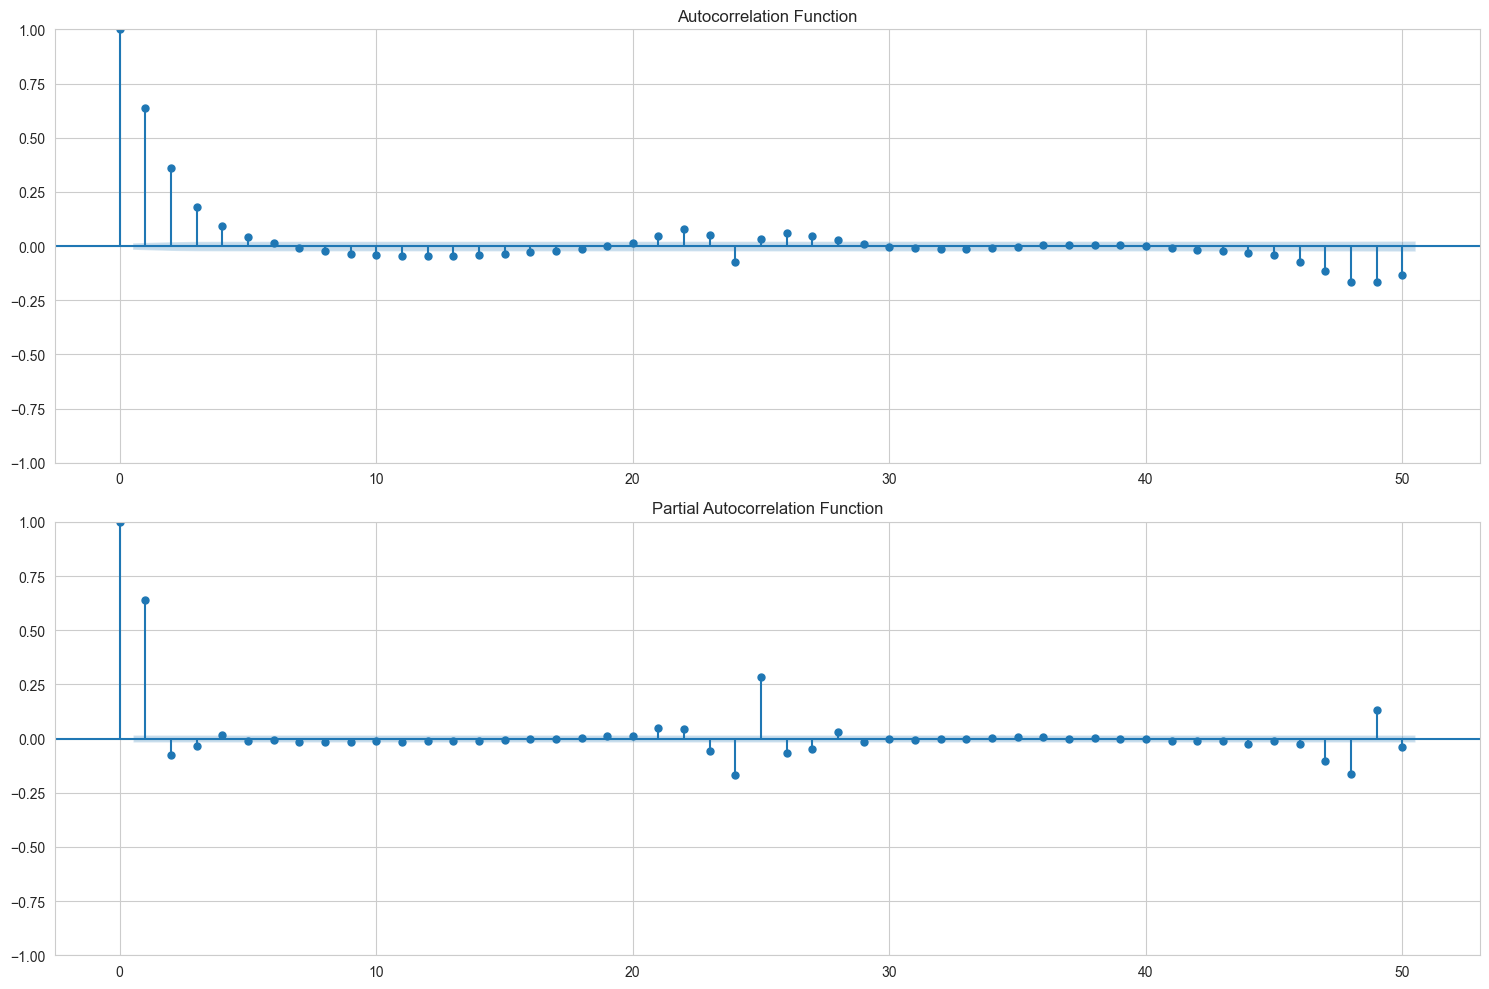


=== ACF and PACF Analysis of First and Seasonal Differences Combined ===


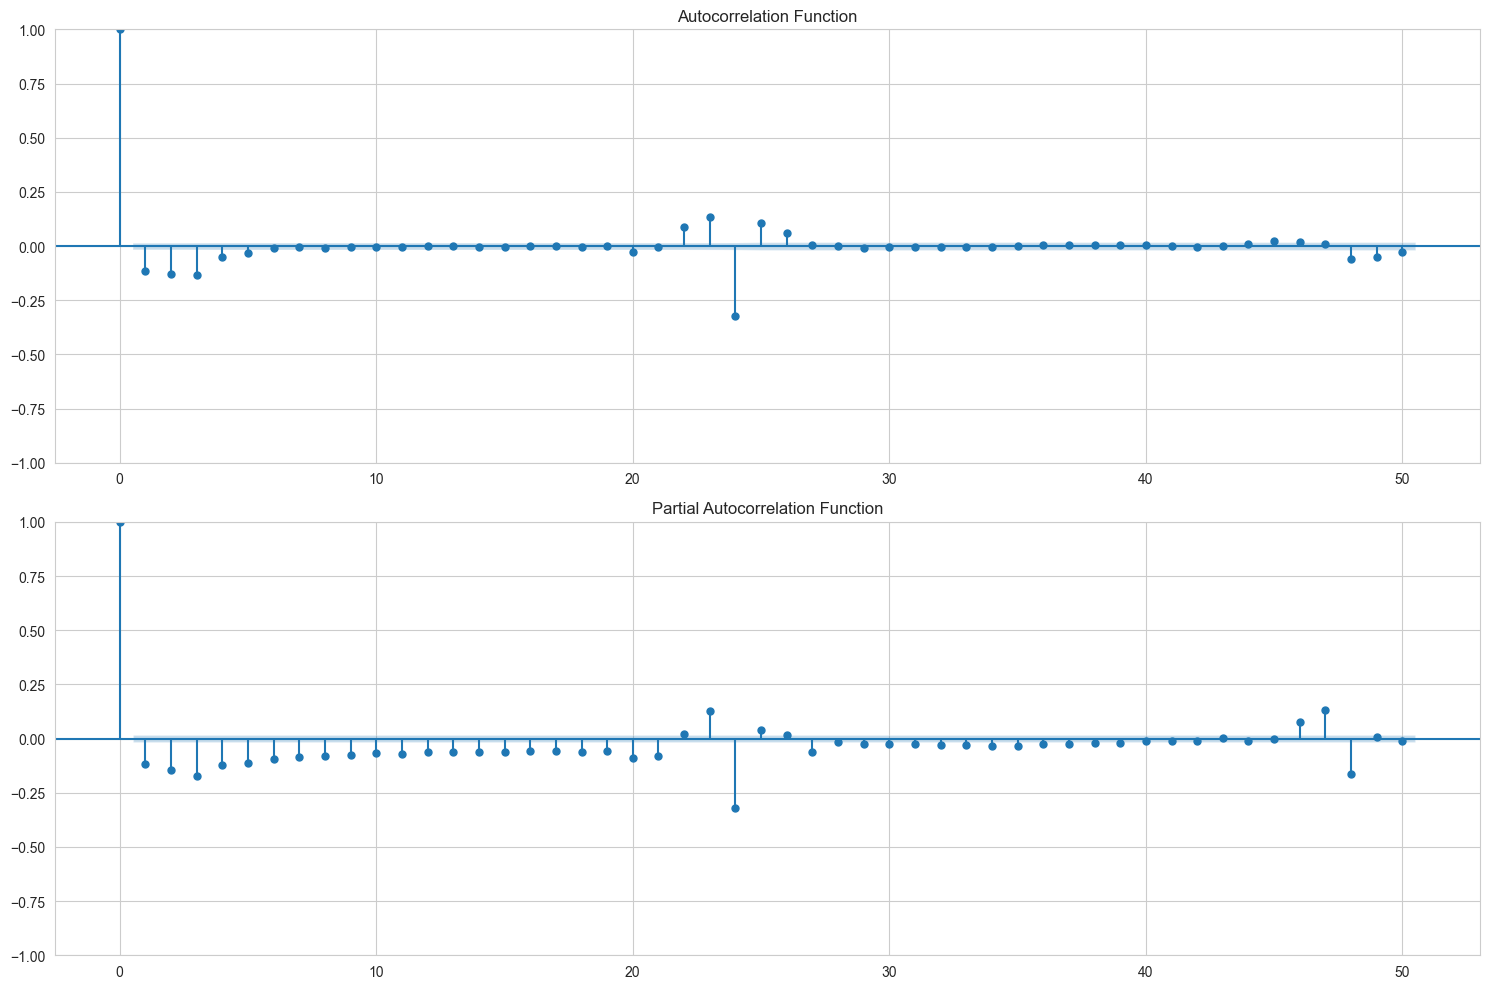


Statistics for Original Series:
Mean: 0.0463
Std: 0.0489
ADF Test p-value: 0.0000

Statistics for First Difference:
Mean: -0.0000
Std: 0.0313
ADF Test p-value: 0.0000

Statistics for Seasonal Difference:
Mean: 0.0000
Std: 0.0367
ADF Test p-value: 0.0000

Statistics for Both Differences:
Mean: 0.0000
Std: 0.0313
ADF Test p-value: 0.0000


In [10]:
# Cell 8 - ACF and PACF Analysis

# First, let's analyze the original series
print("=== ACF and PACF Analysis of Original Series ===")
plot_acf_pacf(df['X'], lags=50)

# Now let's look at first difference
print("\n=== ACF and PACF Analysis of First Difference ===")
diff1 = df['X'].diff().dropna()
plot_acf_pacf(diff1, lags=50)

# Let's also look at seasonal difference (24-hour seasonality)
print("\n=== ACF and PACF Analysis of Seasonal Difference (24 hours) ===")
seasonal_diff = df['X'].diff(24).dropna()
plot_acf_pacf(seasonal_diff, lags=50)

# And finally, both differences combined
print("\n=== ACF and PACF Analysis of First and Seasonal Differences Combined ===")
both_diff = seasonal_diff.diff().dropna()
plot_acf_pacf(both_diff, lags=50)

# Let's also show some statistics about each transformation
def print_series_stats(series, name):
    print(f"\nStatistics for {name}:")
    print(f"Mean: {series.mean():.4f}")
    print(f"Std: {series.std():.4f}")
    print(f"ADF Test p-value: {adfuller(series.dropna())[1]:.4f}")

print_series_stats(df['X'], "Original Series")
print_series_stats(diff1, "First Difference")
print_series_stats(seasonal_diff, "Seasonal Difference")
print_series_stats(both_diff, "Both Differences")

=== ACF and PACF Analysis of Original Series ===

Short-term patterns (2 days):


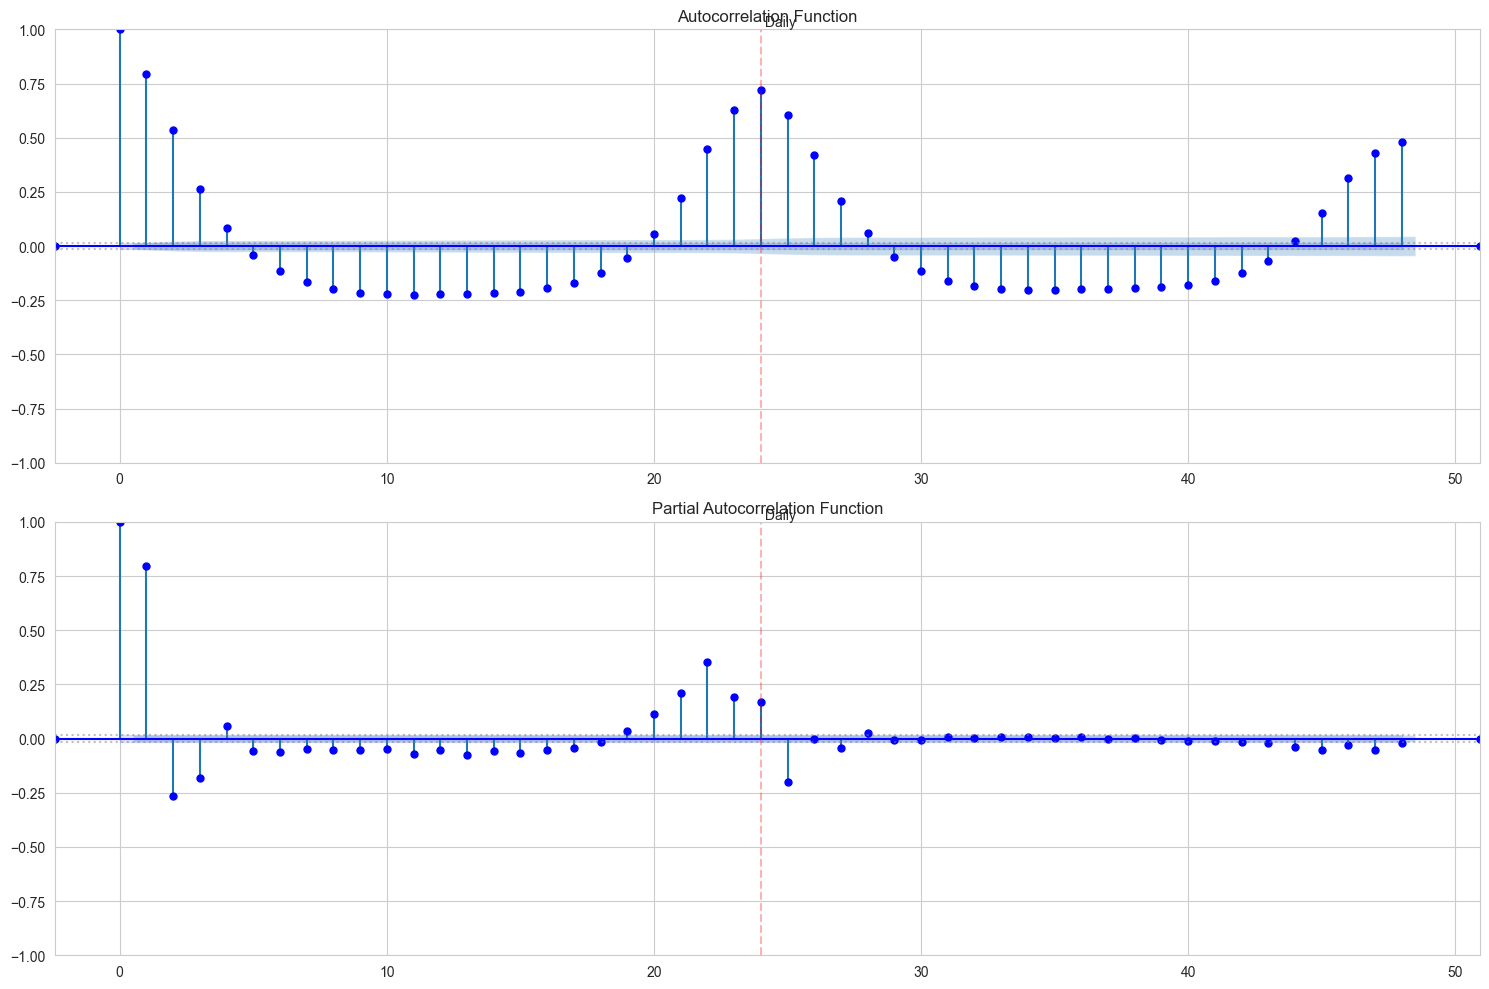


Medium-term patterns (2 weeks):


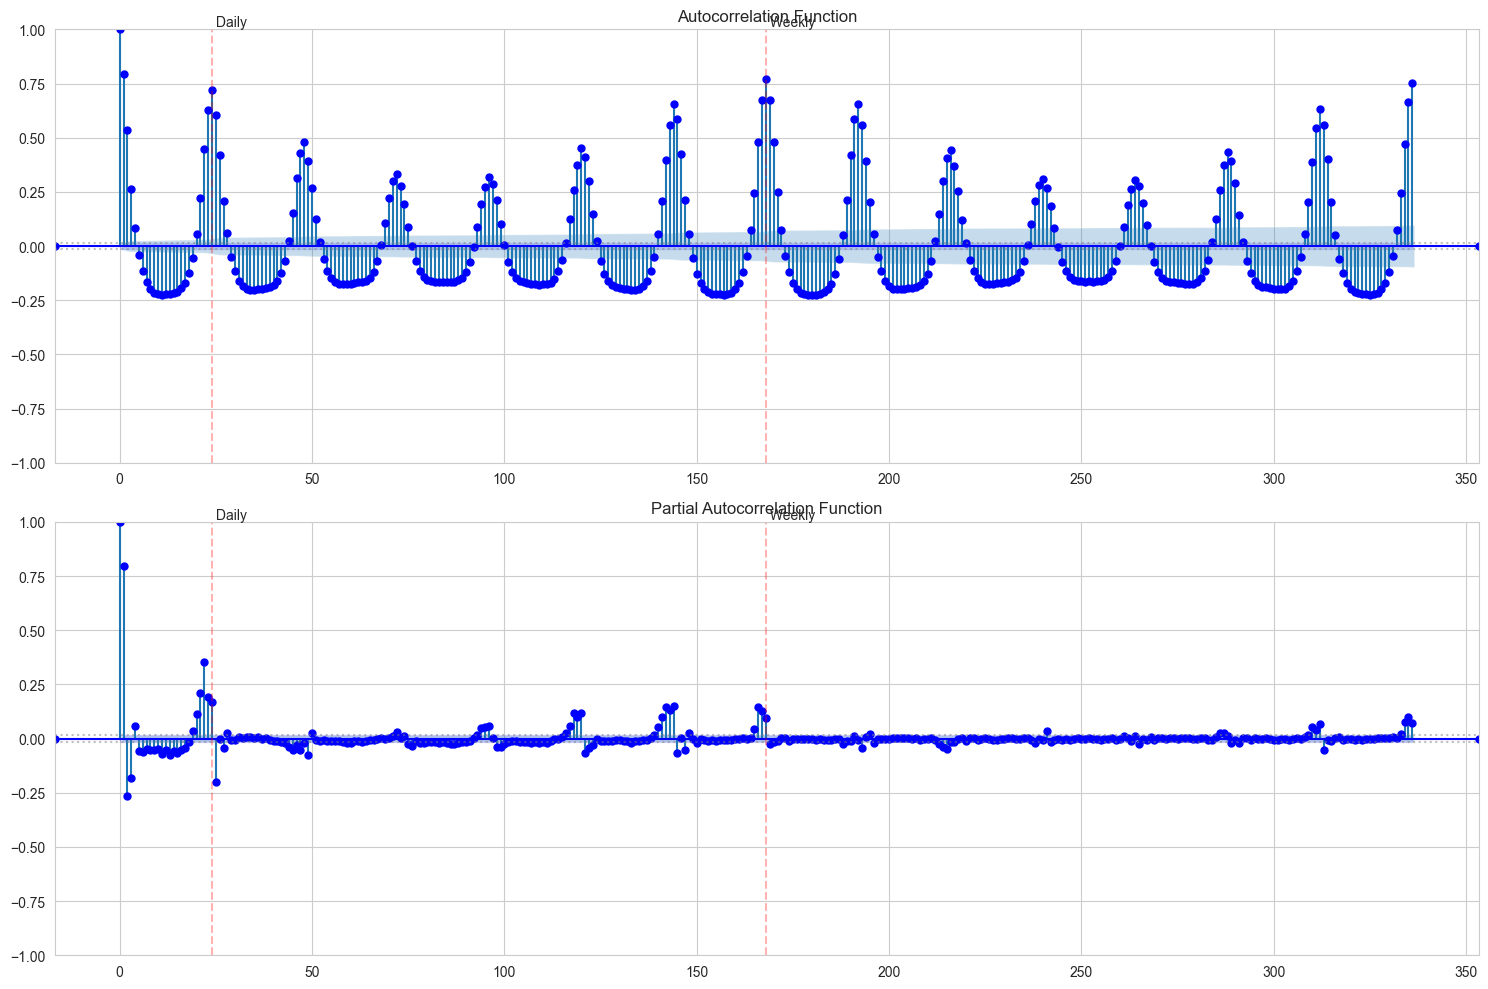


Long-term patterns (1 month):


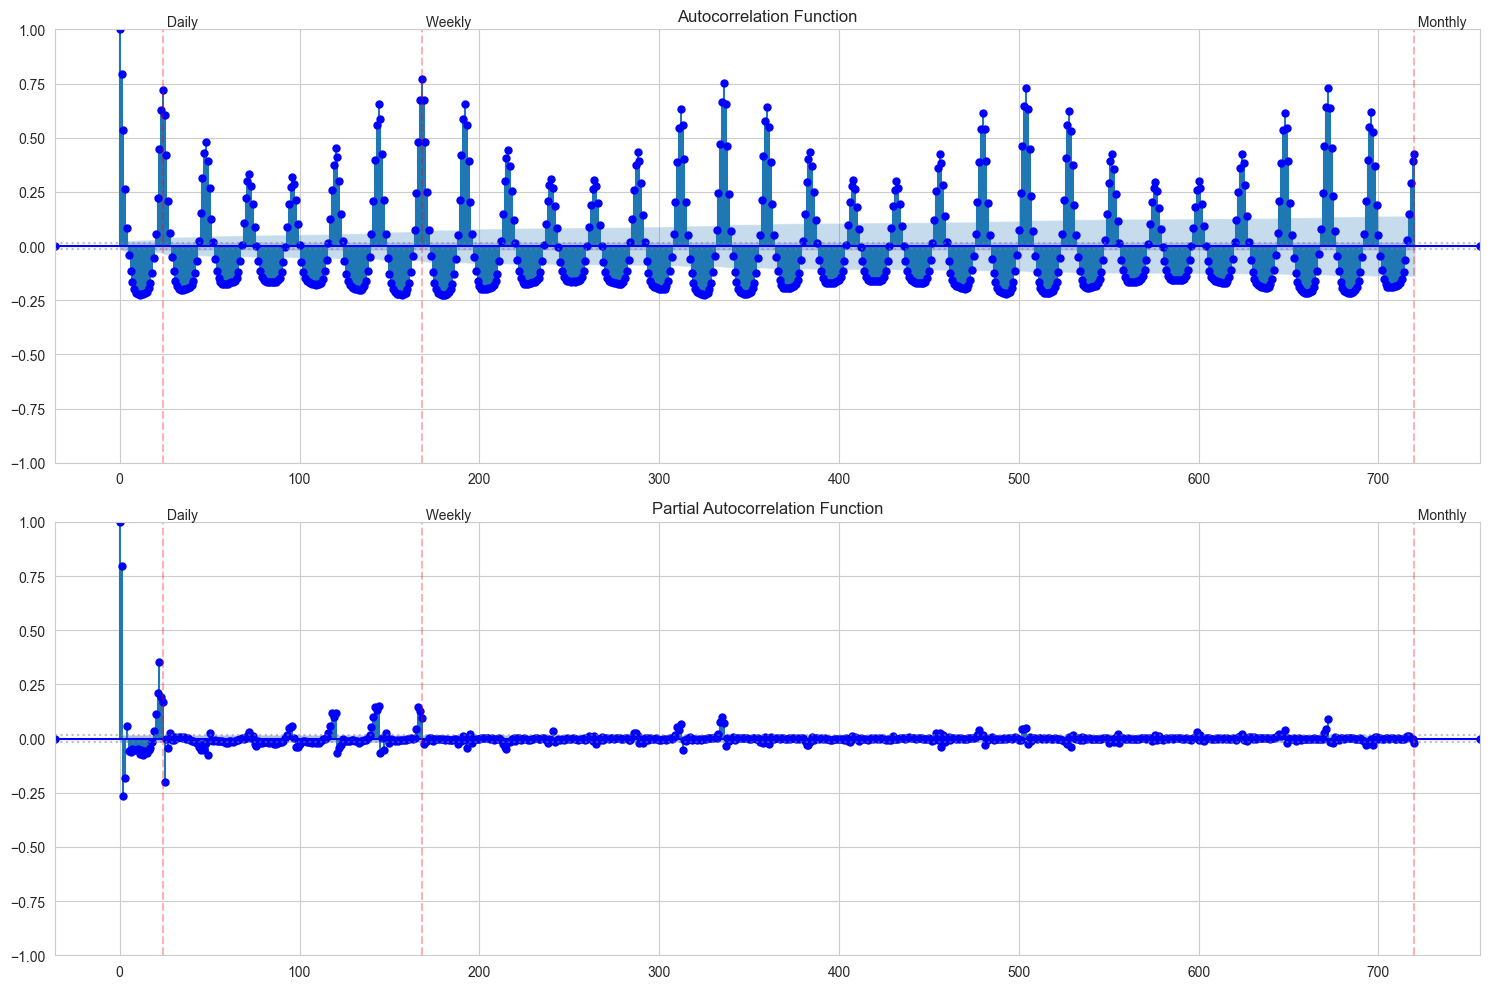


=== ACF and PACF Analysis of Differenced Series ===

First Difference:


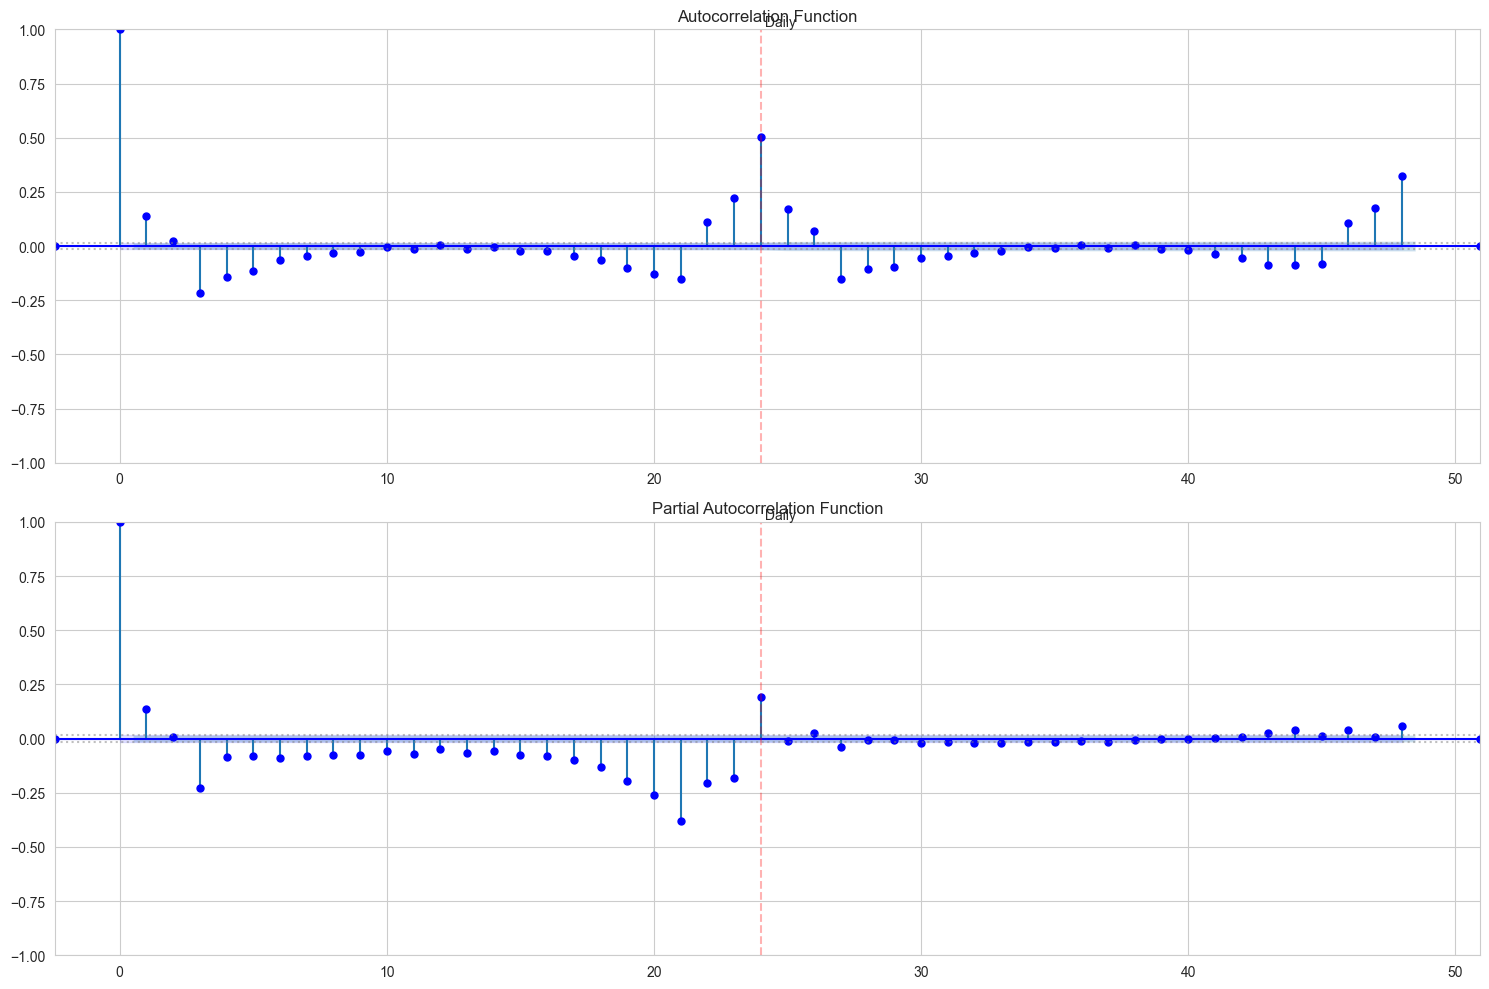


Seasonal Difference (24 hours):


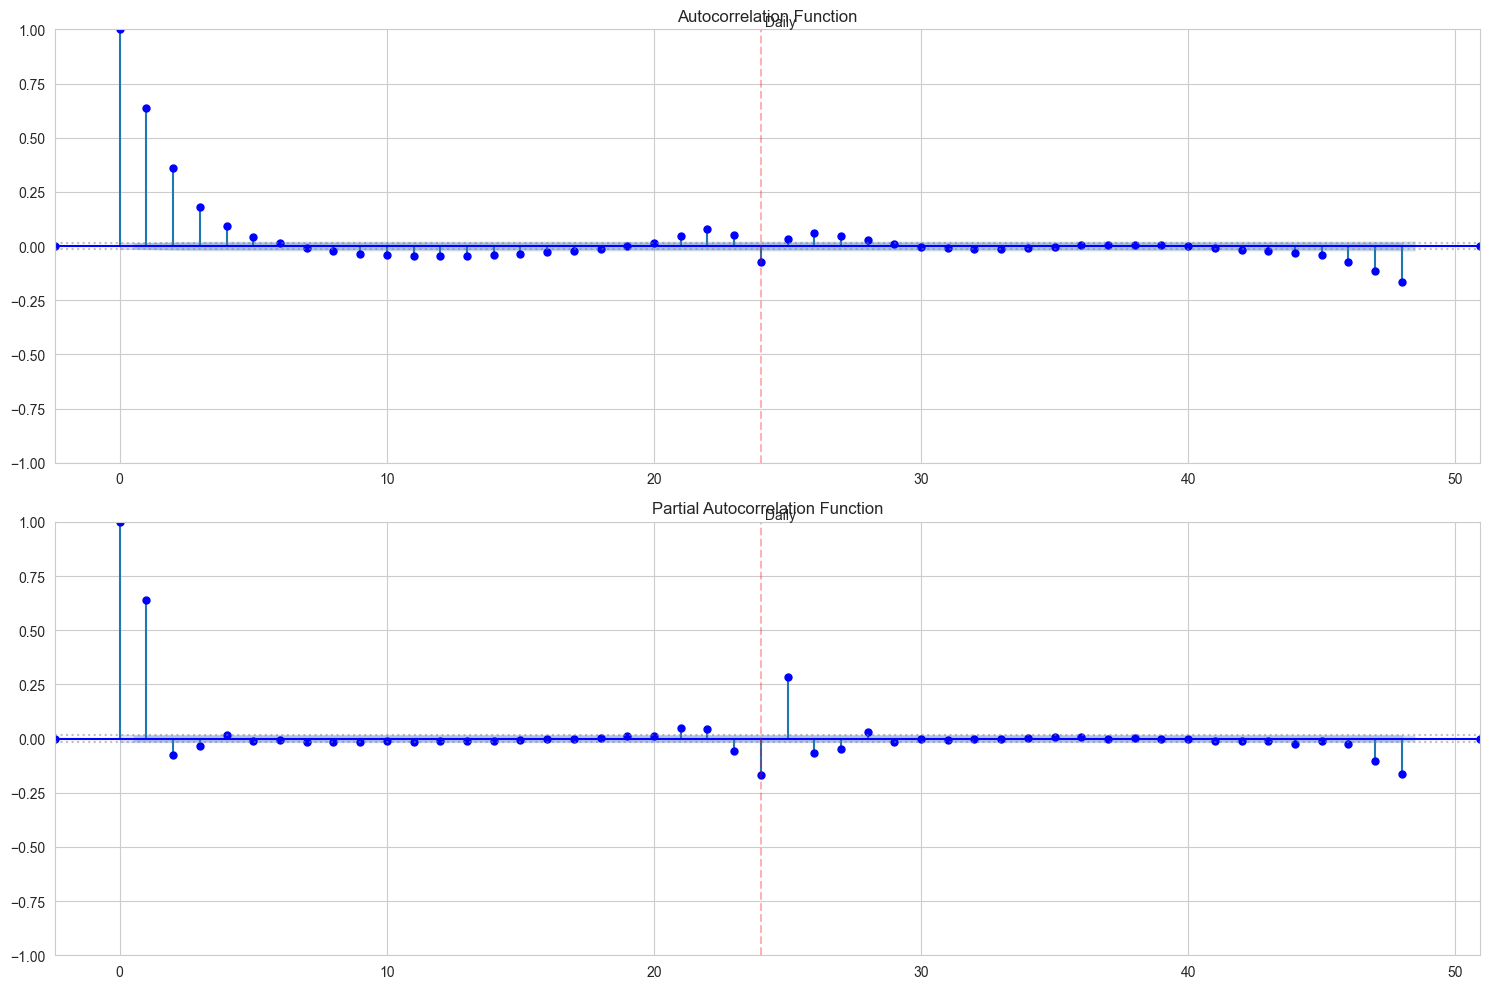


Both Differences Combined:


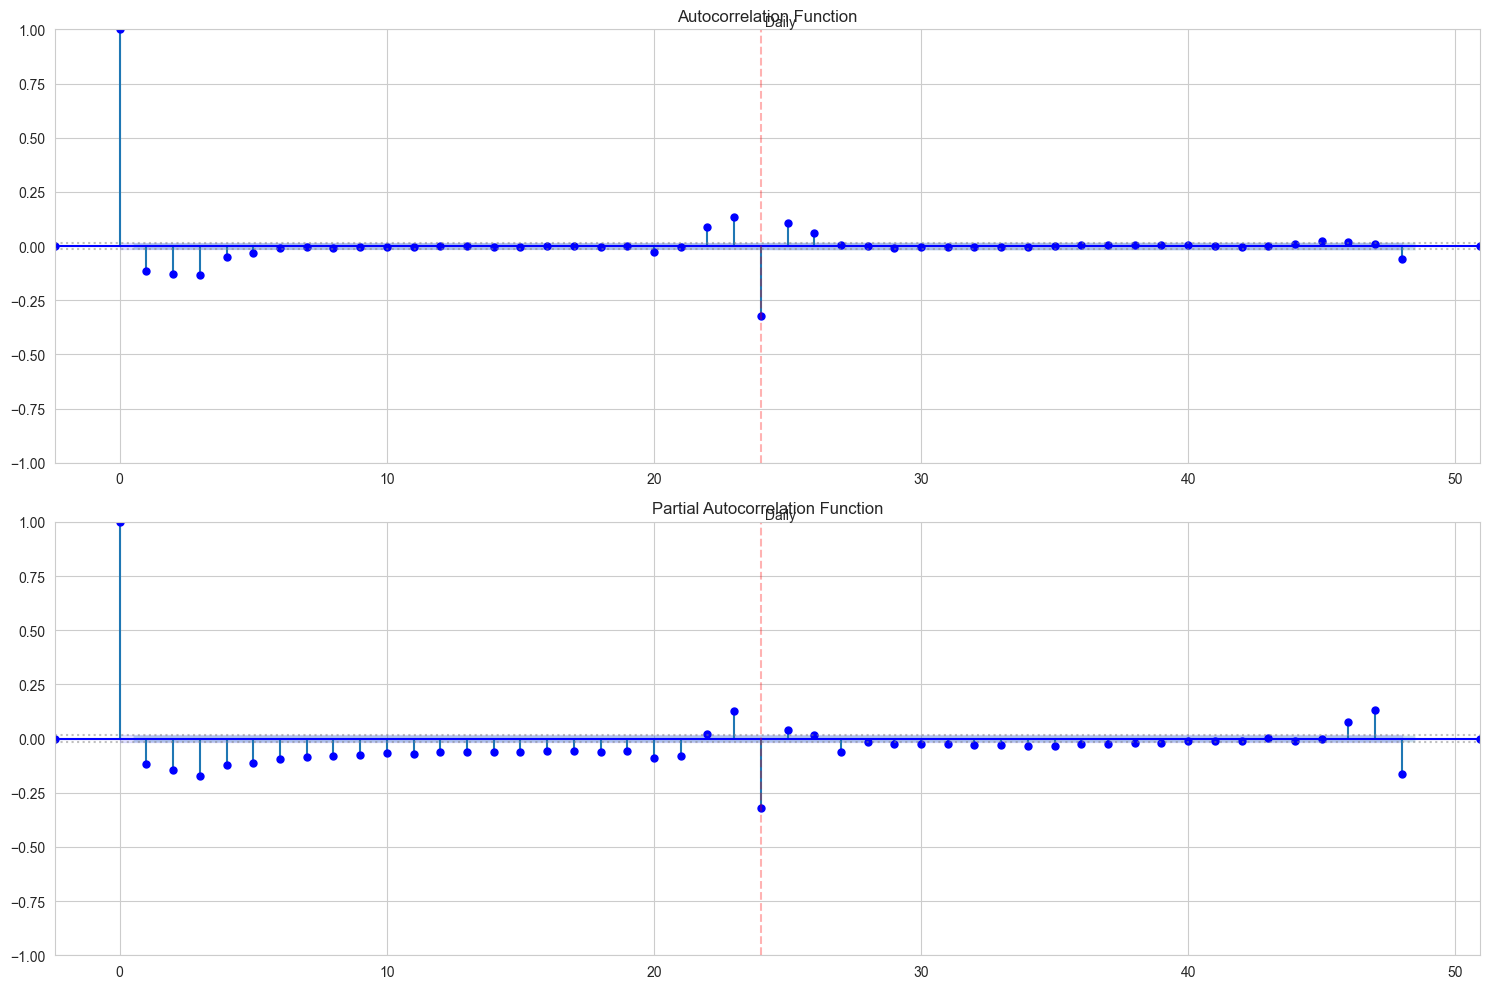

In [11]:
# Cell 9 - Updated ACF and PACF Analysis

def plot_advanced_acf_pacf(series, max_lags=None, periods=None):
    """
    Plot ACF and PACF with multiple lag ranges and highlighted seasonal periods
    
    Parameters:
    - series: time series data
    - max_lags: maximum number of lags to show
    - periods: list of tuples (period, label) to highlight
    """
    if max_lags is None:
        max_lags = 24 * 8  # Show 8 days by default
    
    if periods is None:
        periods = [
            (24, "Daily"),
            (24 * 7, "Weekly"),
            (24 * 30, "Monthly")
        ]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot ACF
    plot_acf(series.dropna(), lags=max_lags, ax=ax1, alpha=0.05, 
            markersize=5, c='blue', marker='o')
    ax1.set_title('Autocorrelation Function')
    
    # Plot PACF
    plot_pacf(series.dropna(), lags=max_lags, ax=ax2, alpha=0.05, 
             markersize=5, c='blue', marker='o')
    ax2.set_title('Partial Autocorrelation Function')
    
    # Add vertical lines for seasonal periods
    for period, label in periods:
        if period <= max_lags:
            for ax in [ax1, ax2]:
                ax.axvline(x=period, color='red', linestyle='--', alpha=0.3)
                ax.text(period, ax.get_ylim()[1], f' {label}', 
                       rotation=0, verticalalignment='bottom')
    
    # Enhance confidence intervals visibility
    for ax in [ax1, ax2]:
        # Get the confidence intervals (approximately at y = ±2/√T)
        ci = 2/np.sqrt(len(series))
        ax.axhline(y=ci, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(y=-ci, color='gray', linestyle=':', alpha=0.5)
        ax.fill_between(range(max_lags + 1), -ci, ci, color='blue', alpha=0.1)
    
    plt.tight_layout()
    plt.show()

# Plot for different ranges
print("=== ACF and PACF Analysis of Original Series ===")
print("\nShort-term patterns (2 days):")
plot_advanced_acf_pacf(df['X'], max_lags=48)

print("\nMedium-term patterns (2 weeks):")
plot_advanced_acf_pacf(df['X'], max_lags=24*14)

print("\nLong-term patterns (1 month):")
plot_advanced_acf_pacf(df['X'], max_lags=24*30)

# Also show the differenced series
print("\n=== ACF and PACF Analysis of Differenced Series ===")
diff1 = df['X'].diff().dropna()
seasonal_diff = df['X'].diff(24).dropna()
both_diff = seasonal_diff.diff().dropna()

print("\nFirst Difference:")
plot_advanced_acf_pacf(diff1, max_lags=48)

print("\nSeasonal Difference (24 hours):")
plot_advanced_acf_pacf(seasonal_diff, max_lags=48)

print("\nBoth Differences Combined:")
plot_advanced_acf_pacf(both_diff, max_lags=48)

# ARIMA Simple

In [12]:
# Cell 10 - Common Data Preparation
from tqdm import tqdm  # For progress bars

def prepare_data_for_modeling(df, forecast_horizon=744):
    """
    Prepare data for modeling (common across all models)
    """
    print("=== Data Preparation ===")

    # Remove the last forecast_horizon hours (target forecast period)
    train_data = df[df['X'].notna()].copy()

    # Create validation set (last month of available data)
    validation_size = forecast_horizon
    train_set = train_data[:-validation_size]
    val_set = train_data[-validation_size:]

    print("\nData Split Summary:")
    print(f"Training set: {train_set.index.min()} to {train_set.index.max()}")
    print(f"Validation set: {val_set.index.min()} to {val_set.index.max()}")
    print(f"Forecast period: {val_set.index.max() + pd.Timedelta(hours=1)} to {df.index.max()}")

    return train_set, val_set

# Prepare the data
train_set, val_set = prepare_data_for_modeling(df)

=== Data Preparation ===

Data Split Summary:
Training set: 2015-01-01 00:00:00 to 2016-10-30 23:00:00
Validation set: 2016-10-31 00:00:00 to 2016-11-30 23:00:00
Forecast period: 2016-12-01 00:00:00 to 2016-12-31 23:00:00


In [13]:
# Cell 11 - ARIMA Model Development and Training
def develop_arima_model(train_data):
    """
    Develop ARIMA model based on theoretical analysis
    """
    print("=== ARIMA Model Development ===")

    # Convert to pandas Series with frequency and handle any preprocessing
    y = train_data['X'].astype(float)
    y.index = pd.date_range(start=y.index[0], periods=len(y), freq='H')
    
    # Define more conservative models
    models_to_try = [
        ((1,1,1), (0,1,1,24)),    # Simple model with seasonal MA only
        ((1,1,1), (1,1,0,24)),    # Simple model with seasonal AR only
        ((2,1,2), (1,1,1,24)),    # More complex model
        ((0,1,1), (0,1,1,24))     # Airline model (often works well)
    ]

    best_aic = float('inf')
    best_model = None
    best_order = None
    best_seasonal_order = None

    print("\nTrying specific model configurations...")
    for order, seasonal_order in tqdm(models_to_try, desc="Testing Models"):
        try:
            print(f"\nFitting ARIMA{order}{seasonal_order}")
            
            # Add start_params to help convergence
            model = ARIMA(y,
                         order=order,
                         seasonal_order=seasonal_order,
                         enforce_stationarity=False,
                         enforce_invertibility=True)  # Changed to True

            # Use conditional sum of squares to start
            results = model.fit(method='innovations_mle')
            current_aic = results.aic
            
            print(f"AIC: {current_aic:.2f}")
            
            # Check if the model is reasonable (non-flat forecast)
            test_forecast = results.forecast(steps=24)
            forecast_std = test_forecast.std()
            
            # Only consider model if forecasts show variation
            if forecast_std > 0.001 and current_aic < best_aic:
                best_aic = current_aic
                best_model = results
                best_order = order
                best_seasonal_order = seasonal_order

        except Exception as e:
            print(f"Error fitting ARIMA{order}{seasonal_order}:")
            print(f"Error message: {str(e)}")
            continue

    if best_model is None:
        raise ValueError("No models were successfully fitted!")

    print("\nBest Model Configuration:")
    print(f"Order: {best_order}")
    print(f"Seasonal Order: {best_seasonal_order}")
    print(f"AIC: {best_aic}")
    print("\nModel Summary:")
    print(best_model.summary())

    return best_model, best_order, best_seasonal_order

In [14]:
# Cell 12 - ARIMA Model Diagnostics
def perform_arima_diagnostics(model):
    """
    Perform diagnostic tests for ARIMA model
    """
    print("=== ARIMA Model Diagnostics ===")

    residuals = model.resid
    
    # Create diagnostic plots
    fig = plt.figure(figsize=(15, 15))

    # 1. Residuals over time
    ax1 = plt.subplot(411)
    plt.plot(residuals.index, residuals, 'b.', alpha=0.5, markersize=2)
    plt.plot(residuals.index, pd.Series(0, index=residuals.index), 'r--')
    plt.title('Residuals over Time')
    plt.grid(True, alpha=0.2)

    # 2. ACF of residuals
    ax2 = plt.subplot(412)
    plot_acf(residuals, lags=50, ax=ax2, alpha=0.05,
             title="ACF of Residuals",
             markersize=3)
    plt.grid(True, alpha=0.2)

    # 3. PACF of residuals
    ax3 = plt.subplot(413)
    plot_pacf(residuals, lags=50, ax=ax3, alpha=0.05,
              title="PACF of Residuals",
              markersize=3)
    plt.grid(True, alpha=0.2)

    # 4. Q-Q plot
    ax4 = plt.subplot(414)
    stats.probplot(residuals, dist="norm", plot=plt)
    ax4.set_title("Q-Q plot of residuals")
    plt.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nResidual Statistics:")
    print(f"Mean: {residuals.mean():.4f}")
    print(f"Std Dev: {residuals.std():.4f}")
    print(f"Skewness: {stats.skew(residuals):.4f}")
    print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")

In [15]:
# Cell 13 - ARIMA Forecasting (with non-negative constraints)
def generate_arima_forecasts(model, train_data, val_data, forecast_horizon=744):
    """
    Generate and evaluate ARIMA forecasts with non-negative constraints
    """
    print("=== ARIMA Forecasting ===")

    # In-sample predictions
    in_sample_pred = model.get_prediction(start=0)
    in_sample_mean = np.maximum(in_sample_pred.predicted_mean, 0)  # Force non-negative

    # Validation set predictions
    val_pred = model.get_prediction(
        start=len(train_data), 
        end=len(train_data)+len(val_data)-1,
        dynamic=False
    )
    val_mean = np.maximum(val_pred.predicted_mean, 0)  # Force non-negative
    val_conf = val_pred.conf_int()
    val_conf.iloc[:, 0] = np.maximum(val_conf.iloc[:, 0], 0)  # Force non-negative lower bound

    # Future forecasts
    forecast = model.get_forecast(
        steps=forecast_horizon,
        alpha=0.05
    )
    forecast_mean = np.maximum(forecast.predicted_mean, 0)  # Force non-negative
    forecast_conf = forecast.conf_int()
    forecast_conf.iloc[:, 0] = np.maximum(forecast_conf.iloc[:, 0], 0)  # Force non-negative lower bound

    # Plot results
    plt.figure(figsize=(15, 10))

    # Plot training data
    plt.plot(train_data.index, train_data['X'], label='Training Data', alpha=0.7)

    # Plot validation data
    plt.plot(val_data.index, val_data['X'], label='Validation Data', color='green', alpha=0.7)

    # Plot validation predictions
    plt.plot(val_data.index, val_mean, label='Validation Predictions', color='red', linestyle='--')
    plt.fill_between(val_data.index,
                     val_conf.iloc[:, 0],
                     val_conf.iloc[:, 1],
                     color='red', alpha=0.1)

    # Plot forecasts
    forecast_index = pd.date_range(start=val_data.index[-1] + pd.Timedelta(hours=1),
                                 periods=forecast_horizon,
                                 freq='H')
    plt.plot(forecast_index, forecast_mean, label='ARIMA Forecasts', color='blue')
    plt.fill_between(forecast_index,
                     forecast_conf.iloc[:, 0],
                     forecast_conf.iloc[:, 1],
                     color='blue', alpha=0.1)

    plt.title('ARIMA Model Forecasts')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calculate error metrics (using non-negative predictions)
    val_rmse = np.sqrt(mean_squared_error(val_data['X'], val_mean))
    val_mae = mean_absolute_error(val_data['X'], val_mean)
    val_mape = np.mean(np.abs((val_data['X'] - val_mean) / val_data['X'])) * 100

    print("\nValidation Set Metrics:")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"MAE: {val_mae:.4f}")
    print(f"MAPE: {val_mape:.4f}%")

    return forecast_mean, forecast_conf, val_mean, val_conf

Starting ARIMA modeling pipeline...
=== ARIMA Model Development ===

Trying specific model configurations...


Testing Models:   0%|          | 0/4 [00:00<?, ?it/s]


Fitting ARIMA(1, 1, 1)(0, 1, 1, 24)


Testing Models:  25%|██▌       | 1/4 [00:11<00:35, 11.98s/it]

AIC: -73516.91

Fitting ARIMA(1, 1, 1)(1, 1, 0, 24)


Testing Models:  50%|█████     | 2/4 [00:15<00:14,  7.28s/it]

AIC: -69838.60

Fitting ARIMA(2, 1, 2)(1, 1, 1, 24)
AIC: -75161.10


Testing Models:  75%|███████▌  | 3/4 [00:55<00:21, 21.86s/it]


Fitting ARIMA(0, 1, 1)(0, 1, 1, 24)


Testing Models: 100%|██████████| 4/4 [01:00<00:00, 15.08s/it]

AIC: -71106.10

Best Model Configuration:
Order: (2, 1, 2)
Seasonal Order: (1, 1, 1, 24)
AIC: -75161.10112524132

Model Summary:


                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16056
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               37587.551
Date:                            Sat, 11 Jan 2025   AIC                         -75161.101
Time:                                    11:02:04   BIC                         -75107.337
Sample:                                01-01-2015   HQIC                        -75143.319
                                     - 10-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0280      0.055     18.858      0.000       0.921       1.135
ar.L2         -0.2997      0.038   

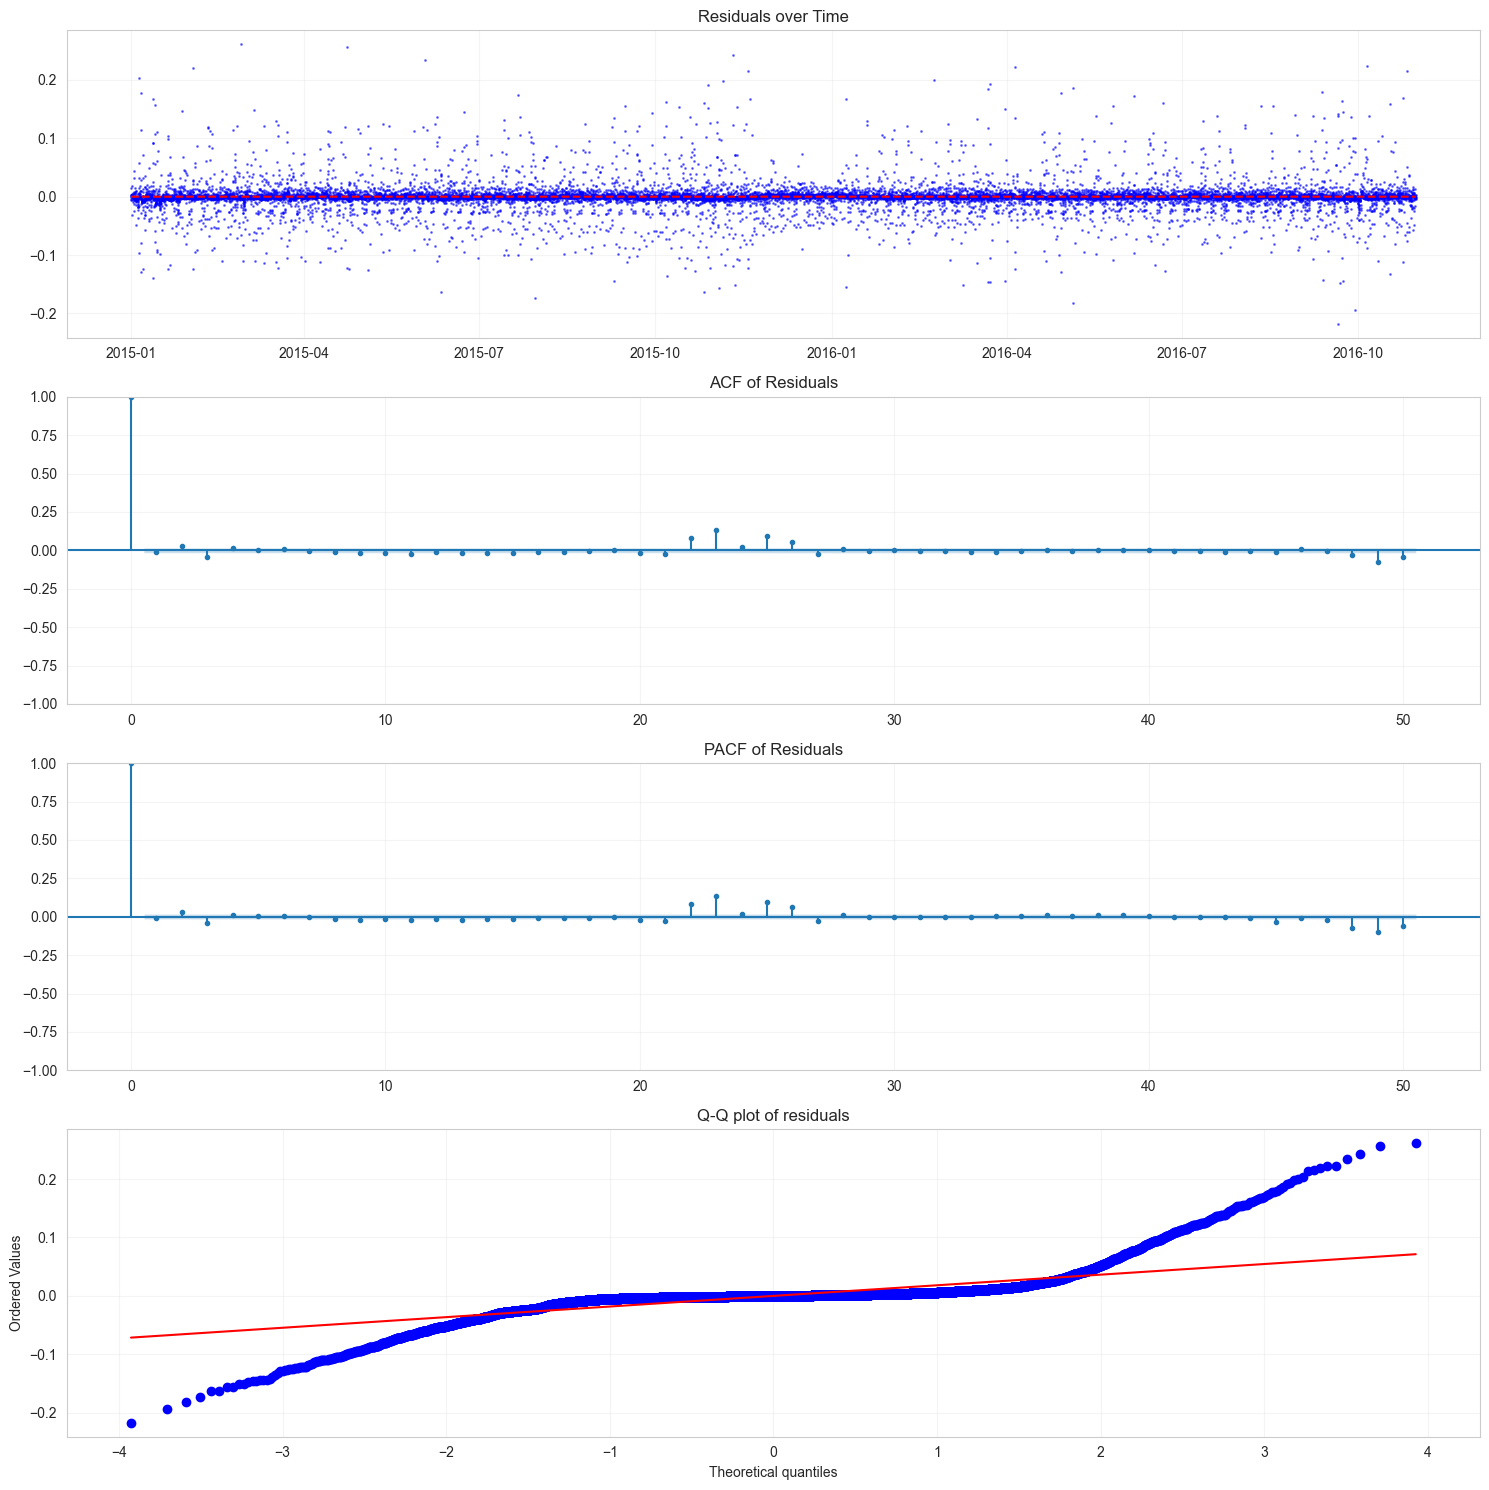


Residual Statistics:
Mean: -0.0001
Std Dev: 0.0231
Skewness: 1.2972
Kurtosis: 22.1946
=== ARIMA Forecasting ===


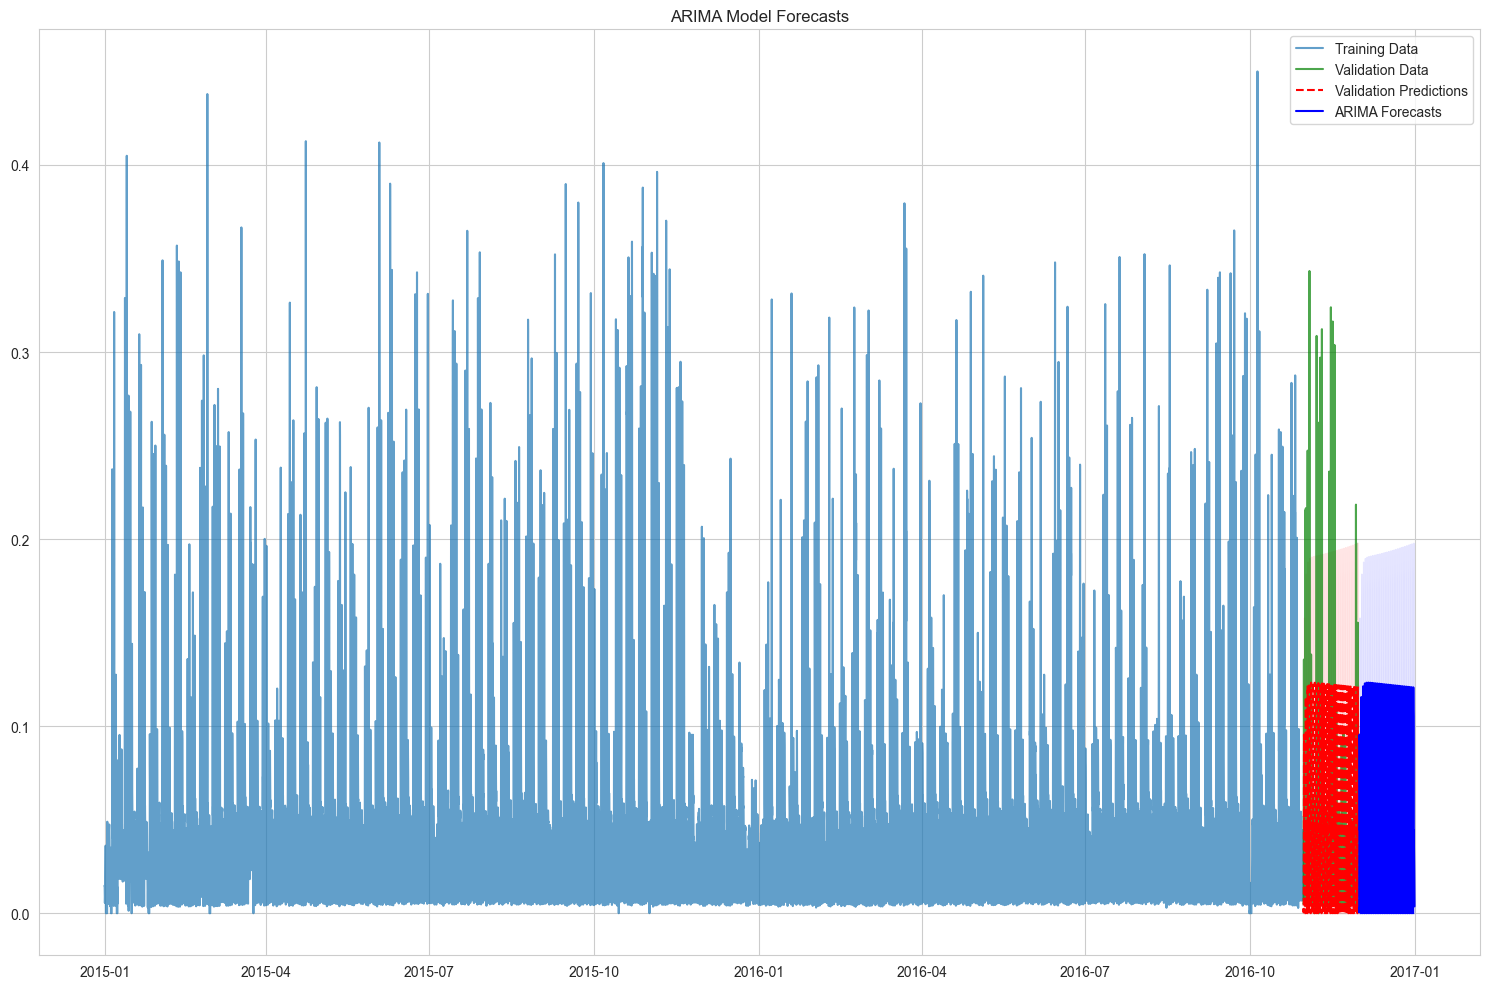


Validation Set Metrics:
RMSE: 0.0394
MAE: 0.0199
MAPE: inf%

ARIMA modeling pipeline completed!

Forecasts have been saved to 'arima_forecasts.csv'


In [16]:
# Cell 14 - Run ARIMA Pipeline
print("Starting ARIMA modeling pipeline...")

try:
    # First develop and train the model
    arima_model, best_order, best_seasonal_order = develop_arima_model(train_set)

    # Perform diagnostics
    perform_arima_diagnostics(arima_model)

    # Generate forecasts
    forecast_mean, forecast_conf, val_mean, val_conf = generate_arima_forecasts(arima_model, train_set, val_set)

    # Save forecasts to CSV
    forecast_df = pd.DataFrame({
        'datetime': pd.date_range(start=val_set.index[-1] + pd.Timedelta(hours=1),
                                periods=744,
                                freq='H'),
        'ARIMA_forecast': forecast_mean,
        'ARIMA_lower': forecast_conf.iloc[:, 0],
        'ARIMA_upper': forecast_conf.iloc[:, 1]
    })
    forecast_df.set_index('datetime', inplace=True)
    forecast_df.to_csv('arima_forecasts.csv')
    
    print("\nARIMA modeling pipeline completed!")
    print("\nForecasts have been saved to 'arima_forecasts.csv'")

except Exception as e:
    print(f"Error in ARIMA pipeline: {str(e)}")
    raise

Found existing forecasts, creating plot...


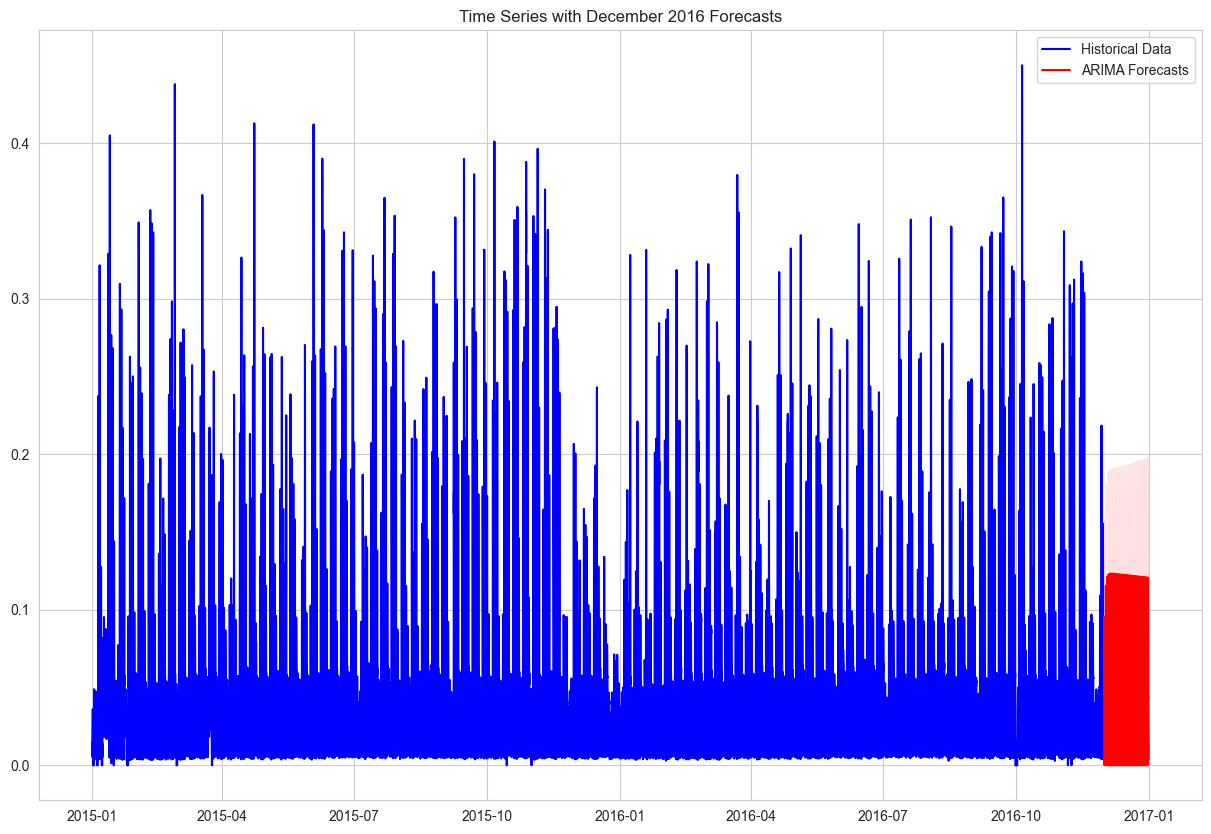

In [17]:
# Cell 15 - Create plot combining original data and forecasts

import os

def plot_with_forecasts(df, forecast_csv):
    """
    Plot original time series with forecasts appended
    """
    # Read the forecasts
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Create plot
    plt.figure(figsize=(15, 10))
    
    # Plot original data until November 2016
    plt.plot(df.index, df['X'], label='Historical Data', color='blue')
    
    # Add forecasts as continuation
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'], 
             label='ARIMA Forecasts', color='red')
    
    # Add confidence intervals
    plt.fill_between(forecasts['datetime'],
                     forecasts['ARIMA_lower'],
                     forecasts['ARIMA_upper'],
                     color='red', alpha=0.1)
    
    plt.title('Time Series with December 2016 Forecasts')
    plt.legend()
    plt.grid(True)
    plt.show()

# First check if we have the forecasts CSV
if os.path.exists('arima_forecasts.csv'):
    print("Found existing forecasts, creating plot...")
    plot_with_forecasts(df, 'arima_forecasts.csv')
else:
    print("No forecast file found. Please run the ARIMA model first.")

Plotting forecasts...

Forecast Statistics:
Mean: 0.0382
Std Dev: 0.0336
Min: 0.0000
Max: 0.1233


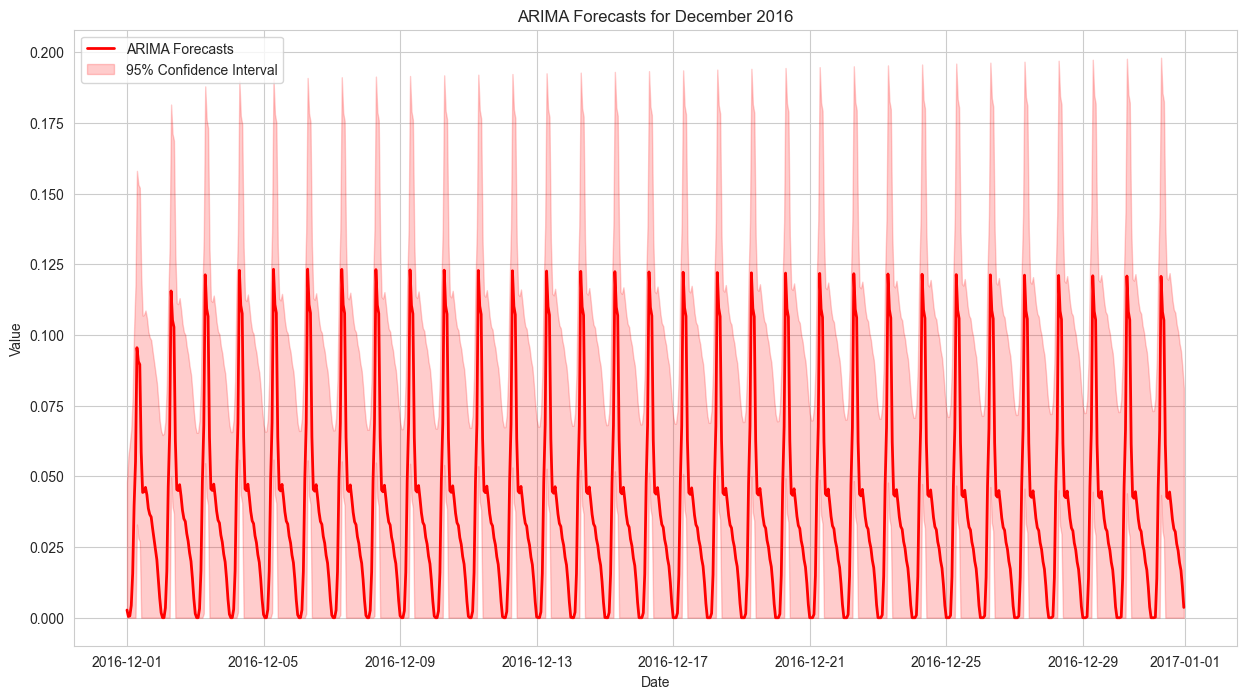

In [18]:
# Cell 16 - Plot just the forecasted values
def plot_forecasts_only(forecast_csv):
    """
    Plot only the forecasted values for December 2016
    """
    # Read the forecasts
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Create plot
    plt.figure(figsize=(15, 8))
    
    # Plot forecasts
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'],
             label='ARIMA Forecasts', color='red', linewidth=2)
    
    # Add confidence intervals
    plt.fill_between(forecasts['datetime'],
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='red', alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('ARIMA Forecasts for December 2016')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print some statistics about the forecasts
    print("\nForecast Statistics:")
    print(f"Mean: {forecasts['ARIMA_forecast'].mean():.4f}")
    print(f"Std Dev: {forecasts['ARIMA_forecast'].std():.4f}")
    print(f"Min: {forecasts['ARIMA_forecast'].min():.4f}")
    print(f"Max: {forecasts['ARIMA_forecast'].max():.4f}")
    
    plt.show()

if os.path.exists('arima_forecasts.csv'):
    print("Plotting forecasts...")
    plot_forecasts_only('arima_forecasts.csv')
else:
    print("No forecast file found. Please run the ARIMA model first.")

Plotting November comparison...

November Statistics:
Mean: 0.0463
Std Dev: 0.0537
Min: 0.0000
Max: 0.3433

December Forecast Statistics:
Mean: 0.0382
Std Dev: 0.0336
Min: 0.0000
Max: 0.1233


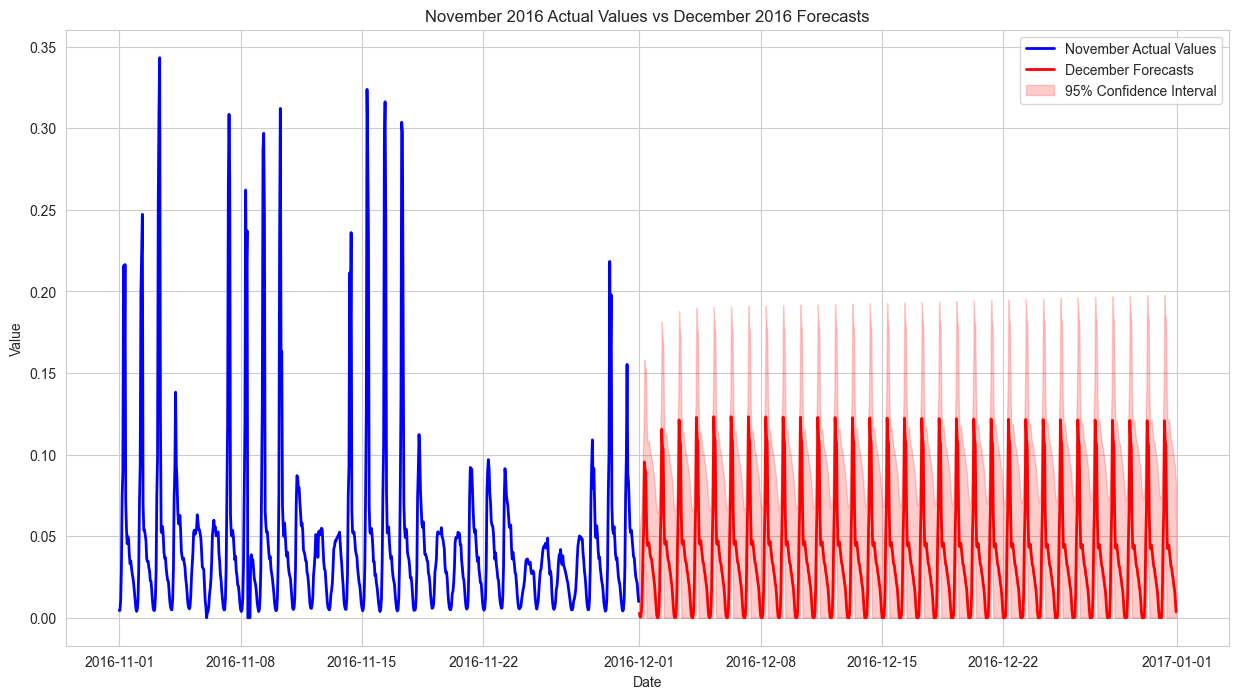

In [19]:
# Cell 17 - Plot November actuals and December forecasts
def plot_nov_dec_comparison(df, forecast_csv):
    """
    Plot November 2016 actual values and December 2016 forecasts
    """
    # Read the forecasts
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Get November data (last month before forecasts)
    november_start = '2016-11-01'
    november_end = '2016-11-30 23:00:00'
    november_data = df.loc[november_start:november_end]
    
    # Create plot
    plt.figure(figsize=(15, 8))
    
    # Plot November actual values
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values', color='blue', linewidth=2)
    
    # Plot December forecasts
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'],
             label='December Forecasts', color='red', linewidth=2)
    
    # Add confidence intervals for forecasts
    plt.fill_between(forecasts['datetime'],
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='red', alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('November 2016 Actual Values vs December 2016 Forecasts')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print statistics for comparison
    print("\nNovember Statistics:")
    print(f"Mean: {november_data['X'].mean():.4f}")
    print(f"Std Dev: {november_data['X'].std():.4f}")
    print(f"Min: {november_data['X'].min():.4f}")
    print(f"Max: {november_data['X'].max():.4f}")
    
    print("\nDecember Forecast Statistics:")
    print(f"Mean: {forecasts['ARIMA_forecast'].mean():.4f}")
    print(f"Std Dev: {forecasts['ARIMA_forecast'].std():.4f}")
    print(f"Min: {forecasts['ARIMA_forecast'].min():.4f}")
    print(f"Max: {forecasts['ARIMA_forecast'].max():.4f}")
    
    plt.show()

if os.path.exists('arima_forecasts.csv'):
    print("Plotting November comparison...")
    plot_nov_dec_comparison(df, 'arima_forecasts.csv')
else:
    print("No forecast file found. Please run the ARIMA model first.")

Plotting complete comparison...

Forecast columns: ['datetime', 'ARIMA_forecast', 'ARIMA_lower', 'ARIMA_upper']

Solution columns: ['DateTime', 'Date', 'Hour', 'X']

November Statistics:
Mean: 0.0463
Std Dev: 0.0537
Min: 0.0000
Max: 0.3433

December Forecast Statistics:
Mean: 0.0382
Std Dev: 0.0336
Min: 0.0000
Max: 0.1233

December Real Values Statistics:
Mean: 0.0392
Std Dev: 0.0331
Min: 0.0000
Max: 0.2537

Forecast Error Metrics:
MAE: 0.0155
RMSE: 0.0263
MAPE: nan%


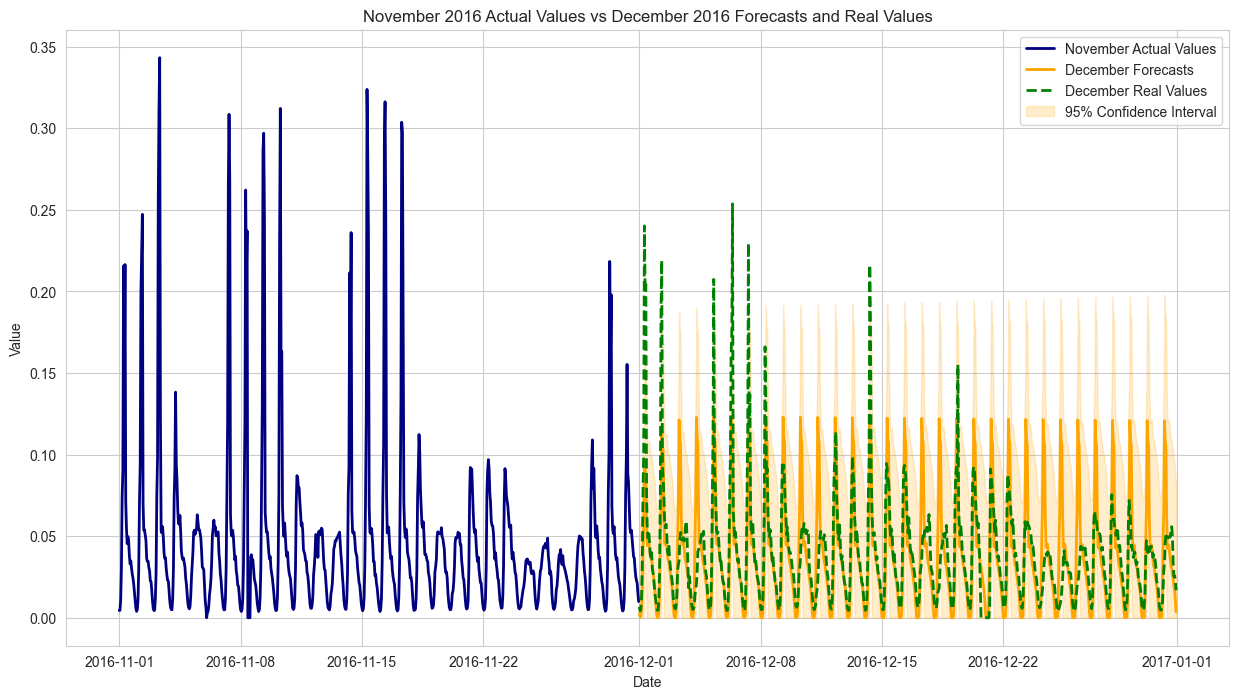

In [20]:
# Cell 18 - Plot November actuals, December forecasts, and December real values
def plot_complete_comparison(df, forecast_csv, solution_path):
    """
    Plot November 2016 actual values, December 2016 forecasts, and December 2016 real values
    Colors chosen for colorblind visibility:
    - November actuals: Dark Blue
    - December forecasts: Orange
    - December real values: Green
    - Confidence intervals: Light Orange shading
    """
    # Read the forecasts and solution with debug prints
    forecasts = pd.read_csv(forecast_csv)
    print("\nForecast columns:", forecasts.columns.tolist())
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Read and inspect solution file
    solution = pd.read_csv(solution_path)
    print("\nSolution columns:", solution.columns.tolist())
    
    # Create datetime index for solution based on December 2016
    solution.index = pd.date_range(start='2016-12-01', 
                                 periods=len(solution), 
                                 freq='H')
    
    # Get November data
    november_start = '2016-11-01'
    november_end = '2016-11-30 23:00:00'
    november_data = df.loc[november_start:november_end]
    
    # Create plot
    plt.figure(figsize=(15, 8))
    
    # Plot November actual values (Dark Blue)
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values', 
             color='#000080',  # Dark Blue
             linewidth=2)
    
    # Plot December forecasts (Orange)
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'],
             label='December Forecasts', 
             color='#FFA500',  # Orange
             linewidth=2)
    
    # Plot December real values (Green) - assuming 'X' is the column name in solution
    plt.plot(solution.index, solution['X'],
             label='December Real Values', 
             color='#008000',  # Green
             linewidth=2,
             linestyle='--')
    
    # Add confidence intervals for forecasts (Light Orange shading)
    plt.fill_between(forecasts['datetime'],
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='#FFA500',  # Orange
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('November 2016 Actual Values vs December 2016 Forecasts and Real Values')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print statistics for comparison
    print("\nNovember Statistics:")
    print(f"Mean: {november_data['X'].mean():.4f}")
    print(f"Std Dev: {november_data['X'].std():.4f}")
    print(f"Min: {november_data['X'].min():.4f}")
    print(f"Max: {november_data['X'].max():.4f}")
    
    print("\nDecember Forecast Statistics:")
    print(f"Mean: {forecasts['ARIMA_forecast'].mean():.4f}")
    print(f"Std Dev: {forecasts['ARIMA_forecast'].std():.4f}")
    print(f"Min: {forecasts['ARIMA_forecast'].min():.4f}")
    print(f"Max: {forecasts['ARIMA_forecast'].max():.4f}")
    
    print("\nDecember Real Values Statistics:")
    print(f"Mean: {solution['X'].mean():.4f}")
    print(f"Std Dev: {solution['X'].std():.4f}")
    print(f"Min: {solution['X'].min():.4f}")
    print(f"Max: {solution['X'].max():.4f}")
    
    # Calculate and print error metrics between forecasts and real values
    print("\nForecast Error Metrics:")
    mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
    mape = np.mean(np.abs((solution['X'] - forecasts['ARIMA_forecast']) / solution['X'])) * 100
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    
    plt.show()

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if os.path.exists('arima_forecasts.csv') and os.path.exists(solution_path):
    print("Plotting complete comparison...")
    plot_complete_comparison(df, 'arima_forecasts.csv', solution_path)
else:
    print("Missing required files. Please check both forecast and solution files exist.")

## ARIMA Advanced - SARIMAX with Christmas

In [21]:
# Cell 19 - More Efficient Seasonal Features
def create_efficient_features(dates):
    """
    Create efficient features for both daily and weekly patterns
    """
    features = pd.DataFrame(index=dates)
    
    # Hour of day (0-23) as cyclical features
    hours = 24
    features['hour_sin'] = np.sin(2 * np.pi * dates.hour / hours)
    features['hour_cos'] = np.cos(2 * np.pi * dates.hour / hours)
    
    # Day of week (0-6) as cyclical features
    days = 7
    features['day_sin'] = np.sin(2 * np.pi * dates.dayofweek / days)
    features['day_cos'] = np.cos(2 * np.pi * dates.dayofweek / days)
    
    # Christmas evening indicator
    christmas_evenings = ((dates.day.isin([25, 26])) & 
                         (dates.hour.isin(range(20, 24))) |
                         (dates.day.isin([26, 27])) & 
                         (dates.hour.isin(range(0, 6))))
    features['christmas_evening'] = christmas_evenings.astype(int)
    
    return features

In [22]:
# Cell 20 - Efficient ARIMA Model
def develop_efficient_seasonal_arima(train_data):
    """
    Develop ARIMA model with daily seasonality and external regressors for weekly patterns
    """
    print("=== Efficient Seasonal ARIMA Model Development ===")

    # Prepare the target variable
    y = train_data['X'].astype(float)
    y.index = pd.date_range(start=y.index[0], periods=len(y), freq='H')
    
    # Create efficient features
    exog_train = create_efficient_features(y.index)
    print(f"\nIncluded features: {exog_train.columns.tolist()}")
    
    try:
        # Fit model with daily seasonality and external regressors
        model = ARIMA(y,
                     order=(2, 1, 2),        # Regular ARIMA components
                     seasonal_order=(1, 1, 1, 24),  # Daily seasonality
                     exog=exog_train,        # Weekly patterns through cyclical features
                     enforce_stationarity=False,
                     enforce_invertibility=True)
        
        results = model.fit()
        print("\nModel Summary:")
        print(results.summary())
        
        return results
        
    except Exception as e:
        print(f"Error fitting model:")
        print(f"Error message: {str(e)}")
        raise

In [23]:
# Cell 21 - Efficient Forecast Generation
def generate_efficient_forecasts(model, train_data, forecast_horizon=744):
    """
    Generate forecasts efficiently
    """
    # Create forecast dates
    forecast_start = train_data.index[-1] + pd.Timedelta(hours=1)
    forecast_dates = pd.date_range(forecast_start, periods=forecast_horizon, freq='H')
    
    # Create features for forecast period
    exog_forecast = create_efficient_features(forecast_dates)
    
    # Generate forecasts
    forecasts = model.forecast(steps=forecast_horizon, exog=exog_forecast)
    forecasts = np.maximum(forecasts, 0)  # Ensure non-negative
    
    # Get confidence intervals
    conf_int = model.get_forecast(steps=forecast_horizon, exog=exog_forecast).conf_int()
    conf_int.iloc[:, 0] = np.maximum(conf_int.iloc[:, 0], 0)  # Ensure non-negative lower bound
    
    return forecasts, conf_int, forecast_dates

In [24]:
# Cell 22 - Run Efficient Pipeline
print("Starting Efficient ARIMA modeling pipeline...")

try:
    # Train the model
    arima_model = develop_efficient_seasonal_arima(train_set)
    
    # Generate forecasts
    forecast_mean, forecast_conf, forecast_dates = generate_efficient_forecasts(arima_model, train_set)
    
    # Create and save forecast DataFrame
    forecast_df = pd.DataFrame({
        'datetime': forecast_dates,
        'ARIMA_forecast': forecast_mean,
        'ARIMA_lower': forecast_conf.iloc[:, 0],
        'ARIMA_upper': forecast_conf.iloc[:, 1]
    })
    forecast_df.to_csv('arima_forecasts_efficient.csv', index=False)
    
    print("\nEfficient ARIMA model completed!")
    print("Forecasts saved to 'arima_forecasts_efficient.csv'")

except Exception as e:
    print(f"Error in pipeline: {str(e)}")
    raise

Starting Efficient ARIMA modeling pipeline...
=== Efficient Seasonal ARIMA Model Development ===

Included features: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'christmas_evening']


c:\Users\alexc\GitHubRepos\Project_TimeSeries\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16056
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               37345.423
Date:                            Sat, 11 Jan 2025   AIC                         -74666.846
Time:                                    11:05:30   BIC                         -74574.679
Sample:                                01-01-2015   HQIC                        -74636.363
                                     - 10-30-2016                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
hour_sin          -3.362e-09   6.73e-08     -0.050      0.960   -1.35e-07    1.29e-0

Plotting complete comparison...

Forecast Error Metrics:
MAE: 0.0167
RMSE: 0.0281


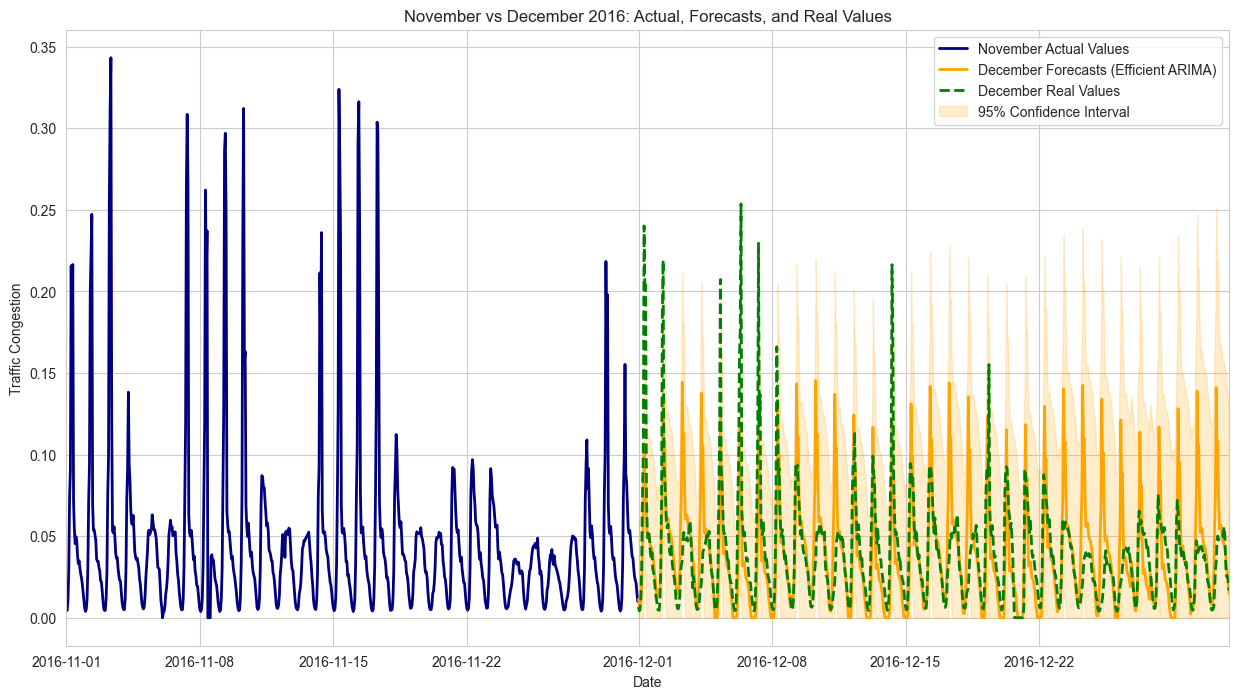

In [25]:
# Cell 23 - Plot Efficient Model Results
def plot_complete_comparison_efficient(df, forecast_csv, solution_path):
    """
    Plot November actuals, December efficient forecasts, and December real values
    Colors chosen for colorblind visibility:
    - November actuals: Dark Blue
    - December forecasts: Orange
    - December real values: Green
    - Confidence intervals: Light Orange shading
    """
    # Read data files
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    solution = pd.read_csv(solution_path)
    solution.index = pd.date_range(start='2016-12-01', 
                                 periods=len(solution), 
                                 freq='H')
    
    # Get November data
    november_start = '2016-11-01'
    november_end = '2016-11-30 23:00:00'
    november_data = df.loc[november_start:november_end]
    
    # Create plot with proper size and dpi for better readability
    plt.figure(figsize=(15, 8), dpi=100)
    
    # Plot November actual values (Dark Blue)
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values', 
             color='#000080',  # Dark Blue
             linewidth=2)
    
    # Plot December forecasts (Orange) - making sure it's in December
    plt.plot(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
             forecasts['ARIMA_forecast'],
             label='December Forecasts (Efficient ARIMA)', 
             color='#FFA500',  # Orange
             linewidth=2)
    
    # Plot December real values (Green)
    plt.plot(solution.index, solution['X'],
             label='December Real Values', 
             color='#008000',  # Green
             linewidth=2,
             linestyle='--')
    
    # Add confidence intervals - making sure they're in December
    plt.fill_between(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='#FFA500',  # Orange
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('November vs December 2016: Actual, Forecasts, and Real Values')
    plt.ylabel('Traffic Congestion')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Adjust x-axis to show the entire period clearly
    plt.xlim(november_data.index[0], solution.index[-1])
    
    # Print comparison statistics
    print("\nForecast Error Metrics:")
    mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    plt.show()

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if os.path.exists('arima_forecasts_efficient.csv') and os.path.exists(solution_path):
    print("Plotting complete comparison...")
    plot_complete_comparison_efficient(df, 'arima_forecasts_efficient.csv', solution_path)
else:
    print("Missing required files. Please check both forecast and solution files exist.")

Plotting separate comparisons...

Forecast Error Metrics:
MAE: 0.0167
RMSE: 0.0281


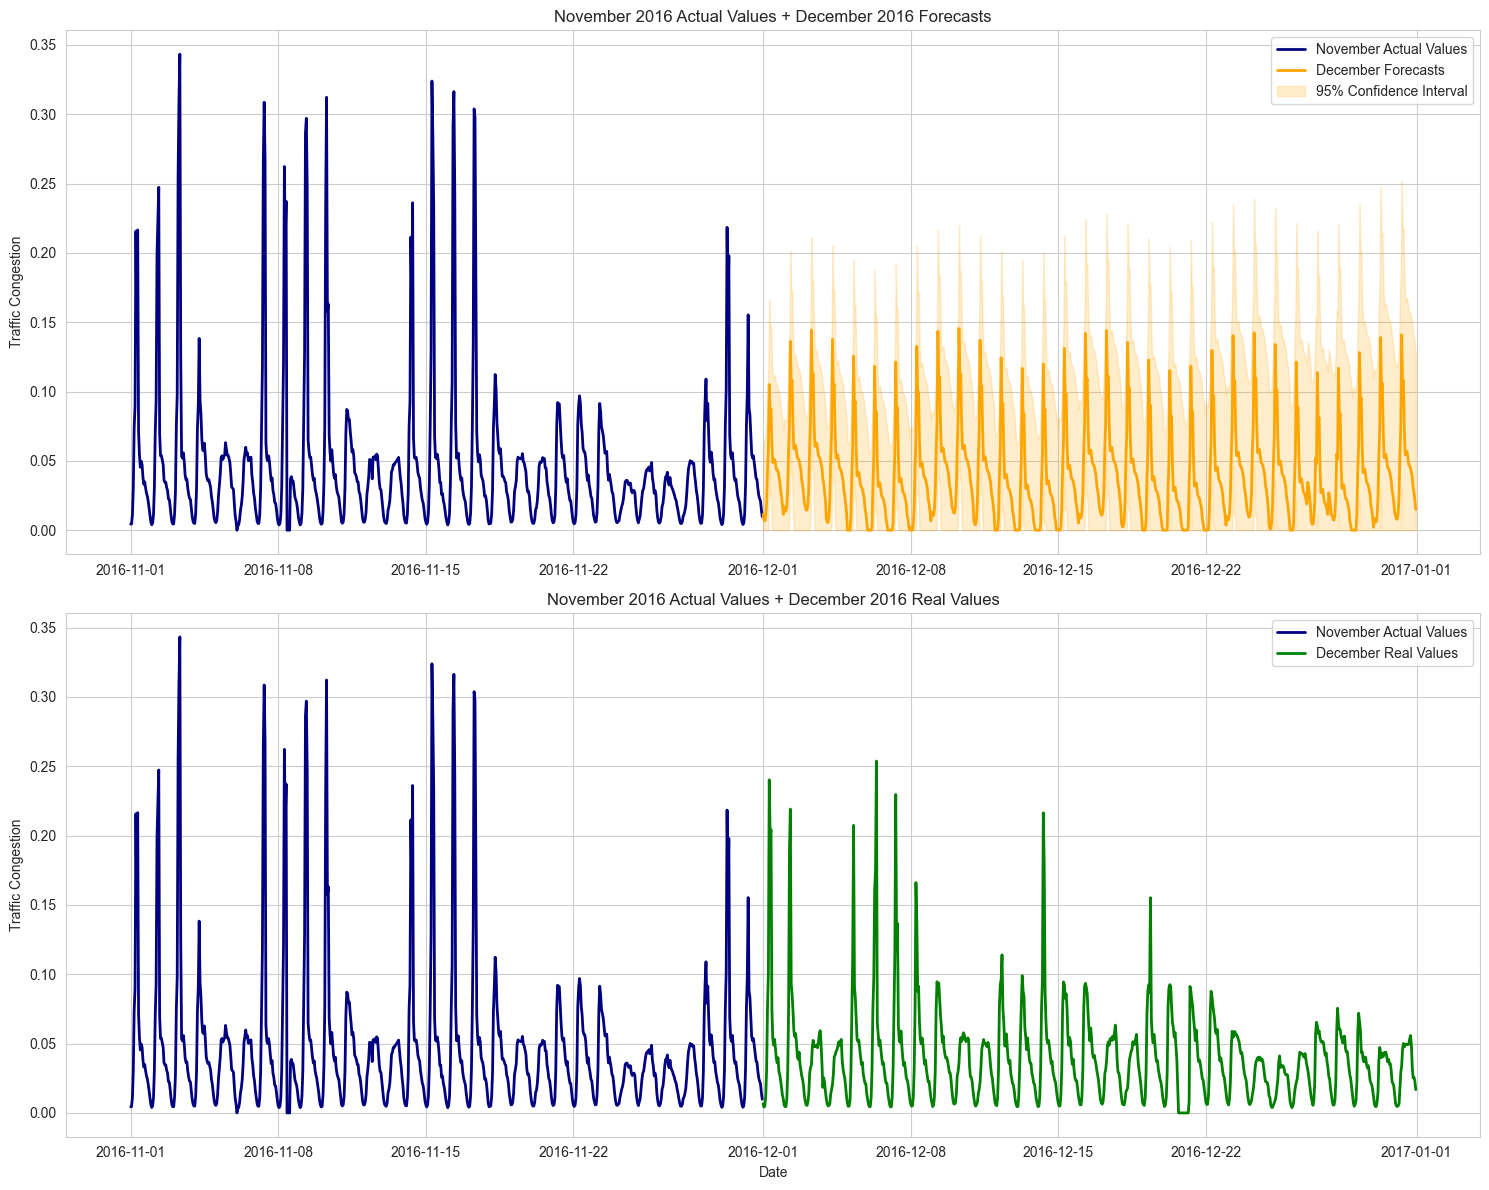

In [26]:
# Cell 24 - Create separate plots for forecasts and real values
def plot_separate_comparisons(df, forecast_csv, solution_path):
    """
    Create two separate plots:
    1. November actuals + December forecasts
    2. November actuals + December real values
    
    Colors chosen for colorblind visibility:
    - November actuals: Dark Blue
    - December forecasts: Orange
    - December real values: Green
    - Confidence intervals: Light Orange shading
    """
    # Read data files
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    solution = pd.read_csv(solution_path)
    solution.index = pd.date_range(start='2016-12-01', 
                                 periods=len(solution), 
                                 freq='H')
    
    # Get November data
    november_start = '2016-11-01'
    november_end = '2016-11-30 23:00:00'
    november_data = df.loc[november_start:november_end]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), dpi=100)
    
    # Plot 1: November + December Forecasts
    ax1.plot(november_data.index, november_data['X'],
            label='November Actual Values', 
            color='#000080',  # Dark Blue
            linewidth=2)
    
    december_dates = pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H')
    ax1.plot(december_dates, forecasts['ARIMA_forecast'],
            label='December Forecasts', 
            color='#FFA500',  # Orange
            linewidth=2)
    
    ax1.fill_between(december_dates,
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='#FFA500',  # Orange
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    ax1.set_title('November 2016 Actual Values + December 2016 Forecasts')
    ax1.set_ylabel('Traffic Congestion')
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: November + December Real Values
    ax2.plot(november_data.index, november_data['X'],
            label='November Actual Values', 
            color='#000080',  # Dark Blue
            linewidth=2)
    
    ax2.plot(solution.index, solution['X'],
            label='December Real Values', 
            color='#008000',  # Green
            linewidth=2)
    
    ax2.set_title('November 2016 Actual Values + December 2016 Real Values')
    ax2.set_ylabel('Traffic Congestion')
    ax2.set_xlabel('Date')
    ax2.grid(True)
    ax2.legend()
    
    # Adjust layout and display
    plt.tight_layout()
    
    # Print comparison statistics
    print("\nForecast Error Metrics:")
    mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    plt.show()

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if os.path.exists('arima_forecasts_efficient.csv') and os.path.exists(solution_path):
    print("Plotting separate comparisons...")
    plot_separate_comparisons(df, 'arima_forecasts_efficient.csv', solution_path)
else:
    print("Missing required files. Please check both forecast and solution files exist.")

# Analysis of SARIMA Models for Hourly Traffic Data

## 1. Model Structures and Intuition

### Model 1: SARIMA(2, 1, 2)(1, 1, 1)_24

- **Regular ARIMA part:** \((p,d,q) = (2,1,2)\)  
  - 2 autoregressive terms (\(\text{AR}(2)\))  
  - 1 regular difference (\(d = 1\))  
  - 2 moving average terms (\(\text{MA}(2)\))  
- **Seasonal part (period = 24 hours):** \((P,D,Q) = (1,1,1)\)  
  - 1 seasonal AR(\(\Phi_1\)) term  
  - 1 seasonal difference (\(D = 1\))  
  - 1 seasonal MA(\(\Theta_1\)) term  

This implies the data has a strong daily seasonal structure and also some short-term hour-to-hour correlations.

The model is:

\[
\phi_2(B)\,\Phi_1(B^{24})\,(1-B)\,(1-B^{24})\,X_t 
\;=\; \theta_2(B)\,\Theta_1(B^{24})\,\varepsilon_t.
\]

---

### Model 2: SARIMAX(2, 1, 2)(1, 1, 1)_24 with External Regressors

- **Same SARIMA structure** as Model 1, **plus** external regressors \(\beta' Z_t\):  
  - \(Z_t\) includes: \(\text{hour_sin}, \text{hour_cos}, \text{day_sin}, \text{day_cos}, \text{christmas_evening}\).  

The equation (simplified) is:

\[
\phi_2(B)\,\Phi_1(B^{24})\,(1-B)\,(1-B^{24})\,[\,X_t - \beta' Z_t\,]
\;=\; \theta_2(B)\,\Theta_1(B^{24})\,\varepsilon_t.
\]

The goal is to see if adding specific cyclical and holiday effects improves the model fit and forecasts.

---

## 2. Comparing Key Fit Statistics

| Model            | Log-Likelihood | AIC         | BIC         |
|------------------|----------------|-------------|-------------|
| **Model 1**      | 37587.551      | -75161.101  | -75107.337  |
| **Model 2**      | 37345.423      | -74666.846  | -74574.679  |

- **Model 1** has a higher log-likelihood (37587 vs. 37345).  
- **Model 1** also has lower (better) AIC and BIC than Model 2.

By standard information criteria, **Model 1** outperforms **Model 2**, even though Model 2 includes additional regressors.

---

## 3. Parameter Estimates and Significance

### 3.1. Model 1 Parameter Estimates

- **ar.L1:** 1.0280 (p < 0.0001)  
- **ar.L2:** -0.2997 (p < 0.0001)  
- **ma.L1:** -1.2680 (p < 0.0001)  
- **ma.L2:** 0.2727 (p < 0.0001)  
- **ar.S.L24:** 0.2885 (p < 0.0001)  
- **ma.S.L24:** -0.9842 (p < 0.0001)  
- **\(\sigma^2\):** 0.0005  

**Implications:**

1. **Nonseasonal AR(1) is slightly above 1**: Could indicate a high level of persistence, but combined with differencing and other terms, it may still be stationary in practice.  
2. **Nonseasonal AR(2) is negative**: Suggests hour-to-hour dynamics might reverse after 2 lags.  
3. **Large negative MA(1)**: Implies strong “shock” corrections from one hour to the next.  
4. **Seasonal terms** show a strong daily pattern (24-hour). The large negative seasonal MA suggests strong correction day-to-day at the same hour.  
5. **Very small \(\sigma^2\)** on the differenced scale indicates a tight fit.

---

### 3.2. Model 2 Parameter Estimates

- **External Regressors**:  
  - **hour_sin:** ~\(-3.36 \times 10^{-9}\), p=0.96 (not significant)  
  - **hour_cos:** ~\(1.03 \times 10^{-9}\), p=0.98 (not significant)  
  - **day_sin:** 0.0144, p<0.0001 (significant)  
  - **day_cos:** 0.0007, p=0.49 (not significant)  
  - **christmas_evening:** 0.0236, p<0.0001 (significant)  

- **ARMA terms**:  
  - **ar.L1:** 0.0284 (p=0.82, not significant)  
  - **ar.L2:** 0.3529 (p<0.0001, significant)  
  - **ma.L1:** -0.3691 (p=0.003, significant)  
  - **ma.L2:** -0.6173 (p<0.0001, significant)  
  - **ar.S.L24:** 0.2995 (p<0.0001, significant)  
  - **ma.S.L24:** -0.9420 (p<0.0001, significant)  

- **\(\sigma^2\):** 0.0006  

**Implications:**

1. **hour_sin/cos are effectively zero** and not significant, suggesting the 24-hour seasonal ARIMA structure itself captures the diurnal pattern.  
2. **day_sin is significant**, indicating a weekly cycle not fully captured by the 24-hour differencing.  
3. **day_cos is not significant**. Possibly day_sin alone is enough, or there’s collinearity.  
4. **christmas_evening is significant**, indicating a unique effect around Christmas.  
5. **AR(1) is no longer significant** once external regressors are added.  
6. The overall \(\sigma^2\) is slightly larger than in Model 1, and AIC/BIC are worse.

---

## 4. Residual Diagnostics

- **Ljung-Box (L1) (Q):**  
  - Model 1: 1.22 (p=0.27)  
  - Model 2: 105.71 (p=0.00)  

  Model 2’s residuals show significant autocorrelation at lag 1, whereas Model 1’s residuals do not.

- **Jarque-Bera (JB):** Extremely large for both, indicating **non-normality** in residuals. This is common in traffic data.  
- **Heteroskedasticity (H) tests:** Both show p-values suggesting some non-constant variance in residuals (again, common in traffic contexts).

---

## 5. Overall Implications & Next Steps

1. **Model 1 (Pure SARIMA) Outperforms Model 2 (SARIMAX)**  
   - Lower AIC/BIC and higher log-likelihood indicate a better fit.  
   - The added regressors (especially hour_sin, hour_cos) don’t help much beyond what the 24-hour seasonal differencing already provides.

2. **Significant Regressors** in Model 2 (day_sin, christmas_evening) do show real effects, but the overall fit doesn’t improve enough to beat Model 1 in penalized-likelihood terms.

3. **Potential Over-Differencing / High Persistence**  
   - AR(1) near or above 1 can happen; ensure stationarity conditions hold by checking inverse roots.

4. **Residual Diagnostics**  
   - Both models deviate from normality and may have heteroskedasticity. For best forecast intervals, consider alternative error structures or transformations.

5. **Choosing the “Best” Model**  
   - If you want the best numeric fit and forecasts, **Model 1** appears superior.  
   - If interpretability about weekly or holiday effects is crucial, you could still consider a SARIMAX approach (perhaps removing hour_sin/hour_cos and optimizing further).

6. **Next Steps**  
   - Try a model that keeps “day_sin” and “christmas_evening” but omits the unhelpful hour_sin/hour_cos terms.  
   - Consider multi-seasonal approaches (e.g., 24-hour + 168-hour for weekly seasonality), or day-of-week dummies.  
   - Consider variance-stabilizing transformations if the raw residuals show heavy skew/kurtosis.

---

## 6. Summary

- **Model 1**: By AIC/BIC, this is the better-fitting model for hourly traffic. It captures strong daily seasonality and short-term AR/MA components.  
- **Model 2**: Although it includes meaningful regressors (especially day-of-week and holiday effects), it does not outperform Model 1 in overall fit. The 24-hour seasonal differencing/ARMA already explains much of the diurnal pattern, leaving the cyclical hour regressors insignificant.  
- **Residuals**: Both models have non-normal, possibly heteroskedastic residuals, which is not unusual in traffic data.  

In practice, **Model 1** might be the simpler, better choice for forecasting hourly traffic, while **Model 2** has added interpretability regarding holiday and weekly patterns but does not necessarily improve forecast accuracy.


# Model 3: SARIMAX(2,1,2)(1,1,1)_24 more efficient

In [32]:
# Cell 25 - New Feature Creation Function
def create_refined_features(dates):
    """
    Create features: only day_cos and christmas_evening
    """
    features = pd.DataFrame(index=dates)
    
    # Day of week (0-6) as cosine feature only
    days = 7
    features['day_sin'] = np.sin(2 * np.pi * dates.dayofweek / days)
    
    # Christmas evening indicator
    christmas_evenings = ((dates.day.isin([25, 26])) &
                         (dates.hour.isin(range(20, 24))) |
                         (dates.day.isin([26, 27])) &
                         (dates.hour.isin(range(0, 6))))
    features['christmas_evening'] = christmas_evenings.astype(int)
    
    return features

In [33]:
# Cell 26 - Refined SARIMAX Model Development
def develop_refined_sarimax(train_data):
    """
    Develop SARIMAX model with day_cos and christmas_evening regressors
    Maintains complete AR(2) structure
    """
    print("=== Refined SARIMAX Model Development ===")
    
    # Prepare the target variable
    y = train_data['X'].astype(float)
    y.index = pd.date_range(start=y.index[0], periods=len(y), freq='H')
    
    # Create features
    exog_train = create_refined_features(y.index)
    print(f"\nIncluded features: {exog_train.columns.tolist()}")
    
    try:
        # Fit model with daily seasonality and selected regressors
        model = ARIMA(y,
                     order=(2, 1, 2),          # Keep complete AR(2)
                     seasonal_order=(1, 1, 1, 24),  # Daily seasonality
                     exog=exog_train,
                     enforce_stationarity=False,
                     enforce_invertibility=True)
        
        results = model.fit()
        print("\nModel Summary:")
        print(results.summary())
        
        return results, exog_train
    
    except Exception as e:
        print(f"Error fitting model:")
        print(f"Error message: {str(e)}")
        raise

In [34]:
# Cell 27 - Generate Forecasts for Refined Model
def generate_refined_forecasts(model, train_data, forecast_horizon=744):
    """
    Generate forecasts using the refined model
    """
    # Create forecast dates
    forecast_start = train_data.index[-1] + pd.Timedelta(hours=1)
    forecast_dates = pd.date_range(forecast_start, periods=forecast_horizon, freq='H')
    
    # Create features for forecast period
    exog_forecast = create_refined_features(forecast_dates)
    
    # Generate forecasts
    forecasts = model.forecast(steps=forecast_horizon, exog=exog_forecast)
    forecasts = np.maximum(forecasts, 0)  # Ensure non-negative
    
    # Get confidence intervals
    conf_int = model.get_forecast(steps=forecast_horizon, exog=exog_forecast).conf_int()
    conf_int.iloc[:, 0] = np.maximum(conf_int.iloc[:, 0], 0)  # Ensure non-negative lower bound
    
    return forecasts, conf_int, forecast_dates

In [ ]:
# Cell 38 - Run Refined SARIMAX Pipeline
print("Starting Refined SARIMAX modeling pipeline...")

try:
    # Train the model
    refined_model, refined_features = develop_refined_sarimax(train_set)
    
    # Generate forecasts
    forecast_mean, forecast_conf, forecast_dates = generate_refined_forecasts(refined_model, train_set)
    
    # Create and save forecast DataFrame
    forecast_df = pd.DataFrame({
        'datetime': forecast_dates,
        'ARIMA_forecast': forecast_mean,
        'ARIMA_lower': forecast_conf.iloc[:, 0],
        'ARIMA_upper': forecast_conf.iloc[:, 1]
    })
    forecast_df.to_csv('arima_forecasts_refined.csv', index=False)
    
    print("\nRefined SARIMAX model completed!")
    print("Forecasts saved to 'arima_forecasts_refined.csv'")
    
except Exception as e:
    print(f"Error in pipeline: {str(e)}")
    raise

Starting Refined SARIMAX modeling pipeline...
=== Refined SARIMAX Model Development ===

Included features: ['day_sin', 'christmas_evening']


c:\Users\alexc\GitHubRepos\Project_TimeSeries\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16056
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               37577.568
Date:                            Sat, 11 Jan 2025   AIC                         -75137.136
Time:                                    11:41:58   BIC                         -75068.010
Sample:                                01-01-2015   HQIC                        -75114.273
                                     - 10-30-2016                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
day_sin               0.0113      0.001     10.461      0.000       0.009       0.01

Plotting refined model results...

Forecast Error Metrics:
MAE: 0.0164
RMSE: 0.0284
MAPE: nan%


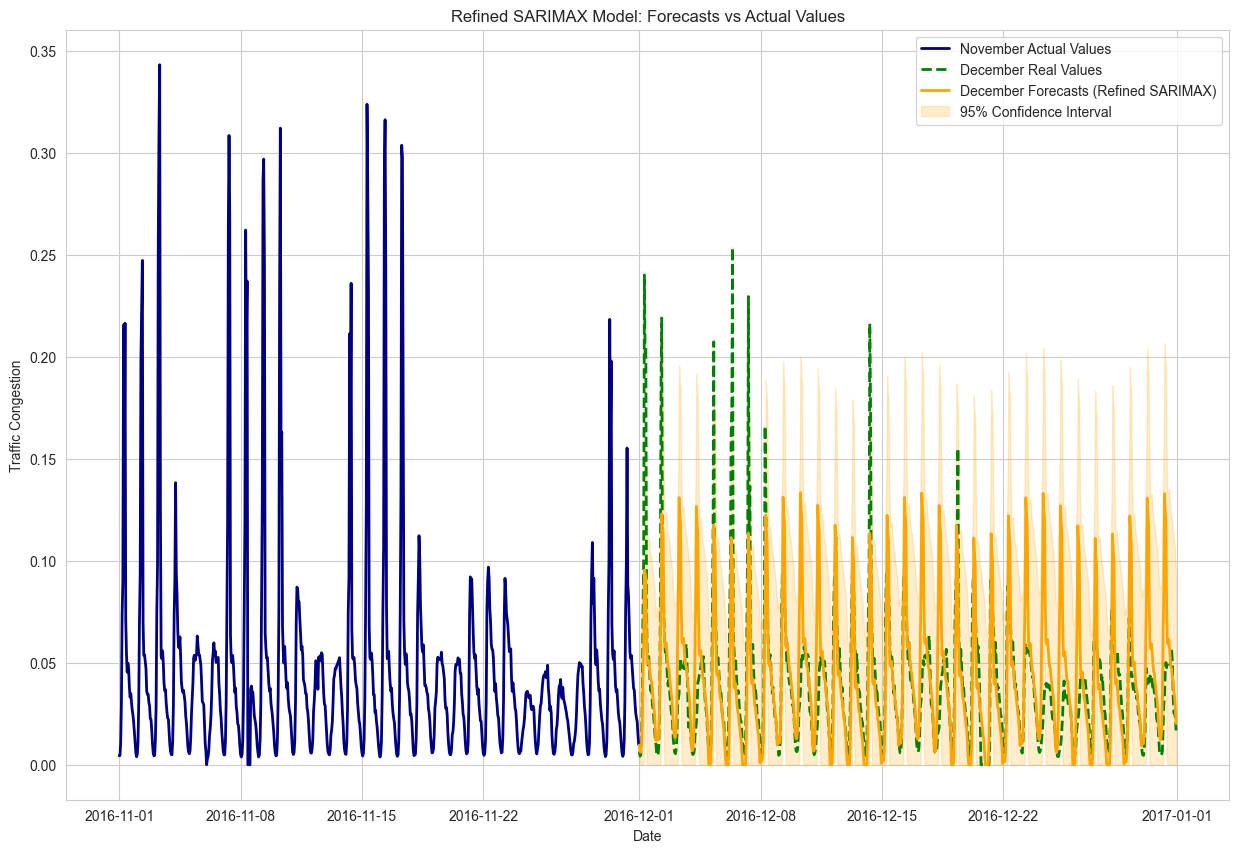

In [ ]:
# Cell 29 - Plot Results
def plot_refined_model_results(df, forecast_csv, solution_path):
    """
    Plot results of the refined model
    """
    # Read data files
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    solution = pd.read_csv(solution_path)
    solution.index = pd.date_range(start='2016-12-01',
                                 periods=len(solution),
                                 freq='H')
    
    # Get November data
    november_data = df.loc['2016-11-01':'2016-11-30 23:00:00']
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot data
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values',
             color='#000080',
             linewidth=2)
    
    plt.plot(solution.index, solution['X'],
             label='December Real Values',
             color='#008000',
             linewidth=2,
             linestyle='--')
    
    plt.plot(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
             forecasts['ARIMA_forecast'],
             label='December Forecasts (Refined SARIMAX)',
             color='#FFA500',
             linewidth=2)
    
    # Add confidence intervals
    plt.fill_between(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='#FFA500',
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('Refined SARIMAX Model: Forecasts vs Actual Values')
    plt.ylabel('Traffic Congestion')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print error metrics
    print("\nForecast Error Metrics:")
    mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
    mape = np.mean(np.abs((solution['X'] - forecasts['ARIMA_forecast']) / solution['X'])) * 100
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    plt.show()

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if os.path.exists('arima_forecasts_refined.csv') and os.path.exists(solution_path):
    print("Plotting refined model results...")
    plot_refined_model_results(df, 'arima_forecasts_refined.csv', solution_path)
else:
    print("Missing required files. Please check both forecast and solution files exist.")

In [37]:
# Cell 30 - Feature Creation Without Christmas
def create_weekly_features(dates):
    """
    Create features: only day_sin
    """
    features = pd.DataFrame(index=dates)
    
    # Day of week (0-6) as sine feature only
    days = 7
    features['day_sin'] = np.sin(2 * np.pi * dates.dayofweek / days)
    
    return features

In [38]:
# Cell 31 - SARIMAX Model Without Christmas Effect
def develop_weekly_sarimax(train_data):
    """
    Develop SARIMAX model with only day_sin regressor
    """
    print("=== Weekly-Only SARIMAX Model Development ===")
    
    # Prepare the target variable
    y = train_data['X'].astype(float)
    y.index = pd.date_range(start=y.index[0], periods=len(y), freq='H')
    
    # Create features
    exog_train = create_weekly_features(y.index)
    print(f"\nIncluded features: {exog_train.columns.tolist()}")
    
    try:
        # Fit model
        model = ARIMA(y,
                     order=(2, 1, 2),
                     seasonal_order=(1, 1, 1, 24),
                     exog=exog_train,
                     enforce_stationarity=False,
                     enforce_invertibility=True)
        
        results = model.fit()
        print("\nModel Summary:")
        print(results.summary())
        
        return results, exog_train
    
    except Exception as e:
        print(f"Error fitting model:")
        print(f"Error message: {str(e)}")
        raise

In [42]:
# Cell 32 - Generate Forecasts for Weekly-Only Model
def generate_weekly_forecasts(model, train_data, forecast_horizon=744):
    """
    Generate forecasts using the weekly-only model
    """
    # Create forecast dates
    forecast_start = train_data.index[-1] + pd.Timedelta(hours=1)
    forecast_dates = pd.date_range(forecast_start, periods=forecast_horizon, freq='H')
    
    # Create features for forecast period
    exog_forecast = create_weekly_features(forecast_dates)
    
    # Generate forecasts
    forecasts = model.forecast(steps=forecast_horizon, exog=exog_forecast)
    forecasts = np.maximum(forecasts, 0)  # Ensure non-negative
    
    # Get confidence intervals
    conf_int = model.get_forecast(steps=forecast_horizon, exog=exog_forecast).conf_int()
    conf_int.iloc[:, 0] = np.maximum(conf_int.iloc[:, 0], 0)  # Ensure non-negative lower bound
    
    return forecasts, conf_int, forecast_dates

In [ ]:
# Cell 33 - Run Weekly-Only Pipeline
print("Starting Weekly-Only SARIMAX modeling pipeline...")

try:
    # Train the model
    weekly_model, weekly_features = develop_weekly_sarimax(train_set)
    
    # Generate forecasts using the weekly-only forecast function
    forecast_mean, forecast_conf, forecast_dates = generate_weekly_forecasts(
        weekly_model, 
        train_set,
        forecast_horizon=744
    )
    
    # Save forecasts
    forecast_df = pd.DataFrame({
        'datetime': forecast_dates,
        'ARIMA_forecast': forecast_mean,
        'ARIMA_lower': forecast_conf.iloc[:, 0],
        'ARIMA_upper': forecast_conf.iloc[:, 1]
    })
    forecast_df.to_csv('arima_forecasts_weekly.csv', index=False)
    
    print("\nWeekly-Only SARIMAX model completed!")
    print("Forecasts saved to 'arima_forecasts_weekly.csv'")
    
except Exception as e:
    print(f"Error in pipeline: {str(e)}")
    raise

Starting Weekly-Only SARIMAX modeling pipeline...
=== Weekly-Only SARIMAX Model Development ===

Included features: ['day_sin']

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16056
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               37577.438
Date:                            Sat, 11 Jan 2025   AIC                         -75138.877
Time:                                    12:05:06   BIC                         -75077.432
Sample:                                01-01-2015   HQIC                        -75118.555
                                     - 10-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

Plotting weekly model results...

Forecast Error Metrics:
MAE: 0.0164
RMSE: 0.0284
MAPE: nan%


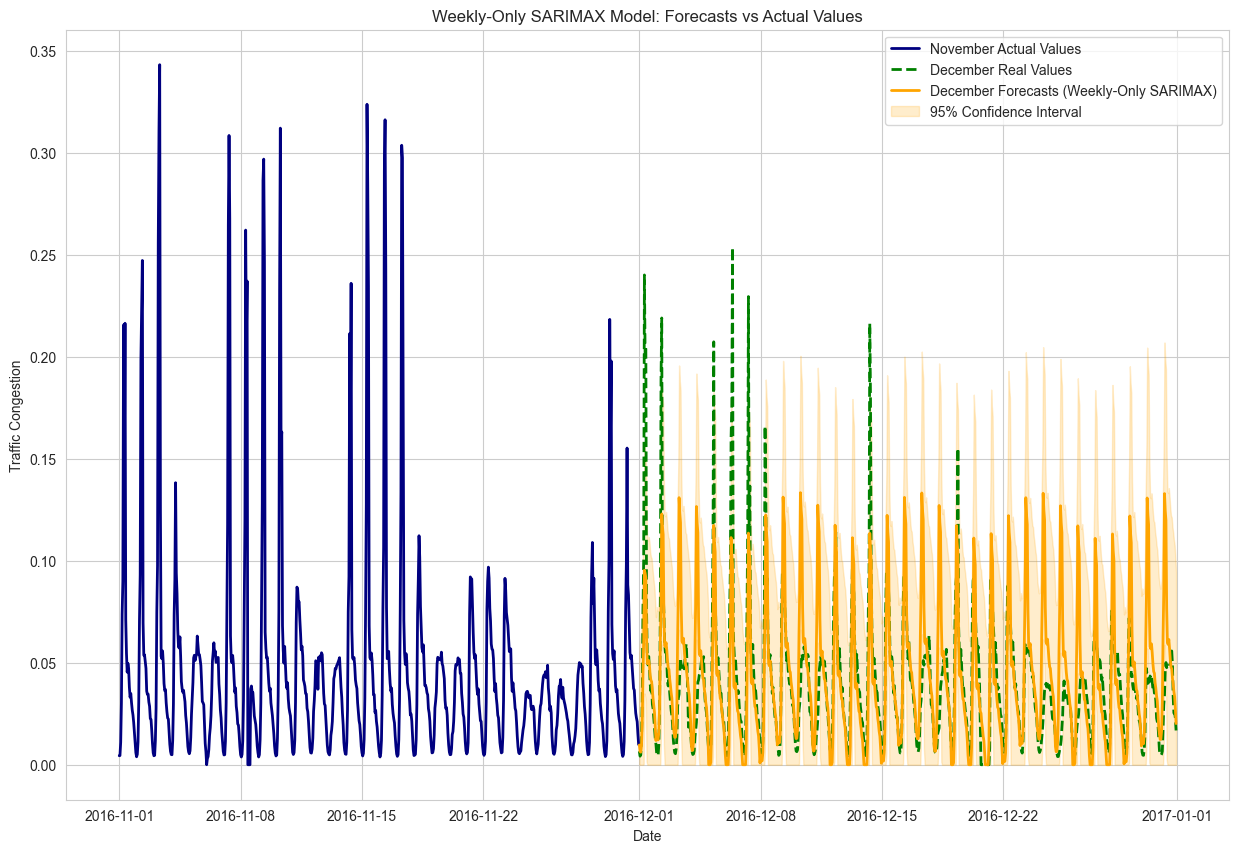

In [43]:
# Cell 34 - Plot Weekly-Only Model Results
def plot_weekly_model_results(df, forecast_csv, solution_path):
    """
    Plot results of the weekly-only model
    """
    # Read data files
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    solution = pd.read_csv(solution_path)
    solution.index = pd.date_range(start='2016-12-01',
                                 periods=len(solution),
                                 freq='H')
    
    # Get November data
    november_data = df.loc['2016-11-01':'2016-11-30 23:00:00']
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot data
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values',
             color='#000080',
             linewidth=2)
    
    plt.plot(solution.index, solution['X'],
             label='December Real Values',
             color='#008000',
             linewidth=2,
             linestyle='--')
    
    plt.plot(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
             forecasts['ARIMA_forecast'],
             label='December Forecasts (Weekly-Only SARIMAX)',
             color='#FFA500',
             linewidth=2)
    
    # Add confidence intervals
    plt.fill_between(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='#FFA500',
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('Weekly-Only SARIMAX Model: Forecasts vs Actual Values')
    plt.ylabel('Traffic Congestion')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print error metrics
    print("\nForecast Error Metrics:")
    mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
    mape = np.mean(np.abs((solution['X'] - forecasts['ARIMA_forecast']) / solution['X'])) * 100
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    plt.show()

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if os.path.exists('arima_forecasts_weekly.csv') and os.path.exists(solution_path):
    print("Plotting weekly model results...")
    plot_weekly_model_results(df, 'arima_forecasts_weekly.csv', solution_path)
else:
    print("Missing required files. Please check both forecast and solution files exist.")


Traffic Statistics:

November 2015:
count    720.000000
mean       0.047818
std        0.058973
min        0.000000
25%        0.017075
50%        0.034950
75%        0.051900
max        0.396300
Name: X, dtype: float64

December 2015:
count    744.000000
mean       0.038663
std        0.029176
min        0.003900
25%        0.016775
50%        0.035400
75%        0.052000
max        0.243000
Name: X, dtype: float64

Christmas Period (24-27 Dec 2015):
count    96.000000
mean      0.026021
std       0.014018
min       0.003900
25%       0.013325
50%       0.028050
75%       0.038050
max       0.046900
Name: X, dtype: float64


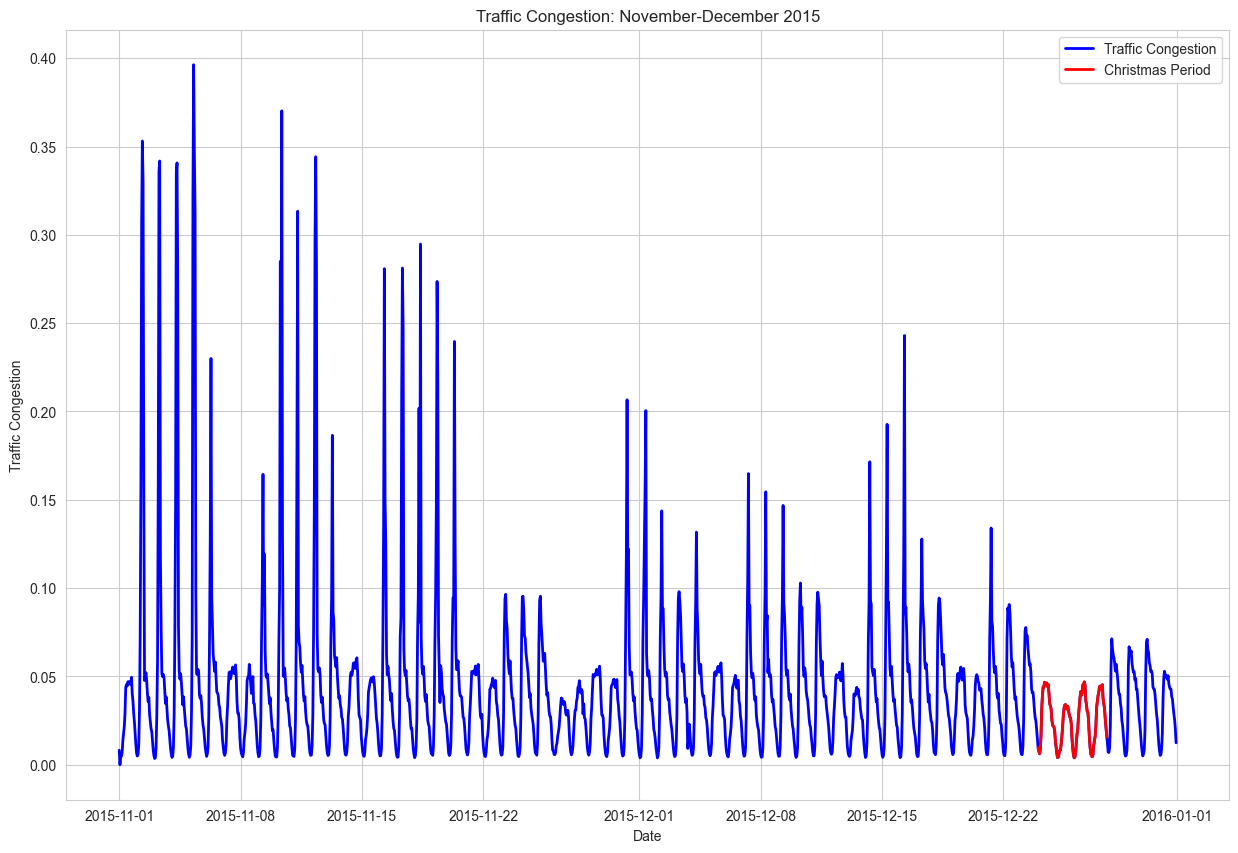

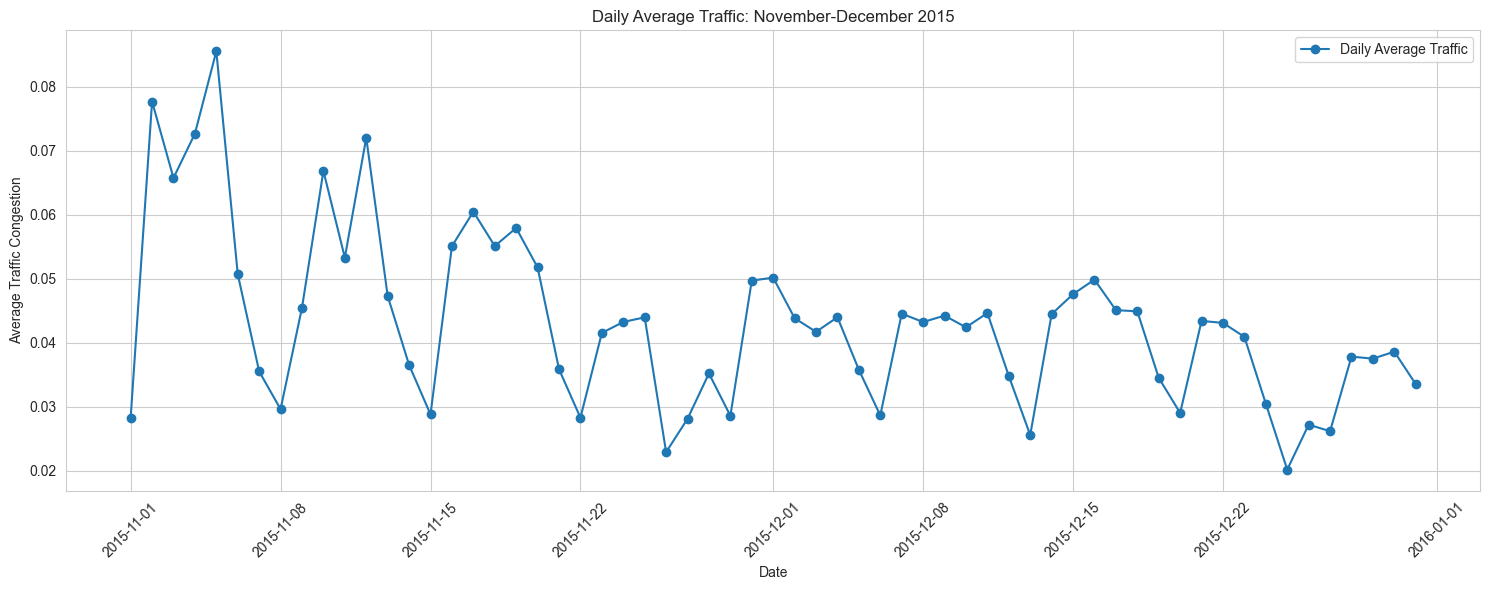

In [ ]:
# Cell 35 - Analyze November-December 2015
def analyze_2015_holidays(df):
    """
    Analyze and visualize traffic patterns for Nov-Dec 2015
    """
    # Get the data for Nov-Dec 2015
    nov_dec_2015 = df.loc['2015-11-01':'2015-12-31']
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot entire period
    plt.plot(nov_dec_2015.index, nov_dec_2015['X'],
             label='Traffic Congestion',
             color='blue',
             linewidth=2)
    
    # Highlight Christmas period
    christmas_period = nov_dec_2015.loc['2015-12-24':'2015-12-27']
    plt.plot(christmas_period.index, christmas_period['X'],
             color='red',
             linewidth=2,
             label='Christmas Period')
    
    plt.title('Traffic Congestion: November-December 2015')
    plt.ylabel('Traffic Congestion')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print some statistics
    print("\nTraffic Statistics:")
    print("\nNovember 2015:")
    nov_stats = df.loc['2015-11-01':'2015-11-30', 'X'].describe()
    print(nov_stats)
    
    print("\nDecember 2015:")
    dec_stats = df.loc['2015-12-01':'2015-12-31', 'X'].describe()
    print(dec_stats)
    
    print("\nChristmas Period (24-27 Dec 2015):")
    christmas_stats = df.loc['2015-12-24':'2015-12-27', 'X'].describe()
    print(christmas_stats)
    
    plt.show()
    
    # Additional plot for daily patterns
    plt.figure(figsize=(15, 6))
    
    # Calculate daily means
    daily_means = nov_dec_2015.groupby(nov_dec_2015.index.date)['X'].mean()
    
    plt.plot(daily_means.index, daily_means.values,
             marker='o',
             linestyle='-',
             label='Daily Average Traffic')
    
    plt.title('Daily Average Traffic: November-December 2015')
    plt.ylabel('Average Traffic Congestion')
    plt.xlabel('Date')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    
    plt.show()

# Execute the analysis
analyze_2015_holidays(df)

In [60]:
# Cell 36 - Phase-Adjusted Weekly Features
def create_phase_adjusted_features(dates):
    """
    Create features with phase-adjusted day_sin to align with Thursday start
    Thursday = 3 in Python's datetime (Mon=0, Sun=6)
    We need to shift the sine wave so that it peaks on Wednesday (day=2)
    """
    features = pd.DataFrame(index=dates)
    
    # Day of week (0-6) with phase adjustment for Wednesday peak
    days = 7
    # Shift phase by 2 days (peak on Wednesday)
    phase_shift = 2 * np.pi * 2/7  # 2 days shift
    features['day_sin'] = np.sin(2 * np.pi * dates.dayofweek/days + phase_shift)
    
    return features

In [61]:
# Cell 37 - Phase-Adjusted SARIMAX Model
def develop_phase_adjusted_sarimax(train_data):
    """
    Develop SARIMAX model with phase-adjusted day_sin regressor
    """
    print("=== Phase-Adjusted SARIMAX Model Development ===")
    
    # Prepare the target variable
    y = train_data['X'].astype(float)
    y.index = pd.date_range(start=y.index[0], periods=len(y), freq='H')
    
    # Create phase-adjusted features
    exog_train = create_phase_adjusted_features(y.index)
    print(f"\nIncluded features: {exog_train.columns.tolist()}")
    
    try:
        # Fit model
        model = ARIMA(y,
                     order=(2, 1, 2),
                     seasonal_order=(1, 1, 1, 24),
                     exog=exog_train,
                     enforce_stationarity=False,
                     enforce_invertibility=True)
        
        results = model.fit()
        print("\nModel Summary:")
        print(results.summary())
        
        return results, exog_train
    
    except Exception as e:
        print(f"Error fitting model:")
        print(f"Error message: {str(e)}")
        raise

In [62]:
# Cell 38 - Generate Phase-Adjusted Forecasts
def generate_phase_adjusted_forecasts(model, train_data, forecast_horizon=744):
    """
    Generate forecasts using the phase-adjusted model
    """
    # Create forecast dates
    forecast_start = train_data.index[-1] + pd.Timedelta(hours=1)
    forecast_dates = pd.date_range(forecast_start, periods=forecast_horizon, freq='H')
    
    # Create phase-adjusted features for forecast period
    exog_forecast = create_phase_adjusted_features(forecast_dates)
    
    # Generate forecasts
    forecasts = model.forecast(steps=forecast_horizon, exog=exog_forecast)
    forecasts = np.maximum(forecasts, 0)  # Ensure non-negative
    
    # Get confidence intervals
    conf_int = model.get_forecast(steps=forecast_horizon, exog=exog_forecast).conf_int()
    conf_int.iloc[:, 0] = np.maximum(conf_int.iloc[:, 0], 0)  # Ensure non-negative lower bound
    
    return forecasts, conf_int, forecast_dates

In [ ]:
# Cell 39 - Run Phase-Adjusted Pipeline
print("Starting Phase-Adjusted SARIMAX modeling pipeline...")

try:
    # Train the model
    phase_adj_model, phase_adj_features = develop_phase_adjusted_sarimax(train_set)
    
    # Generate forecasts
    forecast_mean, forecast_conf, forecast_dates = generate_phase_adjusted_forecasts(
        phase_adj_model, 
        train_set,
        forecast_horizon=744
    )
    
    # Save forecasts
    forecast_df = pd.DataFrame({
        'datetime': forecast_dates,
        'ARIMA_forecast': forecast_mean,
        'ARIMA_lower': forecast_conf.iloc[:, 0],
        'ARIMA_upper': forecast_conf.iloc[:, 1]
    })
    forecast_df.to_csv('arima_forecasts_phase_adjusted.csv', index=False)
    
    print("\nPhase-Adjusted SARIMAX model completed!")
    print("Forecasts saved to 'arima_forecasts_phase_adjusted.csv'")
    
except Exception as e:
    print(f"Error in pipeline: {str(e)}")
    raise

Starting Phase-Adjusted SARIMAX modeling pipeline...
=== Phase-Adjusted SARIMAX Model Development ===

Included features: ['day_sin']


c:\Users\alexc\GitHubRepos\Project_TimeSeries\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16056
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               37502.006
Date:                            Sat, 11 Jan 2025   AIC                         -74988.012
Time:                                    12:46:00   BIC                         -74926.567
Sample:                                01-01-2015   HQIC                        -74967.690
                                     - 10-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
day_sin       -0.0043      0.001     -3.539      0.000      -0.007      -0.002
ar.L1          0.02

Plotting phase-adjusted model results...

Forecast Error Metrics:
MAE: 0.0153
RMSE: 0.0268
MAPE: nan%


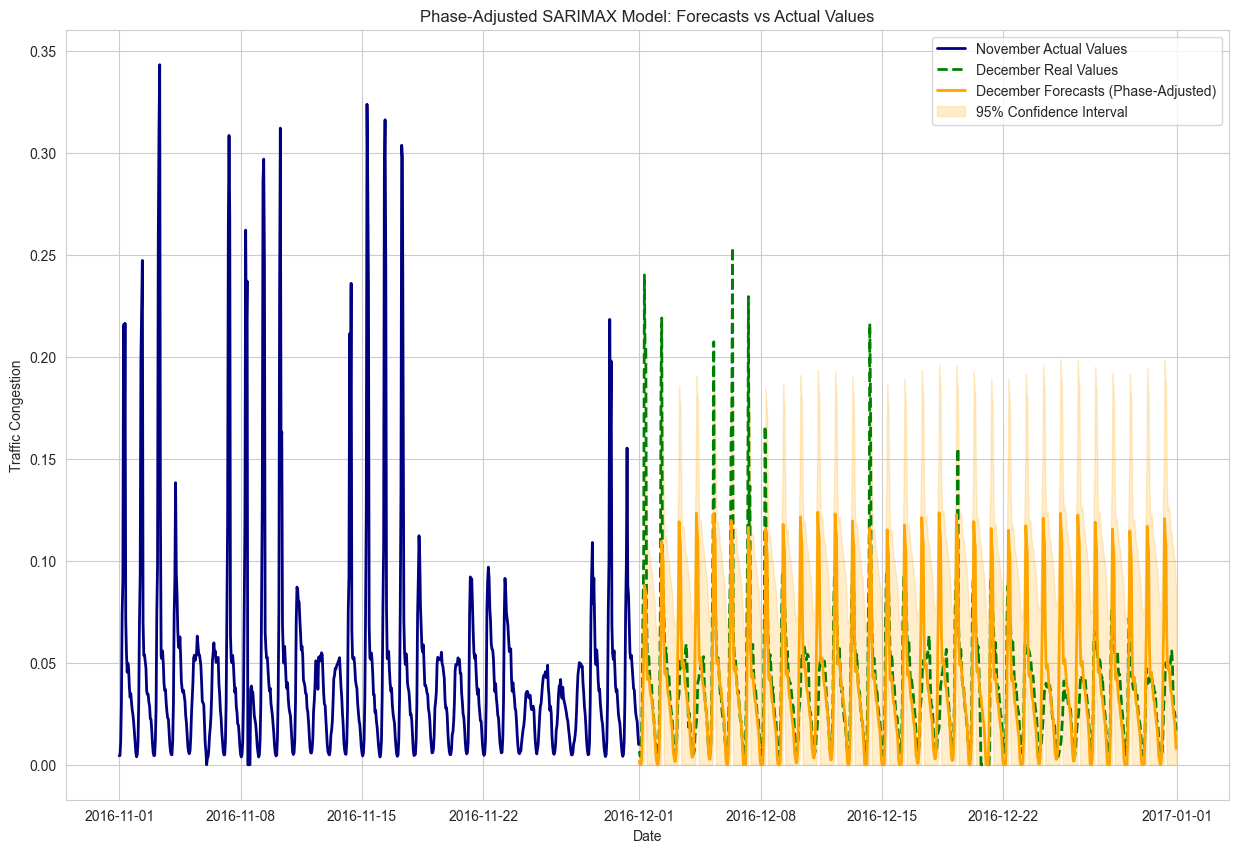

In [ ]:
# Cell 40 - Plot Phase-Adjusted Results
def plot_phase_adjusted_results(df, forecast_csv, solution_path):
    """
    Plot results of the phase-adjusted model
    """
    # Read data files
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    solution = pd.read_csv(solution_path)
    solution.index = pd.date_range(start='2016-12-01',
                                 periods=len(solution),
                                 freq='H')
    
    # Get November data
    november_data = df.loc['2016-11-01':'2016-11-30 23:00:00']
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot data
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values',
             color='#000080',
             linewidth=2)
    
    plt.plot(solution.index, solution['X'],
             label='December Real Values',
             color='#008000',
             linewidth=2,
             linestyle='--')
    
    plt.plot(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
             forecasts['ARIMA_forecast'],
             label='December Forecasts (Phase-Adjusted)',
             color='#FFA500',
             linewidth=2)
    
    # Add confidence intervals
    plt.fill_between(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='#FFA500',
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('Phase-Adjusted SARIMAX Model: Forecasts vs Actual Values')
    plt.ylabel('Traffic Congestion')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print error metrics
    print("\nForecast Error Metrics:")
    mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
    mape = np.mean(np.abs((solution['X'] - forecasts['ARIMA_forecast']) / solution['X'])) * 100
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    plt.show()

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if os.path.exists('arima_forecasts_phase_adjusted.csv') and os.path.exists(solution_path):
    print("Plotting phase-adjusted model results...")
    plot_phase_adjusted_results(df, 'arima_forecasts_phase_adjusted.csv', solution_path)
else:
    print("Missing required files. Please check both forecast and solution files exist.")

# UCM

In [65]:
# Cell 41 - UCM Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

def create_ucm_features(dates):
    """
    Create features for UCM models
    """
    features = pd.DataFrame(index=dates)
    
    # Weekly pattern (0-6) as sine wave with proper phase
    days = 7
    phase_shift = 2 * np.pi * 2/7  # Peak on Wednesday
    features['day_sin'] = np.sin(2 * np.pi * dates.dayofweek/days + phase_shift)
    
    # Christmas evening indicator
    christmas_evenings = ((dates.day.isin([25, 26])) & 
                         (dates.hour.isin(range(20, 24))) |
                         (dates.day.isin([26, 27])) & 
                         (dates.hour.isin(range(0, 6))))
    features['christmas_evening'] = christmas_evenings.astype(int)
    
    return features

In [83]:
# Cell 42 - Base UCM Model with Constrained Forecasting
def forecast_ucm(model, steps=744):
    """
    Generate forecasts from UCM model with constrained uncertainty
    """
    # Get the basic forecast
    forecast = model.forecast(steps=steps)
    
    # Calculate constrained prediction intervals
    sigma2_irregular = model.params['sigma2.irregular']
    sigma2_level = model.params['sigma2.level']
    sigma2_seasonal = model.params['sigma2.seasonal']
    
    # Calculate base variance for one period (24 hours)
    base_var = sigma2_irregular + sigma2_level + sigma2_seasonal
    
    # Calculate variance for each forecast step
    # Constrain growth to maximum of 3 seasonal cycles
    forecast_var = np.zeros(steps)
    for i in range(steps):
        # Calculate how many complete seasonal cycles we're forecasting
        cycles = min(i / 24, 3)  # Cap at 3 cycles
        forecast_var[i] = base_var * (1 + cycles * 0.1)  # 10% increase per cycle
    
    # Create confidence intervals
    z_score = 1.96  # 95% confidence
    ci_lower = forecast - z_score * np.sqrt(forecast_var)
    ci_upper = forecast + z_score * np.sqrt(forecast_var)
    
    # Ensure non-negative values
    ci_lower = np.maximum(ci_lower, 0)
    
    return forecast, pd.DataFrame({
        'lower': ci_lower,
        'upper': ci_upper
    })

In [88]:
# Cell 43 - Enhanced UCM Model with Better Forecasting
def forecast_enhanced_ucm(model, train_data, forecast_dates, steps=744):
    """
    Generate forecasts from enhanced UCM model with constrained uncertainty
    Includes weekly seasonality via day_sin
    """
    # Create features for forecast period
    exog_forecast = create_ucm_features(forecast_dates)['day_sin']
    
    # Get the basic forecast
    forecast = model.forecast(steps=steps, exog=exog_forecast)
    
    # Calculate constrained prediction intervals
    sigma2_irregular = model.params['sigma2.irregular']
    sigma2_level = model.params['sigma2.level']
    sigma2_seasonal = model.params['sigma2.seasonal']
    
    # Calculate base variance for one period (24 hours)
    base_var = sigma2_irregular + sigma2_level + sigma2_seasonal
    
    # Calculate variance for each forecast step
    forecast_var = np.zeros(steps)
    for i in range(steps):
        # Calculate how many complete seasonal cycles we're forecasting
        cycles = min(i / 24, 3)  # Cap at 3 cycles
        # Add a small additional uncertainty for weekly pattern
        weekly_uncertainty = 0.05 * (i / (24 * 7))  # 5% increase per week
        forecast_var[i] = base_var * (1 + cycles * 0.1 + min(weekly_uncertainty, 0.15))
    
    # Create confidence intervals
    z_score = 1.96  # 95% confidence
    ci_lower = forecast - z_score * np.sqrt(forecast_var)
    ci_upper = forecast + z_score * np.sqrt(forecast_var)
    
    # Ensure non-negative values
    ci_lower = np.maximum(ci_lower, 0)
    
    return forecast, pd.DataFrame({
        'lower': ci_lower,
        'upper': ci_upper
    })

In [89]:
# Cell 44 - Final UCM Model with Better Forecasting
def forecast_final_ucm(model, train_data, forecast_dates, steps=744):
    """
    Generate forecasts from final UCM model with constrained uncertainty
    Includes weekly seasonality and Christmas effect
    """
    # Create features for forecast period
    exog_forecast = create_ucm_features(forecast_dates)
    
    # Get the basic forecast
    forecast = model.forecast(steps=steps, exog=exog_forecast)
    
    # Calculate constrained prediction intervals
    sigma2_irregular = model.params['sigma2.irregular']
    sigma2_level = model.params['sigma2.level']
    sigma2_seasonal = model.params['sigma2.seasonal']
    
    # Calculate base variance for one period (24 hours)
    base_var = sigma2_irregular + sigma2_level + sigma2_seasonal
    
    # Calculate variance for each forecast step
    forecast_var = np.zeros(steps)
    for i in range(steps):
        # Calculate how many complete seasonal cycles we're forecasting
        cycles = min(i / 24, 3)  # Cap at 3 cycles
        # Add a small additional uncertainty for weekly pattern
        weekly_uncertainty = 0.05 * (i / (24 * 7))  # 5% increase per week
        
        # Additional uncertainty during Christmas period
        is_christmas = exog_forecast['christmas_evening'].iloc[i] == 1
        christmas_factor = 0.2 if is_christmas else 0
        
        forecast_var[i] = base_var * (1 + cycles * 0.1 + 
                                    min(weekly_uncertainty, 0.15) + 
                                    christmas_factor)
    
    # Create confidence intervals
    z_score = 1.96  # 95% confidence
    ci_lower = forecast - z_score * np.sqrt(forecast_var)
    ci_upper = forecast + z_score * np.sqrt(forecast_var)
    
    # Ensure non-negative values
    ci_lower = np.maximum(ci_lower, 0)
    
    return forecast, pd.DataFrame({
        'lower': ci_lower,
        'upper': ci_upper
    })

In [90]:
# Cell 45 - Run UCM Pipeline and Compare Models
print("Starting UCM modeling pipeline...")

try:
    # Create forecast dates
    forecast_dates = pd.date_range(
        start=train_set.index[-1] + pd.Timedelta(hours=1),
        periods=744,
        freq='H'
    )
    
    # Fit models
    base_model = fit_base_ucm(train_set)
    enhanced_model = fit_enhanced_ucm(train_set)
    final_model = fit_final_ucm(train_set)
    
    # Generate forecasts
    base_forecast, base_ci = forecast_ucm(base_model)
    enhanced_forecast, enhanced_ci = forecast_enhanced_ucm(
        enhanced_model, train_set, forecast_dates
    )
    final_forecast, final_ci = forecast_final_ucm(
        final_model, train_set, forecast_dates
    )
    
    # Save forecasts
    for name, forecast, ci in [
        ('base', base_forecast, base_ci),
        ('enhanced', enhanced_forecast, enhanced_ci),
        ('final', final_forecast, final_ci)
    ]:
        forecast_df = pd.DataFrame({
            'datetime': forecast_dates,
            'UCM_forecast': forecast,
            'UCM_lower': ci.iloc[:, 0],
            'UCM_upper': ci.iloc[:, 1]
        })
        forecast_df.to_csv(f'ucm_forecasts_{name}.csv', index=False)
    
    print("\nUCM modeling pipeline completed!")

except Exception as e:
    print(f"Error in UCM pipeline: {str(e)}")
    raise

Starting UCM modeling pipeline...
=== Base UCM Model ===
                            Unobserved Components Results                            
Dep. Variable:                             X   No. Observations:                16056
Model:                           local level   Log Likelihood               35613.420
                   + stochastic seasonal(24)   AIC                         -71220.841
Date:                       Sat, 11 Jan 2025   BIC                         -71197.794
Time:                               13:25:44   HQIC                        -71213.219
Sample:                           01-01-2015                                         
                                - 10-30-2016                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

Plotting individual UCM results...


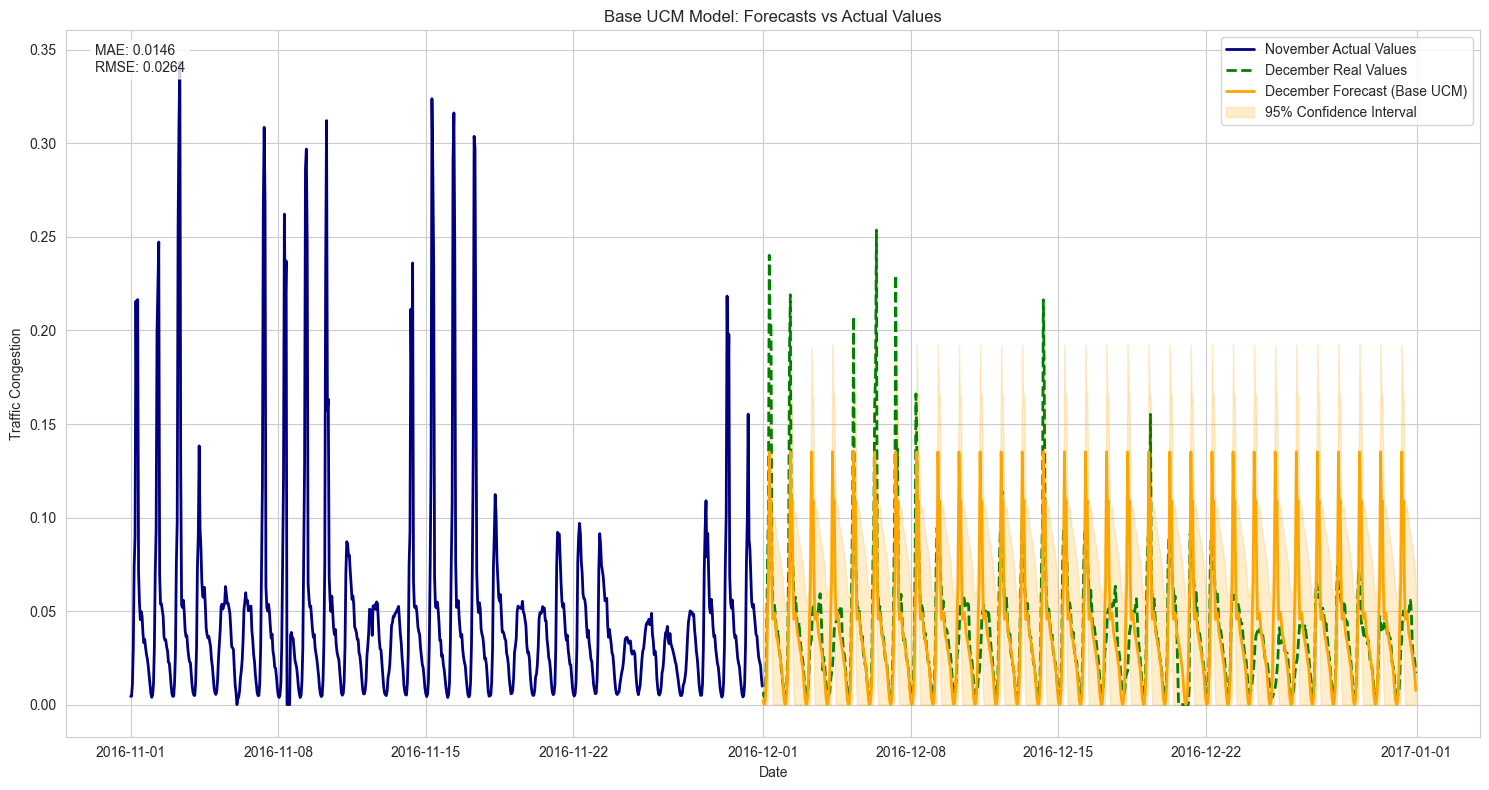


Base UCM Error Metrics:
MAE: 0.0146
RMSE: 0.0264


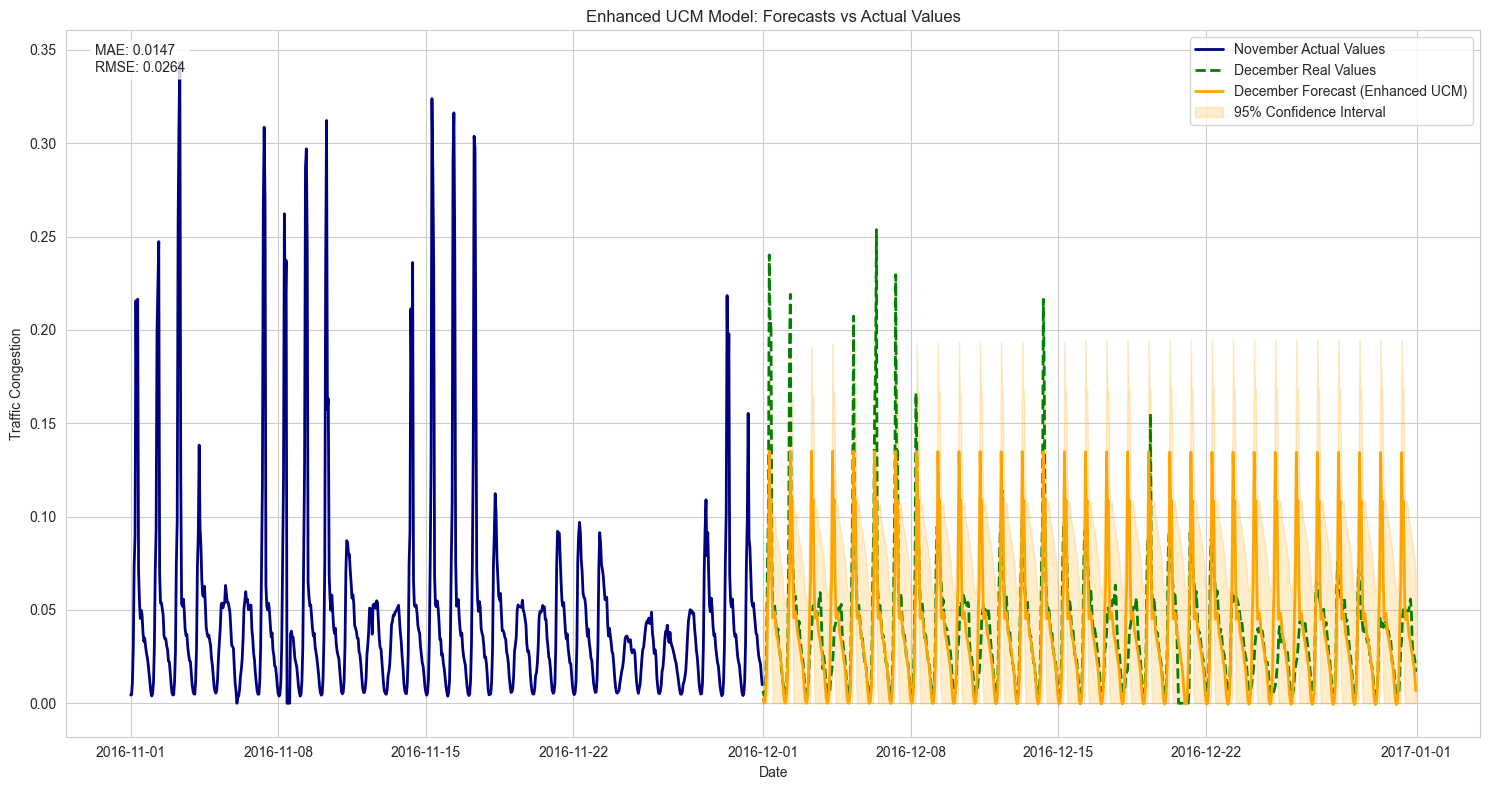


Enhanced UCM Error Metrics:
MAE: 0.0147
RMSE: 0.0264


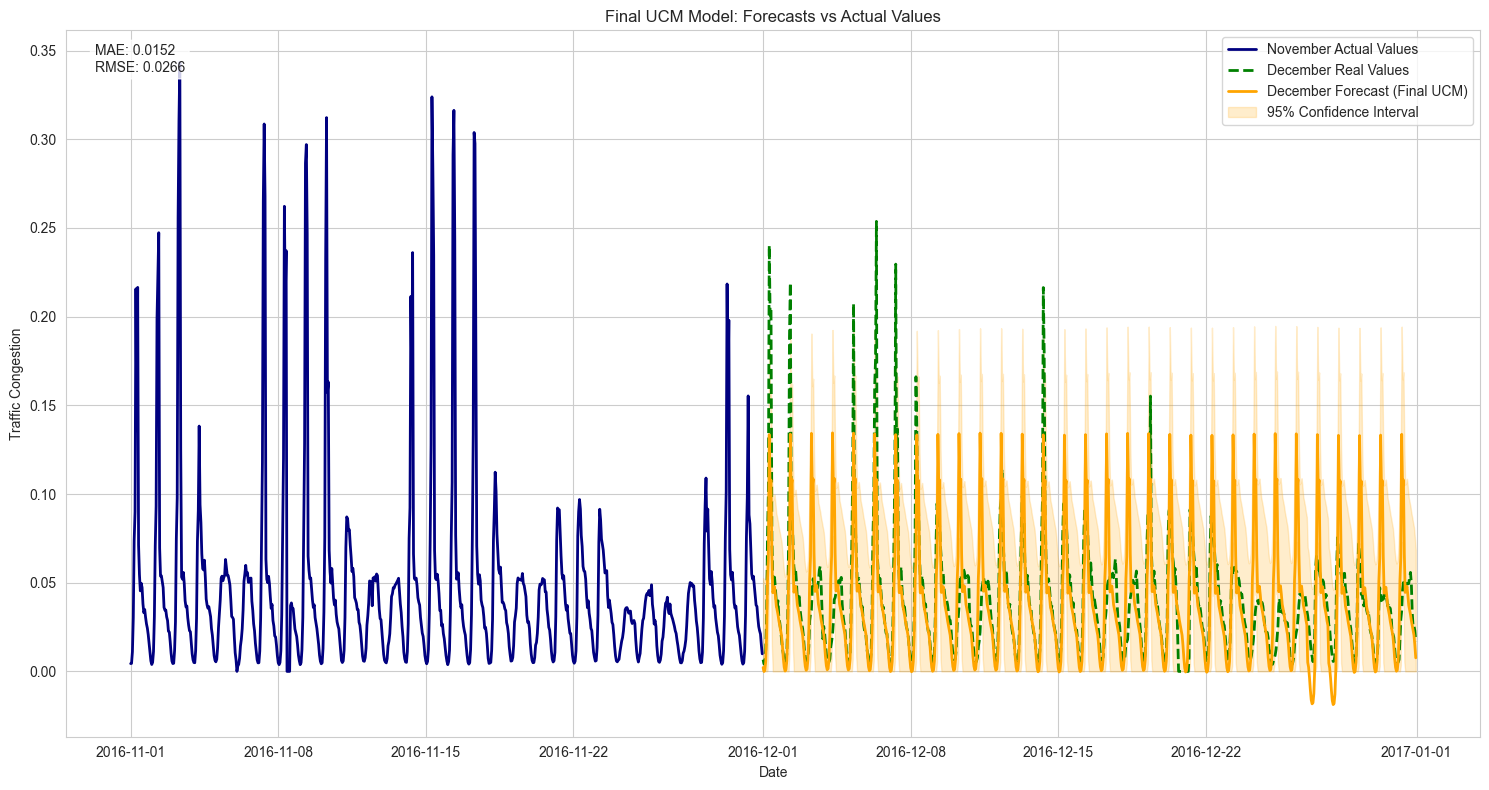


Final UCM Error Metrics:
MAE: 0.0152
RMSE: 0.0266


In [ ]:
# Cell 46 - Plot Individual UCM Results
def plot_individual_ucm_results(df, solution_path):
    """
    Create separate plots for each UCM model
    """
    # Read solution
    solution = pd.read_csv(solution_path)
    solution.index = pd.date_range(
        start='2016-12-01',
        periods=len(solution),
        freq='H'
    )
    
    # Get November data
    november_data = df.loc['2016-11-01':'2016-11-30 23:00:00']
    
    # Colors for consistency
    actual_color = '#000080'  # Dark Blue
    forecast_color = '#FFA500'  # Orange
    solution_color = '#008000'  # Green
    
    # Create plots for each model
    for name in ['base', 'enhanced', 'final']:
        # Read forecast data
        forecast_df = pd.read_csv(f'ucm_forecasts_{name}.csv')
        forecast_df['datetime'] = pd.to_datetime(forecast_df['datetime'])
        
        # Create figure
        plt.figure(figsize=(15, 8))
        
        # Plot actual November data
        plt.plot(november_data.index, november_data['X'],
                label='November Actual Values',
                color=actual_color,
                linewidth=2)
        
        # Plot December solution
        plt.plot(solution.index, solution['X'],
                label='December Real Values',
                color=solution_color,
                linewidth=2,
                linestyle='--')
        
        # Plot forecast
        plt.plot(pd.date_range(start='2016-12-01', periods=len(forecast_df), freq='H'),
                forecast_df['UCM_forecast'],
                label=f'December Forecast ({name.title()} UCM)',
                color=forecast_color,
                linewidth=2)
        
        # Add confidence intervals
        plt.fill_between(
            pd.date_range(start='2016-12-01', periods=len(forecast_df), freq='H'),
            forecast_df['UCM_lower'],
            forecast_df['UCM_upper'],
            color=forecast_color,
            alpha=0.2,
            label='95% Confidence Interval'
        )
        
        # Customize plot
        plt.title(f'{name.title()} UCM Model: Forecasts vs Actual Values')
        plt.ylabel('Traffic Congestion')
        plt.xlabel('Date')
        plt.legend()
        plt.grid(True)
        
        # Add error metrics as text box
        mae = mean_absolute_error(solution['X'], forecast_df['UCM_forecast'])
        rmse = np.sqrt(mean_squared_error(solution['X'], forecast_df['UCM_forecast']))
        metrics_text = f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}'
        plt.text(0.02, 0.98, metrics_text,
                transform=plt.gca().transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Print metrics
        print(f"\n{name.title()} UCM Error Metrics:")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if all(os.path.exists(f'ucm_forecasts_{name}.csv') 
       for name in ['base', 'enhanced', 'final']) \
   and os.path.exists(solution_path):
    print("Plotting individual UCM results...")
    plot_individual_ucm_results(df, solution_path)
else:
    print("Missing required files. Please run the UCM pipeline first.")

# MACHINE LEARNING

In [185]:
# Cell 47 - Additional ML Imports

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle  # For saving the trained model if needed

print("Additional ML libraries imported!")


Additional ML libraries imported!


In [186]:
# Cell 48 - Create a Function to Build a Supervised Dataset

def create_supervised_dataset(df, target_col='X', lags=[1, 24], lead=1):
    """
    Converts a time-indexed DataFrame into a supervised learning dataset.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Your time series DataFrame with a DateTime index.
    target_col : str
        The column name for the target variable (e.g., traffic congestion).
    lags : list
        The list of 'lag' offsets to include as features. For example:
            [1, 24] means X(t-1) and X(t-24).
    lead : int
        How far ahead to forecast. lead=1 => next hour, lead=24 => next day.

    Returns:
    --------
    X_data : pd.DataFrame
        Feature matrix
    y_data : pd.Series
        Corresponding target values
    """

    df_supervised = df.copy()
    
    # Create lag features
    for lag in lags:
        df_supervised[f'lag_{lag}'] = df_supervised[target_col].shift(lag)
    
    # Create lead target
    # 'lead=1' means we want to predict X(t+1) using features at time t
    df_supervised[f'y_lead_{lead}'] = df_supervised[target_col].shift(-lead)
    
    # Drop any rows with NaNs introduced by shifting
    df_supervised.dropna(inplace=True)
    
    # Define X and y
    feature_cols = [col for col in df_supervised.columns if col.startswith('lag_') 
                    or col in ['hour', 'day_of_week', 'month', 'is_weekend',
                               'rolling_mean_24h', 'rolling_std_24h']]
    X_data = df_supervised[feature_cols]
    y_data = df_supervised[f'y_lead_{lead}']
    
    return X_data, y_data


In [194]:
# Cell 49 - Prepare the Data and Create Train/Validation Sets

# Suppose we want to forecast 1 hour ahead
lead = 1
lag_list = [1, 24]  # Feel free to add more, e.g. 2, 3, 6, 12, etc.

X_all, y_all = create_supervised_dataset(df_processed, 
                                         target_col='X', 
                                         lags=lag_list, 
                                         lead=lead)

X_all.drop(['rolling_mean_24h','rolling_std_24h'], axis=1, errors='ignore', inplace=True)

# Convert to NumPy arrays or keep as DataFrame
X_all_values = X_all.values
y_all_values = y_all.values

# We can do a time-based train/val split:
# Let's say we keep the last 'validation_size' rows for validation
validation_size = 744  # last month or 31 days * 24h
train_size = len(X_all) - validation_size

X_train, X_val = X_all_values[:train_size], X_all_values[train_size:]
y_train, y_val = y_all_values[:train_size], y_all_values[train_size:]

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)


Training set size: (16031, 6) (16031,)
Validation set size: (744, 6) (744,)


In [ ]:
# Cell 50 - Train and Evaluate an XGBoost Model

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define XGBoost parameters (these are just a starting point)
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,          # learning rate
    'max_depth': 6,      # depth of each tree
    'subsample': 0.8,    
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the model
evals = [(dtrain, 'train'), (dval, 'eval')]
bst = xgb.train(params=xgb_params, 
                dtrain=dtrain, 
                num_boost_round=500, 
                early_stopping_rounds=20, 
                evals=evals,
                verbose_eval=50)

# Make predictions on the validation set
y_val_pred = bst.predict(dval)

# Evaluate performance
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae_val = mean_absolute_error(y_val, y_val_pred)
mape_val = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100

print(f"Validation RMSE: {rmse_val:.4f}")
print(f"Validation MAE:  {mae_val:.4f}")
print(f"Validation MAPE: {mape_val:.2f}%")


[0]	train-rmse:0.04557	eval-rmse:0.04989
[50]	train-rmse:0.01876	eval-rmse:0.02185
[55]	train-rmse:0.01851	eval-rmse:0.02182
Validation RMSE: 0.0219
Validation MAE:  0.0091
Validation MAPE: inf%


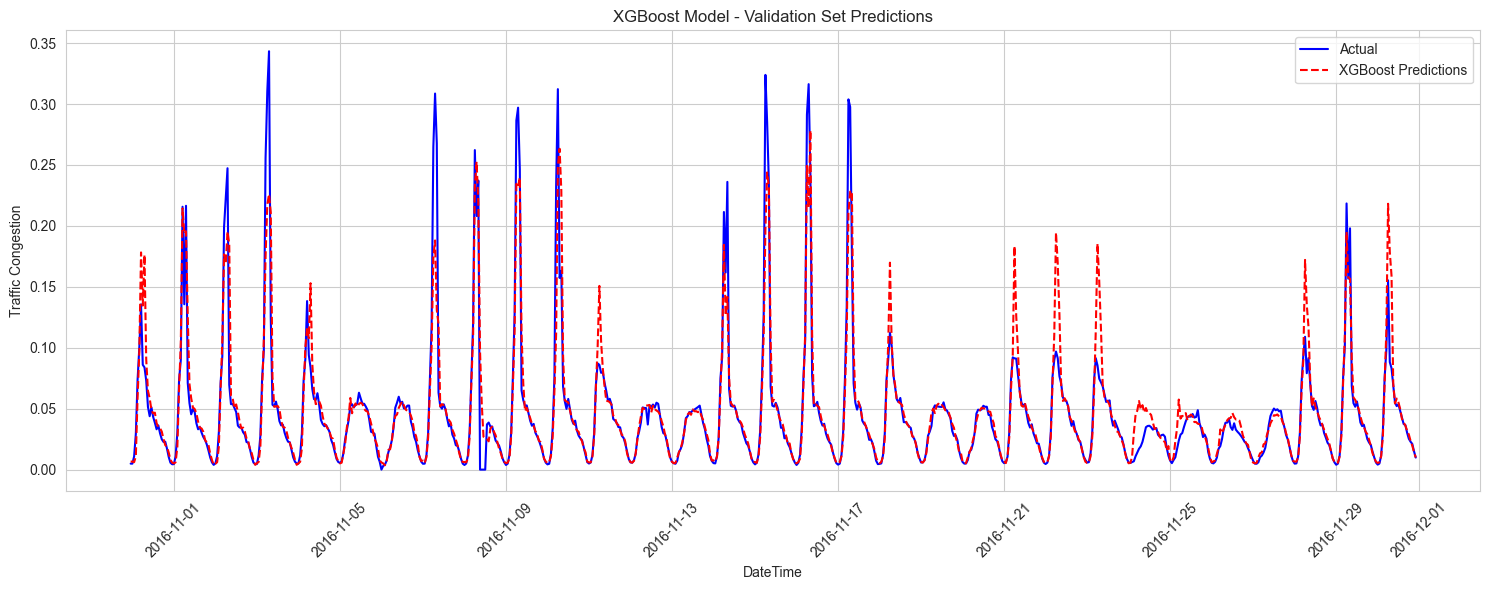

In [ ]:
# Cell 51 - Visualize ML Model Predictions vs Actual on Validation Set

val_index = X_all.index[train_size:]  # If X_all is a DataFrame with the same index
# If X_all isn't a DataFrame with an index, you can reconstruct from df_processed or use a date range.

import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))

plt.plot(val_index, y_val, label='Actual', color='blue')
plt.plot(val_index, y_val_pred, label='XGBoost Predictions', color='red', linestyle='--')
plt.title('XGBoost Model - Validation Set Predictions')
plt.xlabel('DateTime')
plt.ylabel('Traffic Congestion')
plt.legend()
plt.grid(True)

# Format x-axis if desired
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


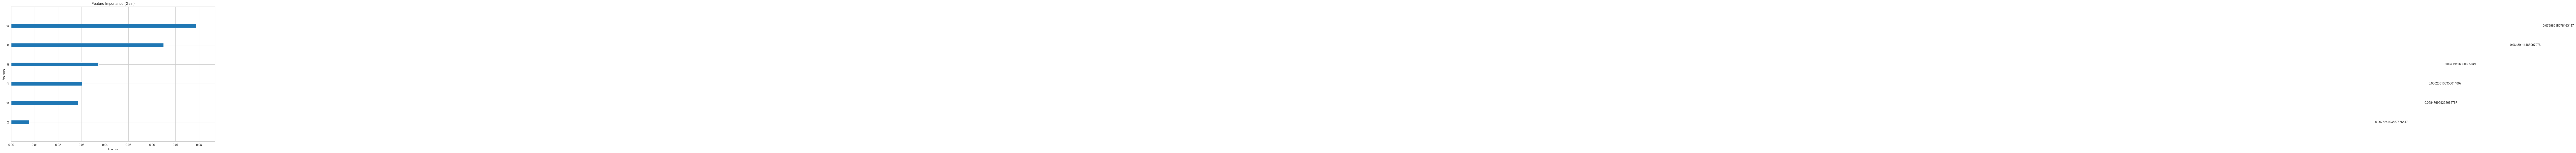

In [ ]:
# Cell 52 - Check Feature Importance and Save the Model

# Plot feature importance
xgb.plot_importance(bst, max_num_features=10, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.show()

# Save the trained model
bst.save_model('xgb_traffic_congestion.model')

# Or using pickle:
# with open('xgb_traffic_model.pkl', 'wb') as f:
#     pickle.dump(bst, f)


In [198]:
# Cell 53 - Recursive forecaster for December 2016
def forecast_december_2016_xgb(model, df_processed, start_date='2016-12-01', end_date='2016-12-31 23:00:00'):
    """
    Recursively forecast December 2016 (744 hours) using the trained XGBoost model.
    We'll:
    1) Start from the last known row (Nov 30, 2016),
    2) For each hour in December, create the required lag features,
    3) Predict X(t+1),
    4) Append the prediction to our dataset so we can use it as a lag for the next step.
    
    Returns: 
      forecast_df (pd.DataFrame) with datetime, predicted, and naive +/-1.96*std intervals.
    """

    # 1) We need the standard deviation of residuals from training to create naive intervals
    #    If you haven't saved residuals, we can quickly compute them from the training set.
    #    The easiest is to re-predict on the training set:
    from copy import deepcopy
    import numpy as np
    
    X_train = xgb.DMatrix(X_train_global)  # We'll define X_train_global in the next cell
    y_train_pred = model.predict(X_train)
    train_resid = y_train_global - y_train_pred
    resid_std = np.std(train_resid)  # standard deviation of training residuals

    # 2) We'll copy df_processed so as not to modify the original
    df_copy = df_processed.copy()

    # We'll ensure our DataFrame is sorted and we only do the recursive from the last known date
    df_copy.sort_index(inplace=True)
    last_known_time = pd.Timestamp('2016-11-30 23:00:00')

    # 3) Build an empty list to store predictions
    future_preds = []

    # 4) We'll create a range of timestamps from 2016-12-01 to 2016-12-31 23:00:00
    future_dates = pd.date_range(start=start_date, end=end_date, freq='H')

    # 5) Recursive loop
    current_time = last_known_time
    for future_time in future_dates:
        # Create row of features for 'future_time - 1 hour' if we want to predict this hour
        # Actually, since we used "lead=1", we want to predict X(future_time) using data as of (future_time - 1h).

        # We'll define a small function to build the feature row:
        row_features = build_feature_row(df_copy, future_time - pd.Timedelta(hours=1))

        # Make a single prediction using the model
        dpred = xgb.DMatrix(row_features)
        pred_value = model.predict(dpred)[0]

        # Append the predicted value as X(future_time) to the DataFrame
        new_row = {
            'X': pred_value,
            'hour': future_time.hour,
            'day_of_week': future_time.dayofweek,
            'month': future_time.month,
            'is_weekend': 1 if future_time.dayofweek in [5, 6] else 0
            # If you rely on rolling_mean_24h or rolling_std_24h, 
            # you'd need a dynamic way to update them. 
            # For simplicity, we won't recalc rolling stats here 
            # (or you can do a more advanced approach).
        }
        df_copy.loc[future_time] = new_row

        # Save the final predicted value for plotting
        future_preds.append((future_time, pred_value))

    # 6) Build a forecast DataFrame
    forecast_df = pd.DataFrame(future_preds, columns=['datetime', 'XGB_forecast'])
    forecast_df.set_index('datetime', inplace=True)

    # 7) Compute naive confidence intervals
    #    +/- 1.96 * resid_std
    ci = 1.96 * resid_std
    forecast_df['lower'] = forecast_df['XGB_forecast'].apply(lambda x: max(x - ci, 0))  # non-negative
    forecast_df['upper'] = forecast_df['XGB_forecast'] + ci

    return forecast_df


def build_feature_row(df_processed, ref_time):
    """
    Build a single row of features for XGBoost based on:
      - X(t-1), X(t-24), 
      - hour, day_of_week, month, is_weekend
      - rolling_mean_24h, rolling_std_24h (if feasible).
    
    Returns: a one-row DataFrame matching the columns used by X_train.
    """
    # For clarity, let's just implement the same lags from the create_supervised_dataset
    # Note: This function must replicate the logic of "lag_1, lag_24, plus any other features"
    import pandas as pd

    # We'll gather the row that corresponds to ref_time in df_processed
    # (We assume it already exists in df_copy if we do recursive approach)
    if ref_time not in df_processed.index:
        # If not found, just create a row of zeros or do something
        # But ideally, your code ensures continuity.
        return pd.DataFrame([0], columns=['lag_1'])  # minimal fallback

    # We'll build a dictionary for each feature
    row_dict = {}

    # lag_1 means X at ref_time
    row_dict['lag_1'] = df_processed.loc[ref_time, 'X'] if ref_time in df_processed.index else 0.0

    # lag_24 means X at ref_time - 23 hours
    # (Be careful that if we want X(t-24), that means 24 hours behind the 'ref_time+1'... 
    # We'll keep it consistent with create_supervised_dataset's logic.)
    lag_24_time = ref_time - pd.Timedelta(hours=23)  # or 24, depending on your definition
    row_dict['lag_24'] = df_processed.loc[lag_24_time, 'X'] if lag_24_time in df_processed.index else 0.0

    # hour, day_of_week, month, is_weekend
    row_dict['hour'] = ref_time.hour
    row_dict['day_of_week'] = ref_time.dayofweek
    row_dict['month'] = ref_time.month
    row_dict['is_weekend'] = 1 if ref_time.dayofweek in [5, 6] else 0

    # If you want rolling stats, you'd have to keep them updated. 
    # For simplicity, let's skip. 
    # If you do want them, you must recalc them from the newly appended predictions.

    # Convert to DataFrame with the same column order as X_train_global
    row_df = pd.DataFrame([row_dict])
    row_df = row_df[X_train_columns_global]  # ensure same column order
    return row_df


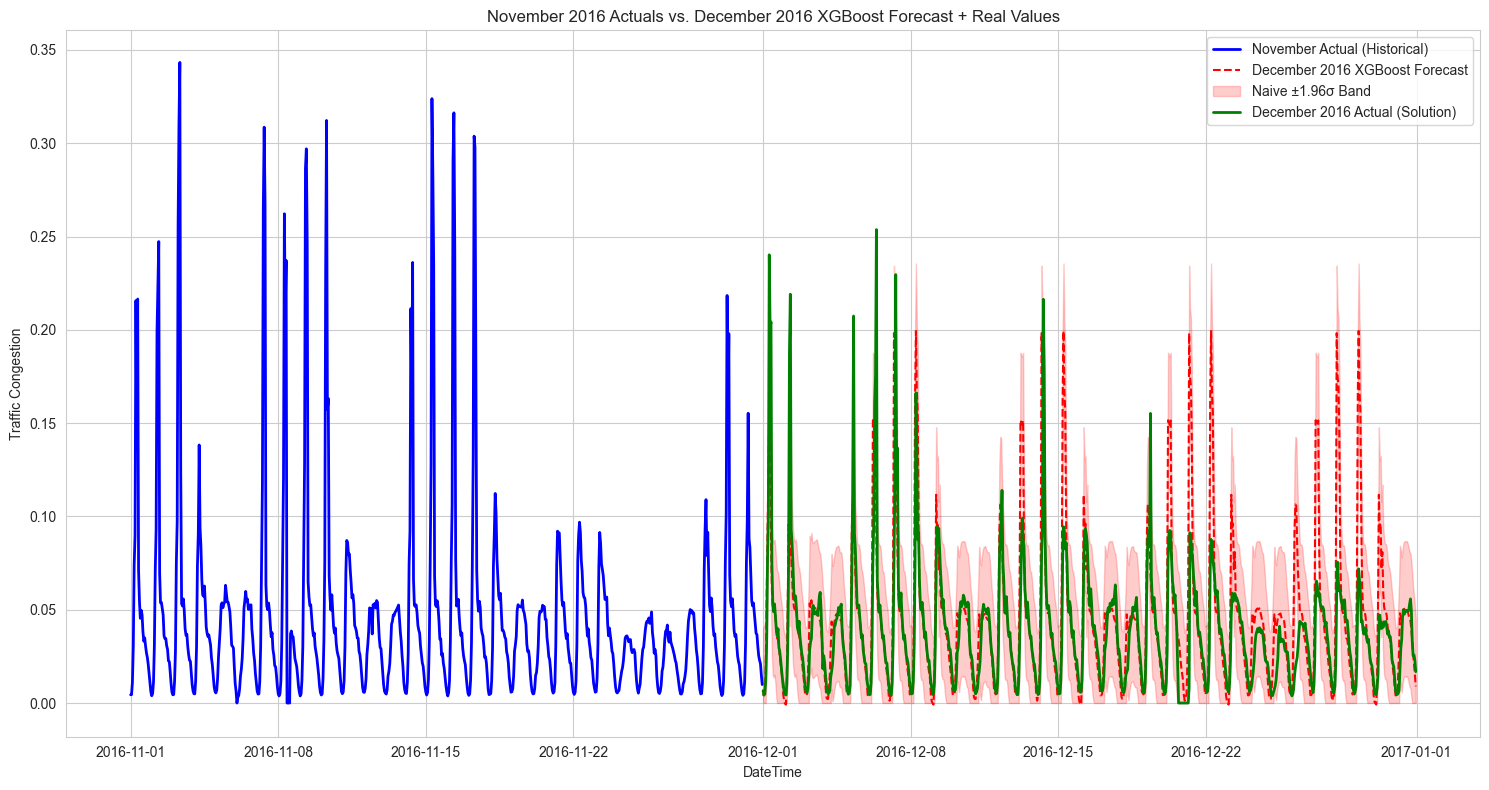

December Forecast Error Metrics:
  RMSE: 0.0277
  MAE:  0.0139
  MAPE: inf%


In [ ]:
# Cell 54 - Generate December 2016 Forecast and Plot with Nov 2016 + Real Values

# 1) We must define X_train_global, y_train_global, X_train_columns_global for the function above
#    These are basically the final arrays or data frames used in training.
#    We'll name them consistently here:

X_train_global = X_train  # from your prior ML split cell
y_train_global = y_train
X_train_columns_global = list(X_all.columns)  # the columns in the original feature DataFrame

# 2) Run the forecaster
forecast_xgb_df = forecast_december_2016_xgb(bst, df_processed)

# 3) Load real December 2016 values from solution
dec_solution = pd.read_csv('solution/t2_solution.csv')
dec_solution['DateTime'] = pd.to_datetime(dec_solution['DateTime'], format='mixed', errors='coerce')
dec_solution.set_index('DateTime', inplace=True)
dec_solution.sort_index(inplace=True)

# 4) Extract Nov 2016 actuals from your main df
november_actuals = df.loc['2016-11-01':'2016-11-30 23:00:00', 'X']  # or .copy()

# 5) Plot everything
plt.figure(figsize=(15, 8))

# Plot November actual
plt.plot(november_actuals.index, november_actuals.values,
         label='November Actual (Historical)',
         color='blue', linewidth=2)

# Plot December XGBoost forecast
plt.plot(forecast_xgb_df.index, forecast_xgb_df['XGB_forecast'],
         label='December 2016 XGBoost Forecast',
         color='red', linestyle='--')

# Plot naive confidence intervals
plt.fill_between(forecast_xgb_df.index,
                 forecast_xgb_df['lower'],
                 forecast_xgb_df['upper'],
                 color='red', alpha=0.2,
                 label='Naive ±1.96σ Band')

# Plot December real values from solution
dec_real = dec_solution.loc['2016-12-01':'2016-12-31 23:00:00', 'X']
plt.plot(dec_real.index, dec_real.values,
         label='December 2016 Actual (Solution)',
         color='green', linewidth=2)

plt.title('November 2016 Actuals vs. December 2016 XGBoost Forecast + Real Values')
plt.xlabel('DateTime')
plt.ylabel('Traffic Congestion')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6) (Optional) Print out error metrics for December
common_index = forecast_xgb_df.index.intersection(dec_real.index)
y_true_dec = dec_real.loc[common_index]
y_pred_dec = forecast_xgb_df.loc[common_index, 'XGB_forecast']

rmse_dec = np.sqrt(mean_squared_error(y_true_dec, y_pred_dec))
mae_dec = mean_absolute_error(y_true_dec, y_pred_dec)
mape_dec = np.mean(np.abs((y_true_dec - y_pred_dec) / y_true_dec)) * 100

print("December Forecast Error Metrics:")
print(f"  RMSE: {rmse_dec:.4f}")
print(f"  MAE:  {mae_dec:.4f}")
print(f"  MAPE: {mape_dec:.2f}%")
